# LightGBM BaseLine 
## プリンター/グルア―を分離

[LightGBM](https://lightgbm.readthedocs.io/en/v3.3.3/)で予測モデルを作るベースラインです。  

## LightGBM 

- 勾配ブースティング決定木モデルという機械学習モデルの一つです  
- Microsoftが開発しています  
- Kaggle等の分析コンペで鉄板のモデルで、特に今回のような表形式のデータに対して強いです 
- 外れ値をそのまま扱ってくれる、数値のスケールにあまり左右されない、といった特徴があるので、前処理をそんなにせずにサクッと試せることや、比較的学習時間が早いということで、初期段階で試すモデルとしてとても人気です  
  + もちろん最終的に使うことも多いと思います 

In [49]:
# 自分のマイドライブにマウントする
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
!pip install autofeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
!pip install japanize-matplotlib xfeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# ディレクトリ設定
work_dir = "dxq"
class Config:
    root = f"/content/drive/MyDrive/マナビDX_Quest/PBL05/data"
    input_dir = "/content/drive/MyDrive/マナビDX_Quest/PBL05/data"
    output_dir = "/content/drive/MyDrive/マナビDX_Quest/PBL05/data/output"
    submission_dir = "/content/drive/MyDrive/マナビDX_Quest/PBL05/submit"
    model_dir = "/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model"

In [53]:
cd {Config.root}

/content/drive/MyDrive/マナビDX_Quest/PBL05/data


↓以下のようなディレクトリ構成。  
適宜自分の環境に調整ください。   

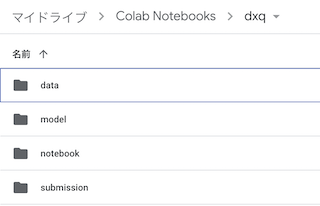

In [54]:
import os
import datetime
import json

import pickle
import numpy as np
import pandas as pd

# 特徴量エンジニアリングいっぱいしてくれるライブラリ 
# 今回はLabelEncoderのみ使用
from xfeat import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
sns.set(
    context='notebook',
    style='whitegrid',
    palette='muted',
    font='IPAexgothic'
)

from sklearn.model_selection import KFold
import lightgbm as lgb

## 前処理定義  

- csvを読み込む  
- mergeする  
- ぱっと思いつく範囲の特徴量エンジニアリング  

In [6]:
class Connector:
    """データ形式に応じてデータを読み込み、dfとして返す処理
    """
    def __init__(self, mode='csv'):
        self.mode = mode
        self.loader = {
            'csv': self.load_csv
        }

    def load_csv(self, path):
        df = pd.read_csv(path, index_col=None)
        return df

    def __call__(self, path):
        """
        データの読み込み
        """
        return self.loader[self.mode](path)
    

def load_data(base_path, processing_path, actual_path, connector):
    """
    全てのcsvファイルを読んで、mergeする処理
    trainはtrain、testはtestで処理を回す
    """
    base = connector(base_path)
    processing = connector(processing_path)
    actual = connector(actual_path)
    """
    df_merge = pd.merge(processing, base, on='受注番号',how='inner', suffixes=['', '_r'])
    df_merge = pd.merge(df_merge, actual, on=['受注番号', '号機名'], how='inner', suffixes=['', '_r'])
    """
    df_merge = pd.merge(actual, processing, on=['受注番号', '号機名'], how='left', suffixes=['', '_r'])    
    df_merge = pd.merge(df_merge, base, on='受注番号',how='left', suffixes=['', '_r'])

    # 重複列をbase情報に揃える
    dr_cols = [c for c in df_merge.columns if c.endswith('_r')]
    df_merge = df_merge.drop(columns=dr_cols)
    return df_merge

In [7]:
class BaseTransform:
    """
    汎用的な変数変換処理
    Arguments:
        columns_config : dict。以下の形 
        {"カラム名1" : "数値", 
        "カラム名2" : "カテゴリ", 
        "カラム名3" : "日付, 
         ・
         ・
         ・
        }
    """
    
    def __init__(self, column_config, df, label_encoder=None, target_encoder=None, model_dir='./'):
        self.df = df
  
        self.column_config = column_config
        self.target = ['グルアー', '7号機', '8号機', '6号機', '4号機', '2号機']
        self.capacity = {
            'グルアー': 3000,
            '7号機': 3800,
            '8号機': 4150,
            '6号機': 3900,
            '4号機': 4300,
            '2号機': 3200
            }
        self.le = label_encoder
        self.te = target_encoder
        self.model_dir = model_dir
        # 使用するカラムのみに限定
        self.df = self.df[list(self.column_config.keys())]
        self.df["index"] = df["index"]      
        
        # 号機名で限定
        self.df = self.df[self.df['号機名'].isin(self.target)]
        # 欠損処理は先にしておく
        self.process_na()

    def __call__(self):
        """
        column_configに従って各カラムを処理
        """
        self.key()
        self.numerical()
        self.add_calc()
        self.label_encoding()
        self.target_encoding()
        self.boolian()
        self.datelike()
        return self.df

    def key(self):
        """
        KEYのカラムは不要なので落とす
        """
        columns = [k for k, v in self.column_config.items() if v == 'KEY']
        self.df = self.df.drop(columns=columns)

    def process_na(self):
        """欠損処理(複数パターンある場合は別途クラスで定義する)
        """
        self.df = self.df.replace({"« NULL »": np.nan})
        #self.df = self.df.dropna(how='all', axis=1)

    def label_encoding(self):
        """
        ラベルエンコーディング処理
        xfeatを使う  
        """
        columns = [k for k, v in self.column_config.items() if v == 'カテゴリ']
        if not self.le:
            self.le = LabelEncoder(input_cols=columns, output_suffix='')
            self.le.fit(self.df)
            # モデル保存
            fname = "le_" + datetime.datetime.now().strftime("%Y%m%d%H%M") + ".pickle"
            output_path = os.path.join(self.model_dir, fname)
            with open(output_path, "wb") as f:
                pickle.dump(self.le, f)

        self.df[columns] = self.le.transform(self.df[columns])

    def target_encoding(self):
        """
        ターゲットエンコーディング処理
        """
        # 使うことになったら書く
        pass

    def numerical(self):
        """
        floatに変換する処理
        """
        columns = [k for k, v in self.column_config.items() if v == '数値']
        self.df[columns] = self.df[columns].astype(float)

    def boolian(self):
        """
        値があるところを1、それ以外を0に変換する処理
        """
        columns = [k for k, v in self.column_config.items() if v == 'bool']
        # naか判定→ bool逆転処理
        tf_values = self.df[columns].isnull().values
        self.df[columns] = np.logical_not(tf_values)

    def datelike(self):
        """
        日付型に変換し、月番号カラム、週番号、曜日番号を追加して元のカラムを落とす処理
        """
        columns = [k for k, v in self.column_config.items() if v == '日付']
        for col in columns:
            self.df[col] = pd.to_datetime(self.df[col])

        for col in columns:
            self.df[col + "_月"] = self.df[col].dt.month
            self.df[col + "_週"] = self.df[col].dt.week
            self.df[col + "_曜日"] = self.df[col].dt.weekday
        # 元の日付カラムを落とす
        # self.df = self.df.drop(columns=columns)

    def add_calc(self):
        """
        単純な予測式からの算出
        """
        def calc_mhpred(num1, capacity):
            """
            付帯作業時間(固定30分)を除いた稼働時間予測式
            Args:
            num1: 数量1
            capacity : 機械の処理能力(30分あたり)
            """
            y_hat = num1/capacity*30
            return y_hat

        capacity = self.df['号機名'].apply(lambda x: self.capacity[x])
        y_hat_prev = calc_mhpred(self.df['数量1'], capacity.values)
        self.df['作業時間_数式予測値'] = y_hat_prev

In [13]:
class AdvancedTransform:
    """
    * dfをinputしてdfを返す
    * 機械学習可能なオブジェクトを返す
    """

    def __init__(self, phase, config, mode):
        self.phase = phase
        self.config = config
        self.mode = mode
 

    def __call__(self, df):
        """必要な前処理を実行
        """
        self.df = df
        self.process_outer()
        self.drop_columns()
        #if self.mode == "printer":        
        self.calc_area_features()

        self.calc_incidental()
        self.calc_cp()
        self.drop_datecols()
        self.drop_obj()
        return self.df

    def process_outer(self):
        """外れ値処理(複数パターンある場合は別途クラスで定義)
        """
        pass

    def drop_columns(self):
        """全欠損カラムとユニーク値が1種類のカラムを除去する
        """
        if self.phase == 'train':
            dr_columns = []
            for col in self.df.columns:
                if len(self.df[col].unique()) <= 1:
                    dr_columns.append(col)
            if not dr_columns == []:
                #self.df = self.df.drop(columns=dr_columns)
                print(f'{dr_columns} removed.')
        
        """
        if self.phase == 'train':
            self.df = self.df.dropna(how='all', axis=1)
        """
        

    def calc_area_features(self):
        """
        面積系の特徴量を作る
        """
        self.df['展開面積'] = self.df['展開寸法幅'].astype(
            float) * self.df['展開寸法幅'].astype(float)/100
        self.df['数量*面積'] = self.df['数量1'].astype(float) * self.df['展開面積']
        self.df['数量*面積_log'] = np.log1p(self.df['数量*面積'])

        #if self.mode == "printer": 
        self.df.loc[self.df["刷本寸法長さ"]=="« NULL »","刷本寸法長さ"]=-0
        self.df.loc[self.df["刷本寸法長さ"].isnull(),"刷本寸法長さ"]=0

        self.df.loc[self.df["刷本寸法幅"]=="« NULL »","刷本寸法幅"]=-0
        self.df.loc[self.df["刷本寸法幅"].isnull(),"刷本寸法幅"]=0


        self.df['刷本面積'] = self.df['刷本寸法長さ'] * self.df['刷本寸法幅'].astype(float)/100
        self.df['数量*刷本面積'] = self.df['数量1'] * self.df['刷本面積']
        self.df['数量*刷本面積_log'] = np.log1p(self.df['数量*刷本面積'])


    def calc_incidental(self):
        """
        2020年2月3日までの付帯作業時間は、「所要時間 - (作業時間+残業時間)」
        """
        if self.phase == 'train':
            lim = datetime.datetime(2020, 2, 4)
            self.df['作業付帯時間'] = self.df['合計時間'].copy()
            prev_lim = self.df.loc[self.df['作業日'] < lim].copy()
            self.df.loc[self.df['作業日'] < lim, "作業付帯時間"] = prev_lim['所要時間'] - \
                prev_lim['作業時間'] - prev_lim['残業時間']
            self.df = self.df.drop(columns=['残業時間', '合計時間', '所要時間'])

    def calc_cp(self):
        """
        工期の計算
        """
        self.df['工期'] = (self.df['作業日'] - self.df['受注日']).dt.days

    def drop_datecols(self):
        """
        日付カラムをドロップする
        """
        columns = [k for k, v in self.config.items() if v == '日付']
        self.df = self.df.drop(columns=columns)

    def drop_obj(self):
        """
        目的変数を落とす(test用処理)
        """
        if self.phase == 'test:':
            self.df = self.df.drop(columns=["作業時間", "作業付帯時間"])
        else:
            pass

このnotebookが保存されているディレクトリに、`column_config.json`というjsonファイルを置いてください。  

In [9]:
# 設定読み込み
config_path = '/content/drive/MyDrive/マナビDX_Quest/PBL05/column_config.json'
with open(config_path, "r") as f:
    column_config = json.load(f)

## データ読み込み

In [14]:
# データ読み込み
cn_train = Connector(mode='csv')
cn_test = Connector(mode='csv')

# inpur/train input/test というディレクトリ構成にしています 
# ここも環境ごとに変えてください
train_dir = os.path.join(Config.input_dir, 'train')
test_dir = os.path.join(Config.input_dir, 'test')
train_fnames = {
    'base_path': 'base_train.csv',
    'processing_path': 'processing_train.csv',
    'actual_path': 'actual_train.csv'
}
test_fnames = {
    'base_path': 'base_test.csv',
    'processing_path': 'processing_test.csv',
    'actual_path': 'actual_test.csv'
}

train_paths = {k: os.path.join(train_dir, v) for k, v in train_fnames.items()}
test_paths = {k: os.path.join(test_dir, v) for k, v in test_fnames.items()}

# train/test それぞれのデータをマージ
df_train = load_data(connector=cn_train, **train_paths)
df_train = df_train.replace("« NULL »", np.nan)
df_train = df_train.dropna(how='all', axis=1)

df_train = df_train.dropna(subset=["数量1"])
df_train

df_train["index"] = df_train.index
df_test = load_data(connector=cn_test, **test_paths)

printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_train_printer = df_train[df_train["号機名"].isin(printer_list)]
df_train_gluer = df_train[df_train["号機名"] == 'グルアー']

#df_test = df_test.sort_values(by='index', ascending=True).drop(columns=['index'])
df_test_printer = df_test[df_test["号機名"].isin(printer_list)]
df_test_gluer = df_test[df_test["号機名"] == 'グルアー']

# 結合
#df_all = pd.concat([df_test, df_train]).reset_index(drop=True)
"""
df_test_printer["Type"]="test"
df_train_printer["Type"]="train"
df_test_gluer["Type"]="test"
df_train_gluer["Type"]="train"
"""
df_printer = pd.concat([df_test_printer, df_train_printer]).reset_index(drop=True)
df_gluer = pd.concat([df_test_gluer, df_train_gluer]).reset_index(drop=True)


# 後で分割する用
#test_idx = len(df_test)
test_printer_idx = len(df_test_printer)
test_gluerr_idx = len(df_test_gluer)

<ipython-input-6-02a5ec5712f8>:18: DtypeWarning: Columns (2,9,15,24,33,34,35,38,39,43,45,46,48,49,50) have mixed types.Specify dtype option on import or set low_memory=False.
  return self.loader[self.mode](path)
<ipython-input-6-02a5ec5712f8>:18: DtypeWarning: Columns (12,13,15,16,22,23,30,33,34,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,61,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  return self.loader[self.mode](path)


In [11]:
pd.set_option('display.max_columns', None)

## 前処理

前処理をやって、訓練データと評価データに分けます

In [15]:
#df_all["Machine"]= df_all["号機名"]

# 一括前処理
base_transform_printer = BaseTransform(
    column_config=column_config, 
    df=df_printer, 
    model_dir=Config.model_dir
    )
df_printer = base_transform_printer()

base_transform_gluer = BaseTransform(
    column_config=column_config, 
    df=df_gluer, 
    model_dir=Config.model_dir
    )
df_gluer = base_transform_gluer()

# 追加前処理
adv_transform_train_printer = AdvancedTransform(phase='train', config=column_config, mode="printer")
adv_transform_test_printer = AdvancedTransform(phase='test', config=column_config, mode="printer")
adv_transform_train_gluer = AdvancedTransform(phase='train', config=column_config, mode="gluer")
adv_transform_test_gluer = AdvancedTransform(phase='test', config=column_config, mode="gluer")

train_printer_df = df_printer.iloc[test_printer_idx:].copy()
test_printer_df = df_printer.iloc[:test_printer_idx].copy()

train_gluer_df = df_gluer.iloc[test_gluerr_idx:].copy()
test_gluer_df = df_gluer.iloc[:test_gluerr_idx].copy()


train_printer_df = adv_transform_train_printer(train_printer_df)
test_printer_df = adv_transform_test_printer(test_printer_df)
#est_printer_tmp = test_printer_df[train_printer_df.columns].copy()

train_gluer_df = adv_transform_train_gluer(train_gluer_df)
test_gluer_df = adv_transform_test_gluer(test_gluer_df)
#test_gluer_tmp = test_gluer_df[train_gluer_df.columns].copy()


<ipython-input-7-14c92ef1e7d9>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["index"] = df["index"]
<ipython-input-7-14c92ef1e7d9>:116: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  self.df[col + "_週"] = self.df[col].dt.week


['工程名'] removed.
['号機名', '数量2', '数量項目名2', '数量3', '数量項目名3', '通し実数', '刷了数', '印刷予備数', '加工予備数', '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅'] removed.


In [16]:
train_printer_df.columns

Index(['製品仕様コード', '受注数量', '流用受注番号', '頁数', '展開寸法幅', '展開寸法長さ', '号機名', '数量1',
       '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '合計数量', '予備数量', '仕上数量',
       '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', 'カテゴリ名1', 'カテゴリ名2',
       '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分名', '作業時間', 'index',
       '作業時間_数式予測値', '受注日_月', '受注日_週', '受注日_曜日', '作業日_月', '作業日_週', '作業日_曜日',
       '展開面積', '数量*面積', '数量*面積_log', '刷本面積', '数量*刷本面積', '数量*刷本面積_log',
       '作業付帯時間', '工期'],
      dtype='object')

In [17]:
test_printer_df.columns


Index(['製品仕様コード', '受注数量', '流用受注番号', '頁数', '展開寸法幅', '展開寸法長さ', '号機名', '数量1',
       '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '合計数量', '予備数量', '仕上数量',
       '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', 'カテゴリ名1', 'カテゴリ名2',
       '工程名', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分名', '所要時間', '作業時間', '残業時間',
       '合計時間', 'index', '作業時間_数式予測値', '受注日_月', '受注日_週', '受注日_曜日', '作業日_月',
       '作業日_週', '作業日_曜日', '展開面積', '数量*面積', '数量*面積_log', '刷本面積', '数量*刷本面積',
       '数量*刷本面積_log', '工期'],
      dtype='object')

In [43]:
train_printer_df

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,作業付帯時間,工期
4927,2577,1.0,False,48.0,939.0,636.0,4,250.0,0,0.0,0,1.0,0,50.0,40.0,10.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,-1,-1,0,NaN,NaN,0.0,0.0,6,1.0,52058,1.744186,7,27,0,7,28,2,8817.21,2204302.5,14.605922,0.00,0.0,0.000000,9.0,9
4928,1700,NaN,False,NaN,556.0,339.5,3,750.0,0,2.0,0,2.0,0,NaN,NaN,NaN,27.5,NaN,1.0,300.0,450.0,300.0,150.0,1,-1,0,4.0,NaN,650.0,950.0,0,5.0,55951,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,54.0,79
4929,1699,NaN,False,NaN,556.0,325.5,3,750.0,0,2.0,0,2.0,0,NaN,NaN,NaN,27.5,NaN,1.0,300.0,450.0,300.0,150.0,1,-1,0,4.0,NaN,650.0,950.0,0,5.0,55956,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,87.0,79
4930,2578,NaN,True,NaN,0.0,0.0,2,2500.0,0,8.0,0,0.0,0,NaN,NaN,NaN,48.5,NaN,1.0,2003.0,2100.0,400.0,97.0,1,0,0,4.0,4.0,636.0,939.0,0,18.0,66694,18.072289,11,47,2,12,51,4,0.00,0.0,0.000000,5972.04,14930100.0,16.518890,17.0,30
4931,2078,NaN,True,NaN,420.0,297.0,1,2000.0,0,4.0,0,0.0,0,NaN,NaN,NaN,45.0,NaN,1.0,1000.0,1000.0,1000.0,NaN,1,0,0,1.0,1.0,544.0,788.0,0,25.0,68457,15.384615,10,44,2,10,42,1,1764.00,3528000.0,15.076242,4286.72,8573440.0,15.964180,38.0,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12372,2607,NaN,True,NaN,75.0,125.0,3,1700.0,0,4.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,1104.0,1400.0,300.0,296.0,2,-1,0,4.0,0.0,545.0,395.0,4,18.0,110369,13.421053,3,12,0,3,12,4,56.25,95625.0,11.468200,2152.75,3659675.0,15.112885,73.0,4
12373,787,NaN,True,NaN,NaN,NaN,1,7400.0,0,2.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,9500.0,10500.0,400.0,1000.0,1,0,0,1.0,1.0,625.0,880.0,3,52.0,110482,56.923077,5,21,0,6,25,0,NaN,NaN,NaN,5500.00,40700000.0,17.521739,25.0,28
12374,789,NaN,True,NaN,NaN,NaN,1,10900.0,0,2.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,9500.0,10500.0,400.0,1000.0,1,0,0,1.0,1.0,625.0,880.0,3,59.0,110483,83.846154,4,16,0,6,25,0,NaN,NaN,NaN,5500.00,59950000.0,17.909021,13.0,63
12375,4843,NaN,True,NaN,0.0,0.0,2,750.0,0,5.0,0,0.0,0,NaN,NaN,NaN,135.0,NaN,1.0,250.0,400.0,350.0,150.0,1,2,0,4.0,1.0,544.0,788.0,10,7.0,110499,5.421687,5,19,3,5,22,0,0.00,0.0,0.000000,4286.72,3215040.0,14.983351,51.0,18


In [44]:
test_printer_df

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,所要時間,作業時間,残業時間,合計時間,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,NaN,False,NaN,100.0,48.0,0,1400.0,0,1.0,0,4.0,0,NaN,NaN,NaN,NaN,NaN,1.0,848.0,960.0,440.0,112.0,0,-1,0,5.0,5.0,325.0,475.0,0,NaN,NaN,NaN,NaN,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
1,1,NaN,False,NaN,420.0,297.0,1,5000.0,0,1.0,0,0.0,0,NaN,NaN,NaN,44.5,NaN,1.0,4500.0,4600.0,400.0,100.0,1,0,0,1.0,0.0,625.0,880.0,0,NaN,NaN,NaN,NaN,1,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
2,2,NaN,True,NaN,297.0,210.0,2,2000.0,0,4.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,1500.0,1700.0,300.0,200.0,1,0,0,2.0,2.0,625.0,880.0,0,NaN,NaN,NaN,NaN,2,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
3,3,NaN,True,NaN,55.0,91.0,2,2000.0,0,5.0,0,0.0,0,NaN,NaN,NaN,200.0,NaN,1.0,1362.0,1428.0,572.0,66.0,1,1,0,2.0,3.0,392.0,544.0,0,NaN,NaN,NaN,NaN,3,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
4,4,NaN,True,NaN,0.0,0.0,1,900.0,0,0.0,0,2.0,0,NaN,NaN,NaN,35.0,NaN,1.0,NaN,NaN,NaN,NaN,1,0,0,1.0,1.0,625.0,880.0,0,NaN,NaN,NaN,NaN,4,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,2208,NaN,False,NaN,175.8,318.0,0,550.0,0,2.0,0,2.0,0,NaN,NaN,NaN,7.0,NaN,1.0,167.0,350.0,200.0,183.0,1,4,0,4.0,0.0,550.0,400.0,0,NaN,NaN,NaN,NaN,5978,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4923,625,NaN,False,NaN,170.0,80.0,0,800.0,0,1.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,167.0,400.0,400.0,233.0,1,5,0,4.0,1.0,548.0,398.0,2,NaN,NaN,NaN,NaN,5979,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4924,2486,NaN,False,NaN,62.0,90.0,0,1200.0,0,5.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,820.0,950.0,250.0,130.0,0,-1,0,5.0,0.0,325.0,475.0,0,NaN,NaN,NaN,NaN,5980,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4925,212,NaN,False,NaN,185.3,240.0,0,2800.0,0,1.0,0,0.0,0,NaN,NaN,NaN,7.0,NaN,1.0,2500.0,2700.0,100.0,200.0,1,4,0,1.0,0.0,550.0,400.0,0,NaN,NaN,NaN,NaN,5981,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [21]:
"""
test_printer_df = test_printer_df[train_printer_df.columns]
test_gluer_df = test_gluer_df[train_gluer_df.columns]
"""

KeyError: ignored

In [17]:
train_printer_df

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,作業付帯時間,工期
4927,2577,1.0,False,48.0,939.0,636.0,4,250.0,0,0.0,0,1.0,0,50.0,40.0,10.0,NaN,10.0,1.0,NaN,NaN,NaN,NaN,-1,-1,NaN,NaN,NaN,NaN,6,1.0,52058,1.744186,7,27,0,7,28,2,8817.21,2204302.5,14.605922,NaN,NaN,NaN,9.0,9
4928,1700,NaN,False,NaN,556.0,339.5,3,750.0,0,2.0,0,2.0,0,NaN,NaN,NaN,27.5,NaN,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,NaN,650.0,950.0,0,5.0,55951,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,54.0,79
4929,1699,NaN,False,NaN,556.0,325.5,3,750.0,0,2.0,0,2.0,0,NaN,NaN,NaN,27.5,NaN,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,NaN,650.0,950.0,0,5.0,55956,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,87.0,79
4930,2578,NaN,True,NaN,0.0,0.0,2,2500.0,0,8.0,0,0.0,0,NaN,NaN,NaN,48.5,NaN,1.0,2003.0,2100.0,400.0,97.0,1,0,4.0,4.0,636.0,939.0,0,18.0,66694,18.072289,11,47,2,12,51,4,0.00,0.0,0.000000,5972.04,14930100.0,16.518890,17.0,30
4931,2078,NaN,True,NaN,420.0,297.0,1,2000.0,0,4.0,0,0.0,0,NaN,NaN,NaN,45.0,NaN,1.0,1000.0,1000.0,1000.0,NaN,1,0,1.0,1.0,544.0,788.0,0,25.0,68457,15.384615,10,44,2,10,42,1,1764.00,3528000.0,15.076242,4286.72,8573440.0,15.964180,38.0,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12372,2607,NaN,True,NaN,75.0,125.0,3,1700.0,0,4.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,1104.0,1400.0,300.0,296.0,2,-1,4.0,0.0,545.0,395.0,4,18.0,110369,13.421053,3,12,0,3,12,4,56.25,95625.0,11.468200,2152.75,3659675.0,15.112885,73.0,4
12373,787,NaN,True,NaN,NaN,NaN,1,7400.0,0,2.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,9500.0,10500.0,400.0,1000.0,1,0,1.0,1.0,625.0,880.0,3,52.0,110482,56.923077,5,21,0,6,25,0,NaN,NaN,NaN,5500.00,40700000.0,17.521739,25.0,28
12374,789,NaN,True,NaN,NaN,NaN,1,10900.0,0,2.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,9500.0,10500.0,400.0,1000.0,1,0,1.0,1.0,625.0,880.0,3,59.0,110483,83.846154,4,16,0,6,25,0,NaN,NaN,NaN,5500.00,59950000.0,17.909021,13.0,63
12375,4843,NaN,True,NaN,0.0,0.0,2,750.0,0,5.0,0,0.0,0,NaN,NaN,NaN,135.0,NaN,1.0,250.0,400.0,350.0,150.0,1,2,4.0,1.0,544.0,788.0,10,7.0,110499,5.421687,5,19,3,5,22,0,0.00,0.0,0.000000,4286.72,3215040.0,14.983351,51.0,18


In [18]:
test_printer_df

,製品仕様コード,流用受注番号,展開寸法幅,展開寸法長さ,号機名,数量1,数量2,数量3,連量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,False,100.0,48.0,0,1400.0,1.0,4.0,NaN,1.0,848.0,960.0,440.0,112.0,0,-1,5.0,5.0,325.0,475.0,0,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
1,1,False,420.0,297.0,1,5000.0,1.0,0.0,44.5,1.0,4500.0,4600.0,400.0,100.0,1,0,1.0,0.0,625.0,880.0,0,1,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
2,2,True,297.0,210.0,2,2000.0,4.0,0.0,35.0,1.0,1500.0,1700.0,300.0,200.0,1,0,2.0,2.0,625.0,880.0,0,2,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
3,3,True,55.0,91.0,2,2000.0,5.0,0.0,200.0,1.0,1362.0,1428.0,572.0,66.0,1,1,2.0,3.0,392.0,544.0,0,3,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
4,4,True,0.0,0.0,1,900.0,0.0,2.0,35.0,1.0,NaN,NaN,NaN,NaN,1,0,1.0,1.0,625.0,880.0,0,4,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,2208,False,175.8,318.0,0,550.0,2.0,2.0,7.0,1.0,167.0,350.0,200.0,183.0,1,4,4.0,0.0,550.0,400.0,0,5978,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4923,625,False,170.0,80.0,0,800.0,1.0,0.0,35.0,1.0,167.0,400.0,400.0,233.0,1,5,4.0,1.0,548.0,398.0,2,5979,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4924,2486,False,62.0,90.0,0,1200.0,5.0,0.0,NaN,1.0,820.0,950.0,250.0,130.0,0,-1,5.0,0.0,325.0,475.0,0,5980,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4925,212,False,185.3,240.0,0,2800.0,1.0,0.0,7.0,1.0,2500.0,2700.0,100.0,200.0,1,4,1.0,0.0,550.0,400.0,0,5981,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [18]:
train_printer_df = train_printer_df.drop("index", axis=1)
train_gluer_df = train_gluer_df.drop("index", axis=1)

## 学習  

LightGBMは、意外とハイパーパラメータにそこまで精度が左右されない印象なので、とりあえずよくあるパラメータで学習させてみます。  

In [19]:
SEED = 0
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

### 正味作業時間の予測  

### 作業付帯時間の予測

## モデルの確認  

正味作業時間の予測モデルについて、特徴量重要度をみてみます

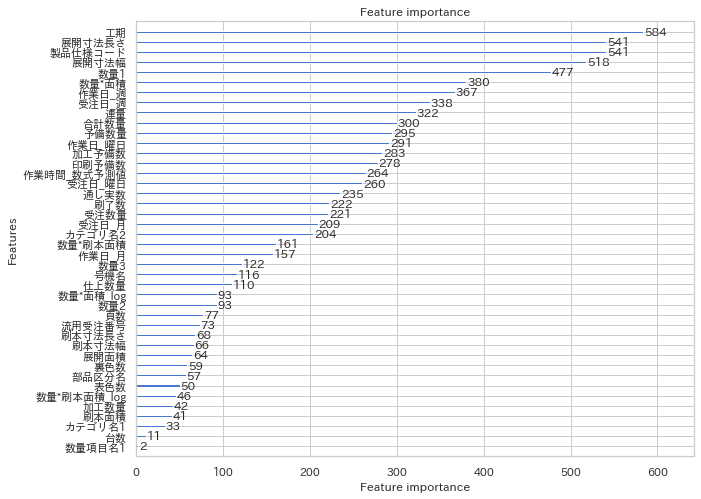

In [ ]:
"""
lgb.plot_importance(models[0], figsize=(10, 8))
plt.show()
"""

## 予測  

テストデータに対して予測結果を出力します。  
5分割の交差検証をしてモデルを作っているので、Foldごとにモデルが1つずつできています。  
どれか一つに代表させてもいいですが、今回はせっかく5つモデルがあるので、5モデルで予測→ 平均値を算出、という形でやってみます。

## Submit

ちなみにこんな感じ

一箇所提出後に修正した箇所があるので、正確なLBわからないですが、たぶんMAEで10前後だと思います。

In [20]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
"""
SEED = 0
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}
"""
SEED = 0
optuna_model_params = {'boosting_type': 'gbdt',
                    #'metric': 'rmse',
                    'metric': 'l1',
                    'learning_rate': 0.015,
                    'random_state': SEED,
                    'verbose': -1,
                    'show_progress_bar ': False,
                    'device': 'cpu',
                    'min_child_samples': 100, 
                    }

oputuna_fit_params ={'num_boost_rounds': 500,
                 'early_stopping_rounds': 300,
                 'verbose_eval': 100,
                }

In [22]:
def cal_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [23]:
from sklearn.metrics import mean_absolute_error
def cal_rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [24]:
import optuna.integration.lightgbm as opt_lgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
from tqdm.notebook import tqdm
import warnings
import re
warnings.simplefilter('ignore')
lgb_results = {} 
_loss_train = None
_loss_test = None
def fit_lgb_oputuna(x, y, cv, model_params, fit_params, fobj=None, feval=None):

    models = []
    n_records = y.shape[0]
    oof_pred = np.zeros(n_records, dtype=np.float32)
    fold = 0
    data_labels = [re.sub(r'[",\[\]{}:()]', '_', c) for c in x.columns.tolist()]
    print("data_labels:",data_labels)
    
    model_params.update(deterministic = True)

    best_params, history = {}, []
    best_params_list = []

    for trn_idx, val_idx in cv:

        fold += 1
        print("\n★★★★★　　　　　Fold {}　　　　　★★★★★".format(fold))
        #print(f"trn_idx :{trn_idx}")
        #print(f"val_idx :{val_idx}")

        x_train, x_valid = x.iloc[trn_idx].values, x.iloc[val_idx].values
        y_train, y_valid = np.array(y.iloc[trn_idx]), np.array(y.iloc[val_idx])

        lgb_train = lgb.Dataset(x_train, y_train, feature_name=data_labels)
        lgb_valid = lgb.Dataset(x_valid, y_valid, feature_name=data_labels, reference=lgb_train)

        lgb_results = {}                                    # 学習の履歴を入れる入物

        lgb_model = opt_lgb.train(model_params,
                              train_set=lgb_train,
                              valid_sets=[lgb_train, lgb_valid],
                              valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                              evals_result=lgb_results,
                              verbose_eval=-1,
                              num_boost_round=5000,
                              early_stopping_rounds=1000,         # アーリーストッピング設定
                              show_progress_bar = False,
                              time_budget = 10000,
                              #categorical_feature = CF
                              )

        #callbacks=[opt_lgb.early_stopping(oputuna_fit_params['early_stopping_rounds'])],
        pred_valid = lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration)
        oof_pred[val_idx] = pred_valid
        models.append(lgb_model)

        try:  
            best_params = lgb_model.params
            best_params_list.append(best_params)

            print("▼▼▼▼▼　　　　　Fold {}　　　　　▼▼▼▼▼".format(fold))
            print("best_params：",best_params)
            print("▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲")
        except:
            print('★★★★★　best_param output Error')


        # 損失推移を表示
        """
        loss_train = lgb_results['Train']['rmse']
        loss_test = lgb_results['Test']['rmse']   
        """
        loss_train = lgb_results['Train']['l1']
        loss_test = lgb_results['Test']['l1'] 
        _loss_train = loss_train
        _loss_test = loss_test
        
        fig = plt.figure()
        
        plt.xlabel('Iteration')
        plt.ylabel('rmse')

        plt.title(f"fold:{fold}")
        plt.plot(loss_train, label='train loss')
        plt.plot(loss_test, label='test loss')

        ax = plt.gca() # get current axes 現在の軸設定データを取得する
        #ax.set_ylim(18.0, 20.0)

        plt.legend()
        plt.show()


        #print(f' - fold{fold}_RMSE : {cal_rmse(y_valid, pred_valid):4f}')
        print(f' - fold{fold}_MAE : {cal_mae(y_valid, pred_valid):4f}')
        
        # modelの保存
        try:        
            #/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model
            file_path = f'/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model/models_gpu_' + str(fold -1) + '.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(lgb_model, f)
            
            file_path = f'/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model/models_gpu_all.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(models, f)

            file_path = f'/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model/oof_pred.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(oof_pred, f)


            file_path = f'/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model/opt_lgb_gpu.pkl'
            with open(file_path, 'wb') as f:
                pickle.dump(lgb_model, f)
        except:
            print('★★★★★　opt_lgb.pkl Save Error')


    #print(f' - CV_MAE : {cal_rmse(oof_pred, np.array(y)):4f}') 
    print(f' - CV_MAE : {cal_mae(oof_pred, np.array(y)):4f}') 

    file_path = f'/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model/lgb_models1.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(models, f)

    file_path = f'/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model/oof_valid_lgb1.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(oof_pred, f)

    return oof_pred, models

In [ ]:
#params

In [25]:
# AutoFeat用
train_printer_df_AF = train_printer_df.fillna(0)
train_gluer_df_AF = train_gluer_df.fillna(0)

test_printer_AF = test_printer_df.fillna(0)
test_gluer_AF = test_gluer_df.fillna(0)

test_printer_AF =test_printer_AF.drop("index", axis=1)
test_gluer_AF =test_gluer_AF.drop("index", axis=1)

In [89]:
test_gluer_df

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,所要時間,作業時間,残業時間,合計時間,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,NaN,False,NaN,0.0,0.0,0,5000.0,0,NaN,-1,NaN,-1,5400.0,400.0,5000.0,20.0,5000.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,9,50.0,7,28,2,8,32,0,0.0000,0.00,0.000000,0.0,0.0,0.0,26
1,1,NaN,False,NaN,376.0,209.0,0,500.0,0,NaN,-1,NaN,-1,0.0,0.0,0.0,23.5,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,14,5.0,7,30,2,8,32,0,1413.7600,706880.00,13.468618,0.0,0.0,0.0,12
2,2,500.0,False,1.0,149.5,256.0,0,500.0,0,NaN,-1,NaN,-1,800.0,300.0,500.0,27.0,500.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,20,5.0,7,30,2,8,32,0,223.5025,111751.25,11.624040,0.0,0.0,0.0,12
3,3,NaN,False,NaN,588.0,249.0,0,1000.0,0,NaN,-1,NaN,-1,0.0,200.0,1000.0,12.0,1000.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,28,10.0,7,30,1,8,32,0,3457.4400,3457440.00,15.056039,0.0,0.0,0.0,13
4,4,NaN,False,NaN,233.0,478.0,0,14000.0,0,NaN,-1,NaN,-1,0.0,700.0,14000.0,23.0,14000.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,29,140.0,7,30,1,8,32,0,542.8900,7600460.00,15.843719,0.0,0.0,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,205,NaN,False,NaN,217.5,436.0,0,1000.0,0,NaN,-1,NaN,-1,1200.0,200.0,1000.0,9.5,1000.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,5954,10.0,2,5,3,2,7,1,473.0625,473062.50,13.066985,0.0,0.0,0.0,12
1052,55,NaN,False,NaN,221.0,342.0,0,500.0,0,NaN,-1,NaN,-1,NaN,200.0,500.0,7.0,500.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,5956,5.0,2,5,4,2,7,1,488.4100,244205.00,12.405767,0.0,0.0,0.0,11
1053,492,NaN,False,NaN,217.5,436.0,0,500.0,0,NaN,-1,NaN,-1,700.0,200.0,500.0,9.5,500.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,5957,5.0,2,5,3,2,7,1,473.0625,236531.25,12.373840,0.0,0.0,0.0,12
1054,44,NaN,False,NaN,175.8,318.0,0,500.0,0,NaN,-1,NaN,-1,NaN,250.0,500.0,7.0,500.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0,0.0,-1,NaN,NaN,NaN,NaN,5959,5.0,2,5,4,2,7,1,309.0564,154528.20,11.948138,0.0,0.0,0.0,11


In [26]:
train_printer_main_x = train_printer_df_AF.drop(columns=['作業時間', '作業付帯時間'])
train_printer_main_y = train_printer_df_AF['作業時間']

train_printer_sub_x = train_printer_df_AF.drop(columns=['作業時間', '作業付帯時間'])
train_printer_sub_y = train_printer_df_AF['作業付帯時間']

train_gluer_main_x = train_gluer_df_AF.drop(columns=['作業時間', '作業付帯時間'])
train_gluer_main_y = train_gluer_df_AF['作業時間']

train_gluer_sub_x = train_gluer_df_AF.drop(columns=['作業時間', '作業付帯時間'])
train_gluer_sub_y = train_gluer_df_AF['作業付帯時間']

### Autofeatを使用

In [27]:

# ライブラリーの読み込み
import pandas as pd
from autofeat import AutoFeatRegressor                 #AutoFeat
from sklearn.model_selection import train_test_split   #データセットの分割（学習データとテストデータ）
from sklearn.datasets import fetch_california_housing  #サンプルデータ
from sklearn.linear_model import LinearRegression      #線形モデル
from sklearn.metrics import r2_score                   #精度評価で利用（R2:決定係数）


In [28]:
# AutoFeat用
autofeat_printer_main_mdl = AutoFeatRegressor(verbose=1)
autofeat_printer_sub_mdl = AutoFeatRegressor(verbose=1)
autofeat_gluer_main_mdl = AutoFeatRegressor(verbose=1)
autofeat_gluer_sub_mdl = AutoFeatRegressor(verbose=1)

In [29]:
train_printer_main_x

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
4927,2577,1.0,False,48.0,939.0,636.0,4,250.0,0,0.0,0,1.0,0,50.0,40.0,10.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,-1,-1,0,0.0,0.0,0.0,0.0,6,1.744186,7,27,0,7,28,2,8817.21,2204302.5,14.605922,0.00,0.0,0.000000,9
4928,1700,0.0,False,0.0,556.0,339.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,0,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,79
4929,1699,0.0,False,0.0,556.0,325.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,0,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,79
4930,2578,0.0,True,0.0,0.0,0.0,2,2500.0,0,8.0,0,0.0,0,0.0,0.0,0.0,48.5,0.0,1.0,2003.0,2100.0,400.0,97.0,1,0,0,4.0,4.0,636.0,939.0,0,18.072289,11,47,2,12,51,4,0.00,0.0,0.000000,5972.04,14930100.0,16.518890,30
4931,2078,0.0,True,0.0,420.0,297.0,1,2000.0,0,4.0,0,0.0,0,0.0,0.0,0.0,45.0,0.0,1.0,1000.0,1000.0,1000.0,0.0,1,0,0,1.0,1.0,544.0,788.0,0,15.384615,10,44,2,10,42,1,1764.00,3528000.0,15.076242,4286.72,8573440.0,15.964180,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12372,2607,0.0,True,0.0,75.0,125.0,3,1700.0,0,4.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1104.0,1400.0,300.0,296.0,2,-1,0,4.0,0.0,545.0,395.0,4,13.421053,3,12,0,3,12,4,56.25,95625.0,11.468200,2152.75,3659675.0,15.112885,4
12373,787,0.0,True,0.0,0.0,0.0,1,7400.0,0,2.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,9500.0,10500.0,400.0,1000.0,1,0,0,1.0,1.0,625.0,880.0,3,56.923077,5,21,0,6,25,0,0.00,0.0,0.000000,5500.00,40700000.0,17.521739,28
12374,789,0.0,True,0.0,0.0,0.0,1,10900.0,0,2.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,9500.0,10500.0,400.0,1000.0,1,0,0,1.0,1.0,625.0,880.0,3,83.846154,4,16,0,6,25,0,0.00,0.0,0.000000,5500.00,59950000.0,17.909021,63
12375,4843,0.0,True,0.0,0.0,0.0,2,750.0,0,5.0,0,0.0,0,0.0,0.0,0.0,135.0,0.0,1.0,250.0,400.0,350.0,150.0,1,2,0,4.0,1.0,544.0,788.0,10,5.421687,5,19,3,5,22,0,0.00,0.0,0.000000,4286.72,3215040.0,14.983351,18


In [30]:

# 元テーブルは更新せず残す
df_tmp_main = train_printer_main_x.copy()
df_tmp_main = df_tmp_main.replace([np.inf, -np.inf], np.nan)
df_tmp_main = df_tmp_main.fillna(0)
#df_tmp_main = df_tmp_main.drop("流用受注番号", axis=1)
df_tmp_main.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7450 entries, 4927 to 12376
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   製品仕様コード      7450 non-null   int64  
 1   受注数量         7450 non-null   float64
 2   流用受注番号       7450 non-null   bool   
 3   頁数           7450 non-null   float64
 4   展開寸法幅        7450 non-null   float64
 5   展開寸法長さ       7450 non-null   float64
 6   号機名          7450 non-null   int64  
 7   数量1          7450 non-null   float64
 8   数量項目名1       7450 non-null   int64  
 9   数量2          7450 non-null   float64
 10  数量項目名2       7450 non-null   int64  
 11  数量3          7450 non-null   float64
 12  数量項目名3       7450 non-null   int64  
 13  合計数量         7450 non-null   float64
 14  予備数量         7450 non-null   float64
 15  仕上数量         7450 non-null   float64
 16  連量           7450 non-null   float64
 17  加工数量         7450 non-null   float64
 18  台数           7450 non-null   float64
 19  通し

In [34]:
cols =train_printer_main_x.columns
df_tmp_main = train_printer_main_x.copy()
for col in cols:
    if len(train_printer_main_x[col].unique()) <= 1:
        print(col)
        train_printer_main_x = train_printer_main_x.drop(col, axis=1)
        #dr_columns.append(col)

工程名


In [35]:
test_printer_df[train_printer_main_x.columns]

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,NaN,False,NaN,100.0,48.0,0,1400.0,0,1.0,0,4.0,0,NaN,NaN,NaN,NaN,NaN,1.0,848.0,960.0,440.0,112.0,0,-1,5.0,5.0,325.0,475.0,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
1,1,NaN,False,NaN,420.0,297.0,1,5000.0,0,1.0,0,0.0,0,NaN,NaN,NaN,44.5,NaN,1.0,4500.0,4600.0,400.0,100.0,1,0,1.0,0.0,625.0,880.0,0,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
2,2,NaN,True,NaN,297.0,210.0,2,2000.0,0,4.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,1500.0,1700.0,300.0,200.0,1,0,2.0,2.0,625.0,880.0,0,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
3,3,NaN,True,NaN,55.0,91.0,2,2000.0,0,5.0,0,0.0,0,NaN,NaN,NaN,200.0,NaN,1.0,1362.0,1428.0,572.0,66.0,1,1,2.0,3.0,392.0,544.0,0,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
4,4,NaN,True,NaN,0.0,0.0,1,900.0,0,0.0,0,2.0,0,NaN,NaN,NaN,35.0,NaN,1.0,NaN,NaN,NaN,NaN,1,0,1.0,1.0,625.0,880.0,0,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,2208,NaN,False,NaN,175.8,318.0,0,550.0,0,2.0,0,2.0,0,NaN,NaN,NaN,7.0,NaN,1.0,167.0,350.0,200.0,183.0,1,4,4.0,0.0,550.0,400.0,0,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4923,625,NaN,False,NaN,170.0,80.0,0,800.0,0,1.0,0,0.0,0,NaN,NaN,NaN,35.0,NaN,1.0,167.0,400.0,400.0,233.0,1,5,4.0,1.0,548.0,398.0,2,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4924,2486,NaN,False,NaN,62.0,90.0,0,1200.0,0,5.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1.0,820.0,950.0,250.0,130.0,0,-1,5.0,0.0,325.0,475.0,0,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4925,212,NaN,False,NaN,185.3,240.0,0,2800.0,0,1.0,0,0.0,0,NaN,NaN,NaN,7.0,NaN,1.0,2500.0,2700.0,100.0,200.0,1,4,1.0,0.0,550.0,400.0,0,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [37]:
# 特徴量生成（学習データ利用）
X_train_printer_main_feature = autofeat_printer_main_mdl.fit_transform(train_printer_main_x, train_printer_main_y)
X_train_printer_main_feature.columns
X_train_printer_main_feature


[AutoFeat] The 2 step feature engineering process could generate up to 47586 features.
[AutoFeat] With 7450 data points this new feature matrix would use about 1.42 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 106 transformed features from 44 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 10432 feature combinations from 11175 original feature tuples - done.
[feateng] Generated altogether 11269 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 8149 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 89 features after 5 feature selection runs
[featsel] 62 features after correlation filtering
[featsel] 36 features after noise filt

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期,カテゴリ名1**3*数量1,作業時間_数式予測値*数量3,数量刷本面積*Abs(カテゴリ名2),sqrt(作業時間_数式予測値)*sqrt(印刷予備数),作業日_月**2*印刷予備数**2,作業時間_数式予測値**2*数量3**2,sqrt(台数)*Abs(カテゴリ名1),作業時間_数式予測値*log(受注日_月),刷了数*exp(号機名),加工予備数*exp(号機名),作業日_曜日*印刷予備数**2,加工予備数**2*exp(裏色数),作業時間_数式予測値*展開寸法長さ,印刷予備数**2*sqrt(連量),刷了数**2*製品仕様コード**3,カテゴリ名1**3*展開寸法長さ**2,加工予備数**2*Abs(カテゴリ名2),カテゴリ名1**3*sqrt(数量面積),カテゴリ名1**3*sqrt(数量刷本面積),印刷予備数*裏色数,印刷予備数*通し実数,作業日_週**3*数量3,数量3**3/受注日_週,数量刷本面積*exp(号機名),数量面積_log*sqrt(連量),加工予備数**3*印刷予備数**2,sqrt(展開面積)*数量3**3,数量2**3*sqrt(数量面積),印刷予備数**2*受注日_曜日**3,sqrt(刷了数)*sqrt(連量),sqrt(数量3)*Abs(カテゴリ名1),作業時間_数式予測値**3*製品仕様コード,数量刷本面積_log*Abs(カテゴリ名1),sqrt(作業時間_数式予測値)*sqrt(号機名)
0,2577,1.0,False,48.0,939.0,636.0,4,250.0,0,0.0,0,1.0,0,50.0,40.0,10.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,-1,-1,0.0,0.0,0.0,0.0,6,1.744186,7,27,0,7,28,2,8817.21,2204302.5,14.605922,0.0,0.0,0.0,9,-250.0,1.744186,0.0,0.000000,0.0,3.042185,1.0,3.394029,0.000000,0.000000,0.0,0.000000e+00,1109.302326,0.000000e+00,0.000000e+00,-404496.00,0.0,-1484.689361,-0.000000,0.0,0.0,21952.0,0.037037,0.000000e+00,0.000000,0.000000e+00,93.9,0.000000,0.0,0.000000,1.000000,1.367391e+04,0.000000,2.641353
1,1700,0.0,False,0.0,556.0,339.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.65644,6175.0,4631250.0,15.348338,79,750.0,11.842105,4631250.0,42.146362,12960000.0,140.235457,1.0,13.633728,9038.491615,3012.830538,270000.0,2.250000e+04,2010.197368,4.719640e+05,9.948825e+14,115260.25,22500.0,1522.668710,2152.033922,0.0,90000.0,265302.0,0.200000,9.302114e+07,76.859020,3.037500e+11,444.8,12181.349679,90000.0,111.242977,1.414214,3.528951e+05,15.348338,4.214636
2,1699,0.0,False,0.0,556.0,325.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.65644,6175.0,4631250.0,15.348338,79,750.0,11.842105,4631250.0,42.146362,12960000.0,140.235457,1.0,13.633728,9038.491615,3012.830538,270000.0,2.250000e+04,1927.302632,4.719640e+05,9.931279e+14,105950.25,22500.0,1522.668710,2152.033922,0.0,90000.0,265302.0,0.200000,9.302114e+07,76.859020,3.037500e+11,444.8,12181.349679,90000.0,111.242977,1.414214,3.526876e+05,15.348338,4.214636
3,2578,0.0,True,0.0,0.0,0.0,2,2500.0,0,8.0,0,0.0,0,0.0,0.0,0.0,48.5,0.0,1.0,2003.0,2100.0,400.0,97.0,1,0,4.0,4.0,636.0,939.0,0,18.072289,11,47,2,12,51,4,0.0,0.0,0.0,5972.04,14930100.0,16.51889,30,2500.0,0.000000,0.0,85.023030,23040000.0,0.000000,1.0,43.335457,15517.017808,716.738442,640000.0,5.137140e+05,0.000000,1.114271e+06,7.555920e+16,0.00,0.0,0.000000,3863.948757,1600.0,801200.0,0.0,0.000000,1.103193e+08,0.000000,1.460277e+11,0.0,0.000000,1280000.0,319.139468,0.000000,1.521677e+07,16.518890,6.012036
4,2078,0.0,True,0.0,420.0,297.0,1,2000.0,0,4.0,0,0.0,0,0.0,0.0,0.0,45.0,0.0,1.0,1000.0,1000.0,1000.0,0.0,1,0,1.0,1.0,544.0,788.0,0,15.384615,10,44,2,10,42,1,1764.0,3528000.0,15.076242,4286.72,8573440.0,15.96418,-15,2000.0,0.000000,0.0,124.034735,100000000.0,0.000000,1.0,35.424386,2718.281828,0.000000,1000000.0,0.000000e+00,4569.230769,6.708204e+06,8.972979e+15,88209.00,0.0,1878.297101,2928.043716,1000.0,1000000.0,0.0,0.000000,2.330503e+07,101.134506,0.000000e+00,0.0,120211.014470,8000000.0,212.132034,0.000000,7.566682e+06,15.964180,3.922323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7445,2607,0.0,True,0.0,75.0,125.0,3,1700.0,0,4.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1104.0,1400.0,300.0,296.0,2,-1,4.0,0.0,545.0,395.0,4,13.421053,3,

In [38]:
# AutoFeat用
X_test_printer_main_feature = autofeat_printer_main_mdl.transform(test_printer_AF[train_printer_main_x.columns])

[AutoFeat] Computing 34 new features.
[AutoFeat]    34/   34 new features ...done.


In [39]:
X_train_printer_main_feature.to_csv("X_train_printer_main_feature.csv")
X_test_printer_main_feature.to_csv("X_test_printer_main_feature.csv")

In [44]:
%cd /content/drive/MyDrive/マナビDX_Quest/PBL05/data/autofeat_data

/content/drive/MyDrive/マナビDX_Quest/PBL05/data/autofeat_data


In [41]:
X_train_printer_main_feature.to_csv("X_train_printer_main_feature.csv")
X_test_printer_main_feature.to_csv("X_test_printer_main_feature.csv")

In [40]:
train_printer_main_x

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
4927,2577,1.0,False,48.0,939.0,636.0,4,250.0,0,0.0,0,1.0,0,50.0,40.0,10.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,-1,-1,0.0,0.0,0.0,0.0,6,1.744186,7,27,0,7,28,2,8817.21,2204302.5,14.605922,0.00,0.0,0.000000,9
4928,1700,0.0,False,0.0,556.0,339.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,79
4929,1699,0.0,False,0.0,556.0,325.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.656440,6175.00,4631250.0,15.348338,79
4930,2578,0.0,True,0.0,0.0,0.0,2,2500.0,0,8.0,0,0.0,0,0.0,0.0,0.0,48.5,0.0,1.0,2003.0,2100.0,400.0,97.0,1,0,4.0,4.0,636.0,939.0,0,18.072289,11,47,2,12,51,4,0.00,0.0,0.000000,5972.04,14930100.0,16.518890,30
4931,2078,0.0,True,0.0,420.0,297.0,1,2000.0,0,4.0,0,0.0,0,0.0,0.0,0.0,45.0,0.0,1.0,1000.0,1000.0,1000.0,0.0,1,0,1.0,1.0,544.0,788.0,0,15.384615,10,44,2,10,42,1,1764.00,3528000.0,15.076242,4286.72,8573440.0,15.964180,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12372,2607,0.0,True,0.0,75.0,125.0,3,1700.0,0,4.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1104.0,1400.0,300.0,296.0,2,-1,4.0,0.0,545.0,395.0,4,13.421053,3,12,0,3,12,4,56.25,95625.0,11.468200,2152.75,3659675.0,15.112885,4
12373,787,0.0,True,0.0,0.0,0.0,1,7400.0,0,2.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,9500.0,10500.0,400.0,1000.0,1,0,1.0,1.0,625.0,880.0,3,56.923077,5,21,0,6,25,0,0.00,0.0,0.000000,5500.00,40700000.0,17.521739,28
12374,789,0.0,True,0.0,0.0,0.0,1,10900.0,0,2.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,9500.0,10500.0,400.0,1000.0,1,0,1.0,1.0,625.0,880.0,3,83.846154,4,16,0,6,25,0,0.00,0.0,0.000000,5500.00,59950000.0,17.909021,63
12375,4843,0.0,True,0.0,0.0,0.0,2,750.0,0,5.0,0,0.0,0,0.0,0.0,0.0,135.0,0.0,1.0,250.0,400.0,350.0,150.0,1,2,4.0,1.0,544.0,788.0,10,5.421687,5,19,3,5,22,0,0.00,0.0,0.000000,4286.72,3215040.0,14.983351,18


In [41]:
test_printer_AF

,製品仕様コード,流用受注番号,展開寸法幅,展開寸法長さ,号機名,数量1,数量2,数量3,連量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,False,100.0,48.0,0,1400.0,1.0,4.0,0.0,1.0,848.0,960.0,440.0,112.0,0,-1,5.0,5.0,325.0,475.0,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
1,1,False,420.0,297.0,1,5000.0,1.0,0.0,44.5,1.0,4500.0,4600.0,400.0,100.0,1,0,1.0,0.0,625.0,880.0,0,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
2,2,True,297.0,210.0,2,2000.0,4.0,0.0,35.0,1.0,1500.0,1700.0,300.0,200.0,1,0,2.0,2.0,625.0,880.0,0,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
3,3,True,55.0,91.0,2,2000.0,5.0,0.0,200.0,1.0,1362.0,1428.0,572.0,66.0,1,1,2.0,3.0,392.0,544.0,0,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
4,4,True,0.0,0.0,1,900.0,0.0,2.0,35.0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,1.0,625.0,880.0,0,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,2208,False,175.8,318.0,0,550.0,2.0,2.0,7.0,1.0,167.0,350.0,200.0,183.0,1,4,4.0,0.0,550.0,400.0,0,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4923,625,False,170.0,80.0,0,800.0,1.0,0.0,35.0,1.0,167.0,400.0,400.0,233.0,1,5,4.0,1.0,548.0,398.0,2,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4924,2486,False,62.0,90.0,0,1200.0,5.0,0.0,0.0,1.0,820.0,950.0,250.0,130.0,0,-1,5.0,0.0,325.0,475.0,0,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4925,212,False,185.3,240.0,0,2800.0,1.0,0.0,7.0,1.0,2500.0,2700.0,100.0,200.0,1,4,1.0,0.0,550.0,400.0,0,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [57]:
test_printer_AF[train_printer_main_x.columns]

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,工程名,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,0.0,False,0.0,100.0,48.0,0,1400.0,0,1.0,0,4.0,0,0.0,0.0,0.0,0.0,0.0,1.0,848.0,960.0,440.0,112.0,0,-1,0,5.0,5.0,325.0,475.0,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
1,1,0.0,False,0.0,420.0,297.0,1,5000.0,0,1.0,0,0.0,0,0.0,0.0,0.0,44.5,0.0,1.0,4500.0,4600.0,400.0,100.0,1,0,0,1.0,0.0,625.0,880.0,0,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
2,2,0.0,True,0.0,297.0,210.0,2,2000.0,0,4.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,1500.0,1700.0,300.0,200.0,1,0,0,2.0,2.0,625.0,880.0,0,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
3,3,0.0,True,0.0,55.0,91.0,2,2000.0,0,5.0,0,0.0,0,0.0,0.0,0.0,200.0,0.0,1.0,1362.0,1428.0,572.0,66.0,1,1,0,2.0,3.0,392.0,544.0,0,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
4,4,0.0,True,0.0,0.0,0.0,1,900.0,0,0.0,0,2.0,0,0.0,0.0,0.0,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,1.0,1.0,625.0,880.0,0,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,2208,0.0,False,0.0,175.8,318.0,0,550.0,0,2.0,0,2.0,0,0.0,0.0,0.0,7.0,0.0,1.0,167.0,350.0,200.0,183.0,1,4,0,4.0,0.0,550.0,400.0,0,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4923,625,0.0,False,0.0,170.0,80.0,0,800.0,0,1.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,167.0,400.0,400.0,233.0,1,5,0,4.0,1.0,548.0,398.0,2,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4924,2486,0.0,False,0.0,62.0,90.0,0,1200.0,0,5.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,820.0,950.0,250.0,130.0,0,-1,0,5.0,0.0,325.0,475.0,0,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4925,212,0.0,False,0.0,185.3,240.0,0,2800.0,0,1.0,0,0.0,0,0.0,0.0,0.0,7.0,0.0,1.0,2500.0,2700.0,100.0,200.0,1,4,0,1.0,0.0,550.0,400.0,0,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [37]:
# AutoFeat用
df_test_main_tmp = test_printer_AF.copy()
df_test_main_tmp = df_test_main_tmp.fillna(0)
df_test_main_tmp

X_test_printer_main_feature = autofeat_printer_main_mdl.transform(df_test_main_tmp)

ValueError: ignored

In [42]:
cols =train_printer_sub_x.columns
train_printer_sub_tmp = train_printer_sub_x.copy()
for col in cols:
    if len(train_printer_sub_x[col].unique()) <= 1:
        print(col)
        train_printer_sub_x = train_printer_sub_x.drop(col, axis=1)
        #dr_columns.append(col)

工程名


In [43]:
test_printer_AF[train_printer_sub_x.columns]

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
0,0,0.0,False,0.0,100.0,48.0,0,1400.0,0,1.0,0,4.0,0,0.0,0.0,0.0,0.0,0.0,1.0,848.0,960.0,440.0,112.0,0,-1,5.0,5.0,325.0,475.0,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
1,1,0.0,False,0.0,420.0,297.0,1,5000.0,0,1.0,0,0.0,0,0.0,0.0,0.0,44.5,0.0,1.0,4500.0,4600.0,400.0,100.0,1,0,1.0,0.0,625.0,880.0,0,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
2,2,0.0,True,0.0,297.0,210.0,2,2000.0,0,4.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,1500.0,1700.0,300.0,200.0,1,0,2.0,2.0,625.0,880.0,0,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
3,3,0.0,True,0.0,55.0,91.0,2,2000.0,0,5.0,0,0.0,0,0.0,0.0,0.0,200.0,0.0,1.0,1362.0,1428.0,572.0,66.0,1,1,2.0,3.0,392.0,544.0,0,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
4,4,0.0,True,0.0,0.0,0.0,1,900.0,0,0.0,0,2.0,0,0.0,0.0,0.0,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,1.0,625.0,880.0,0,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,2208,0.0,False,0.0,175.8,318.0,0,550.0,0,2.0,0,2.0,0,0.0,0.0,0.0,7.0,0.0,1.0,167.0,350.0,200.0,183.0,1,4,4.0,0.0,550.0,400.0,0,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4923,625,0.0,False,0.0,170.0,80.0,0,800.0,0,1.0,0,0.0,0,0.0,0.0,0.0,35.0,0.0,1.0,167.0,400.0,400.0,233.0,1,5,4.0,1.0,548.0,398.0,2,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4924,2486,0.0,False,0.0,62.0,90.0,0,1200.0,0,5.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,820.0,950.0,250.0,130.0,0,-1,5.0,0.0,325.0,475.0,0,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4925,212,0.0,False,0.0,185.3,240.0,0,2800.0,0,1.0,0,0.0,0,0.0,0.0,0.0,7.0,0.0,1.0,2500.0,2700.0,100.0,200.0,1,4,1.0,0.0,550.0,400.0,0,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [45]:
# 特徴量生成（学習データ利用）
X_train_printer_sub_feature = autofeat_printer_sub_mdl.fit_transform(train_printer_sub_x, train_printer_sub_y)
X_train_printer_sub_feature.columns
X_train_printer_sub_feature


[AutoFeat] The 2 step feature engineering process could generate up to 47586 features.
[AutoFeat] With 7450 data points this new feature matrix would use about 1.42 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 106 transformed features from 44 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 10432 feature combinations from 11175 original feature tuples - done.
[feateng] Generated altogether 11269 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 8149 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 92 features after 5 feature selection runs
[featsel] 58 features after correlation filtering
[featsel] 43 features after noise filt

,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,号機名,数量1,数量項目名1,数量2,数量項目名2,数量3,数量項目名3,合計数量,予備数量,仕上数量,連量,加工数量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期,通し実数/受注日_月,数量刷本面積/受注日_月,表色数*log(受注日_月),数量3*製品仕様コード,号機名**2*sqrt(数量3),sqrt(数量3)*流用受注番号,号機名**2*log(受注日_週),号機名**2*Abs(カテゴリ名2),sqrt(加工予備数)*裏色数**3,号機名**2*sqrt(製品仕様コード),台数*号機名**3,数量3**2*裏色数,数量項目名3*裏色数,裏色数**2*log(受注日_月),sqrt(加工予備数)*数量3**3,sqrt(印刷予備数)*log(受注日_週),数量項目名2*表色数,展開寸法長さ**3*工期,刷本寸法幅**2*号機名**3,展開寸法長さ**3*展開面積**2,流用受注番号*Abs(カテゴリ名2),sqrt(表色数)*log(作業日_週),sqrt(数量面積_log)*裏色数**3,sqrt(刷本寸法長さ)*Abs(カテゴリ名1),作業時間_数式予測値**3*log(受注日_月),作業日_曜日*印刷予備数,sqrt(数量2)*表色数,カテゴリ名1**3*表色数,裏色数**3*通し実数**2,表色数*製品仕様コード**3,log(作業日_月)/作業日_週,sqrt(印刷予備数)*連量**3,数量2**2*log(受注日_月),sqrt(数量2)*Abs(工期),数量3**2*数量面積_log**2,カテゴリ名2**2*展開寸法幅**3,作業時間_数式予測値**3*数量面積,作業時間_数式予測値**2/受注日_月,刷本面積**2*exp(作業日_曜日),カテゴリ名1**3*製品仕様コード**2,流用受注番号*sqrt(製品仕様コード),sqrt(数量面積_log)*流用受注番号,作業時間_数式予測値**3*Abs(カテゴリ名2)
0,2577,1.0,False,48.0,939.0,636.0,4,250.0,0,0.0,0,1.0,0,50.0,40.0,10.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,-1,-1,0.0,0.0,0.0,0.0,6,1.744186,7,27,0,7,28,2,8817.21,2204302.5,14.605922,0.0,0.0,0.0,9,0.000000,0.000000e+00,0.000000,2577.0,16.000000,0.0,52.733390,16.0,0.000000,812.226569,64.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,2.315335e+09,0.0,2.000017e+16,0.0,0.000000,0.000000,0.000000,10.325265,0.0,0.000000,-0.0,0.0,0.000000e+00,0.069497,0.000000e+00,0.000000,0.000000,213.332962,827936019.0,1.169633e+07,0.434598,0.000000e+00,-6640929.0,0.000000,0.000000,5.306137
1,1700,0.0,False,0.0,556.0,339.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.65644,6175.0,4631250.0,15.348338,79,30.000000,4.631250e+05,9.210340,3400.0,12.727922,0.0,33.199915,9.0,0.000000,371.079506,27.0,0.0,0.0,0.000000,97.979590,63.893266,0.0,3.091338e+09,24367500.0,3.739543e+14,0.0,7.863651,0.000000,25.495098,477.983003,900.0,5.656854,4.0,0.0,1.965200e+10,0.048724,3.602124e+05,9.210340,111.722871,859.244939,171879616.0,4.812909e+08,3.505886,7.658741e+08,2890000.0,0.000000,0.000000,207.585381
2,1699,0.0,False,0.0,556.0,325.5,3,750.0,0,2.0,0,2.0,0,0.0,0.0,0.0,27.5,0.0,1.0,300.0,450.0,300.0,150.0,1,-1,4.0,0.0,650.0,950.0,0,5.921053,10,40,1,12,51,3,3091.36,2318520.0,14.65644,6175.0,4631250.0,15.348338,79,30.000000,4.631250e+05,9.210340,3398.0,12.727922,0.0,33.199915,9.0,0.000000,370.970349,27.0,0.0,0.0,0.000000,97.979590,63.893266,0.0,2.724458e+09,24367500.0,3.295734e+14,0.0,7.863651,0.000000,25.495098,477.983003,900.0,5.656854,4.0,0.0,1.961734e+10,0.048724,3.602124e+05,9.210340,111.722871,859.244939,171879616.0,4.812909e+08,3.505886,7.658741e+08,2886601.0,0.000000,0.000000,207.585381
3,2578,0.0,True,0.0,0.0,0.0,2,2500.0,0,8.0,0,0.0,0,0.0,0.0,0.0,48.5,0.0,1.0,2003.0,2100.0,400.0,97.0,1,0,4.0,4.0,636.0,939.0,0,18.072289,11,47,2,12,51,4,0.0,0.0,0.0,5972.04,14930100.0,16.51889,30,182.090909,1.357282e+06,9.591581,0.0,0.000000,0.0,15.400590,0.0,630.326899,203.096036,8.0,0.0,0.0,38.366324,0.000000,77.002952,0.0,0.000000e+00,7053768.0,0.000000e+00,0.0,7.863651,0.000000,25.219040,14153.691052,1600.0,11.313708,4.0,256768576.0,6.853442e+10,0.048724,2.281682e+06,153.465297,84.852814,0.000000,0.0,0.000000e+00,29.691603,1.947257e+09,6646084.0,50.774009,0.000000,0.000000
4,2078,0.0,True,0.0,420.0,297.0,1,2000.0,0,4.0,0,0.0,0,0.0,0.0,0.0,45.0,0.0,1.0,1000.0,1000.0,1000.0,0.0,1,0,1.0,1.0,544.0,788.0,0,15.384615,10,44,2,10,42,1,1764.0,3528000.0,15.076242,4286.72,8573440.0,15.96418,-15,100.000000,8.573440e+05,2.302585,0.0,0.000000,0.0,3.784190,0.0,0.000000,45.585085,1.0,0.0,0.0,2.302585,0.000000,119.666583,0.0,-3.929711e+08,620944.0,8.152044e+13,0.0,3.737670,3.882814,23.323808,8384.470070,1000.0,2.000000,1.0,1000000.0,8.972979e+09,0.054823,2.881626e+06,36.841361,30.000000,0.000000,0.0,1.284661e+10,23.668639,4.995106e+07,4318084.0,45.585085,3.882814,0.000000
...,...,...,...,...,...,...,...,...,...,...,.

In [46]:
# AutoFeat用
X_test_printer_sub_feature = autofeat_printer_sub_mdl.transform(test_printer_AF[train_printer_sub_x.columns])

[AutoFeat] Computing 43 new features.
[AutoFeat]    43/   43 new features ...done.


In [47]:
X_train_printer_sub_feature.to_csv("X_train_printer_sub_feature.csv")
X_test_printer_sub_feature.to_csv("X_test_printer_sub_feature.csv")

In [48]:
file_path = f'autofeat_printer_main_mdl.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(autofeat_printer_main_mdl, f)

file_path = f'autofeat_printer_sub_mdl.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(autofeat_printer_sub_mdl, f)

In [ ]:
# 特徴量生成（学習データ利用）
X_train_gluer_main_feature = autofeat_gluer_main_mdl.fit_transform(train_gluer_main_x, train_gluer_main_y)
X_train_gluer_main_feature.columns
X_train_gluer_main_feature


In [ ]:
# AutoFeat用
X_test_gluer_main_feature = autofeat_gluer_main_mdl.transform(test_gluer_AF)

In [ ]:
# 特徴量生成（学習データ利用）
X_train_gluer_sub_feature = autofeat_gluer_sub_mdl.fit_transform(train_gluer_sub_x, train_gluer_sub_y)
X_train_gluer_sub_feature.columns
X_train_gluer_sub_feature

In [ ]:
# AutoFeat用
X_test_gluer_sub_feature = autofeat_gluer_sub_mdl.transform(test_gluer_AF)

In [ ]:
"""
X_train_printer_main_feature.to_csv("X_train_printer_main_feature.csv")
X_train_printer_sub_feature.to_csv("X_train_printer_sub_feature.csv")
X_train_gluer_main_feature.to_csv("X_train_gluer_main_feature.csv")
X_train_gluer_sub_feature.to_csv("X_train_gluer_sub_feature.csv")
"""

In [ ]:
"""
X_test_printer_main_feature.to_csv("X_test_printer_main_feature.csv")
X_test_printer_sub_feature.to_csv("X_test_printer_sub_feature.csv")
X_test_gluer_main_feature.to_csv("X_test_gluer_main_feature.csv")
X_test_gluer_sub_feature.to_csv("X_test_gluer_sub_feature.csv")
"""

In [55]:
%cd /content/drive/MyDrive/マナビDX_Quest/PBL05/data/autofeat_data

/content/drive/MyDrive/マナビDX_Quest/PBL05/data/autofeat_data


In [56]:
X_train_printer_main_feature = pd.read_csv('X_train_printer_main_feature.csv')
X_train_printer_sub_feature = pd.read_csv('X_train_printer_sub_feature.csv')
X_train_gluer_main_feature = pd.read_csv('X_train_gluer_main_feature.csv')
X_train_gluer_sub_feature = pd.read_csv('X_train_gluer_sub_feature.csv')

X_test_printer_main_feature = pd.read_csv('X_test_printer_main_feature.csv')
X_test_printer_sub_feature = pd.read_csv('X_test_printer_sub_feature.csv')
X_test_gluer_sub_feature = pd.read_csv('X_test_gluer_sub_feature.csv')
X_test_gluer_sub_feature = pd.read_csv('X_test_gluer_sub_feature.csv')

In [ ]:
#X_test_feature = autofeat_mdl.transform(test_df)

[AutoFeat] Computing 72 new features.
[AutoFeat]    72/   72 new features ...done.


In [57]:
import japanize_matplotlib
import seaborn as sns

In [ ]:
"""
df_main = pd.concat(X_train_feature, train_main_y, axis=1)
df_main_corr = df_main.corr()

sns.heatmap(df_main_corr, center=0)
"""

In [58]:

# 作業時間の予測
K = 5
seed = 1026
kf = KFold(
    n_splits=K,
    shuffle=True,
    random_state=seed
)


In [65]:
kf_cv

[(array([   0,    1,    2, ..., 7446, 7448, 7449]),
  array([   4,   17,   19, ..., 7439, 7444, 7447])),
 (array([   0,    1,    2, ..., 7446, 7447, 7448]),
  array([   6,   12,   23, ..., 7436, 7440, 7449])),
 (array([   0,    4,    5, ..., 7447, 7448, 7449]),
  array([   1,    2,    3, ..., 7433, 7441, 7442])),
 (array([   0,    1,    2, ..., 7447, 7448, 7449]),
  array([   7,   10,   13, ..., 7427, 7428, 7446])),
 (array([   1,    2,    3, ..., 7446, 7447, 7449]),
  array([   0,    5,    8, ..., 7443, 7445, 7448]))]

In [66]:
list(kf.split(X_train_printer_main_feature))

[(array([   0,    1,    2, ..., 7446, 7448, 7449]),
  array([   4,   17,   19, ..., 7439, 7444, 7447])),
 (array([   0,    1,    2, ..., 7446, 7447, 7448]),
  array([   6,   12,   23, ..., 7436, 7440, 7449])),
 (array([   0,    4,    5, ..., 7447, 7448, 7449]),
  array([   1,    2,    3, ..., 7433, 7441, 7442])),
 (array([   0,    1,    2, ..., 7447, 7448, 7449]),
  array([   7,   10,   13, ..., 7427, 7428, 7446])),
 (array([   1,    2,    3, ..., 7446, 7447, 7449]),
  array([   0,    5,    8, ..., 7443, 7445, 7448]))]

[I 2022-12-21 09:29:00,447] A new study created in memory with name: no-name-757baff1-b83a-424f-88aa-cec134e3341a


data_labels: ['Unnamed_ 0', '製品仕様コード', '受注数量', '流用受注番号', '頁数', '展開寸法幅', '展開寸法長さ', '号機名', '数量1', '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', 'カテゴリ名1', 'カテゴリ名2', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分名', '作業時間_数式予測値', '受注日_月', '受注日_週', '受注日_曜日', '作業日_月', '作業日_週', '作業日_曜日', '展開面積', '数量*面積', '数量*面積_log', '刷本面積', '数量*刷本面積', '数量*刷本面積_log', '工期', 'カテゴリ名1**3*数量1', '作業時間_数式予測値*数量3', '数量刷本面積*Abs_カテゴリ名2_', 'sqrt_作業時間_数式予測値_*sqrt_印刷予備数_', '作業日_月**2*印刷予備数**2', '作業時間_数式予測値**2*数量3**2', 'sqrt_台数_*Abs_カテゴリ名1_', '作業時間_数式予測値*log_受注日_月_', '刷了数*exp_号機名_', '加工予備数*exp_号機名_', '作業日_曜日*印刷予備数**2', '加工予備数**2*exp_裏色数_', '作業時間_数式予測値*展開寸法長さ', '印刷予備数**2*sqrt_連量_', '刷了数**2*製品仕様コード**3', 'カテゴリ名1**3*展開寸法長さ**2', '加工予備数**2*Abs_カテゴリ名2_', 'カテゴリ名1**3*sqrt_数量面積_', 'カテゴリ名1**3*sqrt_数量刷本面積_', '印刷予備数*裏色数', '印刷予備数*通し実数', '作業日_週**3*数量3', '数量3**3/受注日_週', '数量刷本面積*exp_号機名_', '数量面積_log*sqrt_連量_', '加工予備数**3*印刷予備数**2', 'sqrt_展開面積_*数量3**3', '数量2**3*sqrt_数量面積_', '印

[I 2022-12-21 09:29:11,201] Trial 0 finished with value: 5.862177223111216 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 5.862177223111216.


Early stopping, best iteration is:
[417]	Train's l1: 5.53299	Test's l1: 5.86218
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:29:23,042] Trial 1 finished with value: 5.865406957457707 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 5.862177223111216.


Early stopping, best iteration is:
[418]	Train's l1: 5.52382	Test's l1: 5.86541
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:29:32,297] Trial 2 finished with value: 5.843227107973327 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 5.843227107973327.


Early stopping, best iteration is:
[395]	Train's l1: 5.57378	Test's l1: 5.84323
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:29:40,531] Trial 3 finished with value: 5.8453759246842845 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 5.843227107973327.


Early stopping, best iteration is:
[420]	Train's l1: 5.54318	Test's l1: 5.84538
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:29:56,474] Trial 4 finished with value: 5.902990689778606 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 5.843227107973327.


Early stopping, best iteration is:
[619]	Train's l1: 5.2281	Test's l1: 5.90299
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:30:16,755] Trial 5 finished with value: 5.9171834460709665 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 5.843227107973327.


Early stopping, best iteration is:
[712]	Train's l1: 5.1162	Test's l1: 5.91718
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:30:29,035] Trial 6 finished with value: 5.884610632694563 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 5.843227107973327.


Early stopping, best iteration is:
[344]	Train's l1: 5.65276	Test's l1: 5.88461
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:30:40,262] Trial 7 finished with value: 5.841843514607858 and parameters: {'num_leaves': 247}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:30:49,662] Trial 8 finished with value: 5.847172777937744 and parameters: {'num_leaves': 29}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[482]	Train's l1: 5.44842	Test's l1: 5.84717
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:31:00,732] Trial 9 finished with value: 5.841843514607858 and parameters: {'num_leaves': 141}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:31:12,135] Trial 10 finished with value: 5.841843514607858 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:31:23,642] Trial 11 finished with value: 5.841843514607858 and parameters: {'num_leaves': 172}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:31:38,236] Trial 12 finished with value: 5.841843514607858 and parameters: {'num_leaves': 239}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:31:49,347] Trial 13 finished with value: 5.841843514607858 and parameters: {'num_leaves': 145}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:32:00,430] Trial 14 finished with value: 5.841843514607858 and parameters: {'num_leaves': 150}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:32:11,475] Trial 15 finished with value: 5.841843514607858 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:32:22,542] Trial 16 finished with value: 5.841843514607858 and parameters: {'num_leaves': 74}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:32:33,714] Trial 17 finished with value: 5.841843514607858 and parameters: {'num_leaves': 248}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:32:44,869] Trial 18 finished with value: 5.841843514607858 and parameters: {'num_leaves': 204}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:32:56,100] Trial 19 finished with value: 5.841843514607858 and parameters: {'num_leaves': 77}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184


[I 2022-12-21 09:33:07,583] Trial 20 finished with value: 5.841843514607858 and parameters: {'num_leaves': 204}. Best is trial 7 with value: 5.841843514607858.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:33:18,649] Trial 21 finished with value: 5.841843514607858 and parameters: {'num_leaves': 98}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:33:25,287] Trial 22 finished with value: 5.87805003998842 and parameters: {'num_leaves': 14}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[753]	Train's l1: 5.48063	Test's l1: 5.87805
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:33:36,364] Trial 23 finished with value: 5.841843514607858 and parameters: {'num_leaves': 208}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:33:47,429] Trial 24 finished with value: 5.841843514607858 and parameters: {'num_leaves': 102}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:33:58,409] Trial 25 finished with value: 5.841843514607858 and parameters: {'num_leaves': 67}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:34:09,477] Trial 26 finished with value: 5.841843514607858 and parameters: {'num_leaves': 215}. Best is trial 7 with value: 5.841843514607858.


Early stopping, best iteration is:
[342]	Train's l1: 5.58926	Test's l1: 5.84184
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:34:21,817] Trial 27 finished with value: 5.895936502261396 and parameters: {'bagging_fraction': 0.9783023251810005, 'bagging_freq': 2}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[342]	Train's l1: 5.62081	Test's l1: 5.89594
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:34:32,271] Trial 28 finished with value: 5.9648179769033165 and parameters: {'bagging_fraction': 0.9170880665643518, 'bagging_freq': 1}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[347]	Train's l1: 5.69579	Test's l1: 5.96482
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2352]	Train's l1: 5.0421	Test's l1: 6.13297


[I 2022-12-21 09:34:48,616] Trial 29 finished with value: 6.13297123844842 and parameters: {'bagging_fraction': 0.4877057825438965, 'bagging_freq': 4}. Best is trial 27 with value: 5.895936502261396.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:35:01,304] Trial 30 finished with value: 5.969433096993528 and parameters: {'bagging_fraction': 0.8277983745697886, 'bagging_freq': 1}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[315]	Train's l1: 5.95122	Test's l1: 5.96943
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2352]	Train's l1: 4.95752	Test's l1: 6.0858


[I 2022-12-21 09:35:18,120] Trial 31 finished with value: 6.085799462441523 and parameters: {'bagging_fraction': 0.5046901811015925, 'bagging_freq': 4}. Best is trial 27 with value: 5.895936502261396.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:35:27,954] Trial 32 finished with value: 5.958866580103069 and parameters: {'bagging_fraction': 0.7942114198388113, 'bagging_freq': 3}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[319]	Train's l1: 5.98032	Test's l1: 5.95887
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:35:38,820] Trial 33 finished with value: 5.97374478650629 and parameters: {'bagging_fraction': 0.8769340314782295, 'bagging_freq': 7}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[350]	Train's l1: 5.78519	Test's l1: 5.97374
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2400]	Train's l1: 5.31408	Test's l1: 6.17954


[I 2022-12-21 09:35:53,801] Trial 34 finished with value: 6.179540784995338 and parameters: {'bagging_fraction': 0.4300473338293099, 'bagging_freq': 3}. Best is trial 27 with value: 5.895936502261396.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:36:02,825] Trial 35 finished with value: 5.967438637604512 and parameters: {'bagging_fraction': 0.730915012836808, 'bagging_freq': 3}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[315]	Train's l1: 6.10777	Test's l1: 5.96744
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:36:11,837] Trial 36 finished with value: 6.026913998233612 and parameters: {'bagging_fraction': 0.5931186081661787, 'bagging_freq': 7}. Best is trial 27 with value: 5.895936502261396.


Early stopping, best iteration is:
[567]	Train's l1: 6.00817	Test's l1: 6.02691
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:36:23,502] Trial 37 finished with value: 5.850495045029074 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 5.850495045029074.


Early stopping, best iteration is:
[328]	Train's l1: 5.61546	Test's l1: 5.8505
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:36:33,344] Trial 38 finished with value: 5.840589564448218 and parameters: {'feature_fraction': 0.42}. Best is trial 38 with value: 5.840589564448218.


Early stopping, best iteration is:
[344]	Train's l1: 5.57888	Test's l1: 5.84059
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:36:45,453] Trial 39 finished with value: 5.860235262121632 and parameters: {'feature_fraction': 0.516}. Best is trial 38 with value: 5.840589564448218.


Early stopping, best iteration is:
[423]	Train's l1: 5.41322	Test's l1: 5.86024
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:36:56,174] Trial 40 finished with value: 5.830976230921672 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 40 with value: 5.830976230921672.


Early stopping, best iteration is:
[430]	Train's l1: 5.4045	Test's l1: 5.83098
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:37:08,191] Trial 41 finished with value: 5.865728924970786 and parameters: {'feature_fraction': 0.58}. Best is trial 40 with value: 5.830976230921672.


Early stopping, best iteration is:
[328]	Train's l1: 5.60838	Test's l1: 5.86573
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:37:18,905] Trial 42 finished with value: 5.8173720608046935 and parameters: {'feature_fraction': 0.484}. Best is trial 42 with value: 5.8173720608046935.


Early stopping, best iteration is:
[372]	Train's l1: 5.51528	Test's l1: 5.81737
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:37:29,518] Trial 43 finished with value: 5.8331075487297745 and parameters: {'lambda_l1': 0.09665689416165475, 'lambda_l2': 2.83574420669564e-08}. Best is trial 43 with value: 5.8331075487297745.


Early stopping, best iteration is:
[342]	Train's l1: 5.58243	Test's l1: 5.83311
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:37:39,657] Trial 44 finished with value: 5.829598489911009 and parameters: {'lambda_l1': 5.316525685228517, 'lambda_l2': 6.278481174271228e-07}. Best is trial 44 with value: 5.829598489911009.


Early stopping, best iteration is:
[338]	Train's l1: 5.62594	Test's l1: 5.8296
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:37:50,989] Trial 45 finished with value: 5.814603774543707 and parameters: {'lambda_l1': 0.0006219963216728635, 'lambda_l2': 0.41534500237977917}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[461]	Train's l1: 5.35753	Test's l1: 5.8146
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:38:01,372] Trial 46 finished with value: 5.817126766522107 and parameters: {'lambda_l1': 0.016986019830632564, 'lambda_l2': 2.8014634707785316e-05}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[326]	Train's l1: 5.61917	Test's l1: 5.81713
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:38:11,870] Trial 47 finished with value: 5.8147554271193425 and parameters: {'lambda_l1': 1.4447096258267045e-08, 'lambda_l2': 0.00011517484794130077}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[342]	Train's l1: 5.58015	Test's l1: 5.81476
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:38:22,544] Trial 48 finished with value: 5.814755475653145 and parameters: {'lambda_l1': 4.6927857646327614e-05, 'lambda_l2': 1.6733082425993947e-08}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[342]	Train's l1: 5.58015	Test's l1: 5.81476
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:38:36,749] Trial 49 finished with value: 5.817816249161603 and parameters: {'lambda_l1': 0.10519392855409652, 'lambda_l2': 1.0449365452843725e-06}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[372]	Train's l1: 5.51294	Test's l1: 5.81782
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:38:47,156] Trial 50 finished with value: 5.83388370845242 and parameters: {'lambda_l1': 1.625425530738137e-08, 'lambda_l2': 1.0494432324970748}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[342]	Train's l1: 5.6013	Test's l1: 5.83388
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:38:57,943] Trial 51 finished with value: 5.853968406005986 and parameters: {'lambda_l1': 0.00023230083705219902, 'lambda_l2': 6.108452032140606}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[422]	Train's l1: 5.49256	Test's l1: 5.85397
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:39:08,137] Trial 52 finished with value: 5.833079267653362 and parameters: {'lambda_l1': 5.124987352984311, 'lambda_l2': 0.00463801425377143}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[344]	Train's l1: 5.61487	Test's l1: 5.83308
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:39:18,612] Trial 53 finished with value: 5.824124767116447 and parameters: {'lambda_l1': 1.476665835541875e-06, 'lambda_l2': 0.044646462872847376}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[326]	Train's l1: 5.62159	Test's l1: 5.82412
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:39:29,287] Trial 54 finished with value: 5.814755416820873 and parameters: {'lambda_l1': 1.3593755123704973e-06, 'lambda_l2': 0.00017837306411473832}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[342]	Train's l1: 5.58015	Test's l1: 5.81476
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:39:39,829] Trial 55 finished with value: 5.824604334882369 and parameters: {'lambda_l1': 3.3990302892025633e-06, 'lambda_l2': 0.03161067186246665}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[338]	Train's l1: 5.58896	Test's l1: 5.8246
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:39:50,830] Trial 56 finished with value: 5.817781667283273 and parameters: {'lambda_l1': 2.798599196249276e-06, 'lambda_l2': 0.0014044862589421025}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[372]	Train's l1: 5.51367	Test's l1: 5.81778
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:40:01,724] Trial 57 finished with value: 5.817783302689826 and parameters: {'lambda_l1': 0.0032264121626228537, 'lambda_l2': 1.7950543704528014e-05}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[372]	Train's l1: 5.51366	Test's l1: 5.81778
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:40:12,305] Trial 58 finished with value: 5.831394246506142 and parameters: {'lambda_l1': 2.2270492976279808e-07, 'lambda_l2': 0.35344969443965735}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[342]	Train's l1: 5.58317	Test's l1: 5.83139
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:40:23,143] Trial 59 finished with value: 5.817781898647143 and parameters: {'lambda_l1': 5.334157743372828e-05, 'lambda_l2': 0.0005956146590083573}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[372]	Train's l1: 5.51366	Test's l1: 5.81778
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:40:34,057] Trial 60 finished with value: 5.831821983134205 and parameters: {'lambda_l1': 0.0019881394405797744, 'lambda_l2': 0.0430506332725478}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[372]	Train's l1: 5.5126	Test's l1: 5.83182
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:40:44,792] Trial 61 finished with value: 5.832047111391504 and parameters: {'lambda_l1': 2.3974518722520884e-05, 'lambda_l2': 0.003995647873169314}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[340]	Train's l1: 5.58942	Test's l1: 5.83205
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:40:55,658] Trial 62 finished with value: 5.817372060669724 and parameters: {'lambda_l1': 2.5085389641768634e-07, 'lambda_l2': 2.402704185763214e-06}. Best is trial 45 with value: 5.814603774543707.


Early stopping, best iteration is:
[372]	Train's l1: 5.51528	Test's l1: 5.81737
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:41:07,108] Trial 63 finished with value: 5.814603774543707 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 5.814603774543707.


Early stopping, best iteration is:
[461]	Train's l1: 5.35753	Test's l1: 5.8146
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:41:18,573] Trial 64 finished with value: 5.814603774543707 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 5.814603774543707.


Early stopping, best iteration is:
[461]	Train's l1: 5.35753	Test's l1: 5.8146
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:41:30,163] Trial 65 finished with value: 5.814603774543707 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 5.814603774543707.


Early stopping, best iteration is:
[461]	Train's l1: 5.35753	Test's l1: 5.8146
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:41:41,769] Trial 66 finished with value: 5.814603774543707 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 5.814603774543707.


Early stopping, best iteration is:
[461]	Train's l1: 5.35753	Test's l1: 5.8146
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:41:56,820] Trial 67 finished with value: 5.814603774543707 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 5.814603774543707.


Early stopping, best iteration is:
[461]	Train's l1: 5.35753	Test's l1: 5.8146
▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0006219963216728635, 'lambda_l2': 0.41534500237977917, 'num_leaves': 247, 'feature_fraction': 0.484, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


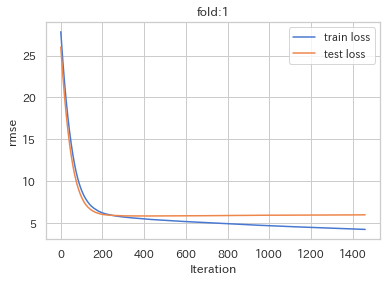

 - fold1_MAE : 5.814604


[I 2022-12-21 09:41:58,622] A new study created in memory with name: no-name-d81b78ec-7994-4a63-aebf-1781854008b6



★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1137]	Train's l1: 4.73008	Test's l1: 6.41543


[I 2022-12-21 09:42:14,101] Trial 0 finished with value: 6.415432166378939 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6.415432166378939.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1286]	Train's l1: 4.56158	Test's l1: 6.4373


[I 2022-12-21 09:42:35,370] Trial 1 finished with value: 6.437299552569509 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 6.415432166378939.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1188]	Train's l1: 4.66189	Test's l1: 6.41229


[I 2022-12-21 09:42:51,886] Trial 2 finished with value: 6.412291042999607 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.412291042999607.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1328]	Train's l1: 4.53968	Test's l1: 6.44008


[I 2022-12-21 09:43:15,144] Trial 3 finished with value: 6.440080837297418 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 6.412291042999607.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1116]	Train's l1: 4.70859	Test's l1: 6.47593


[I 2022-12-21 09:43:38,475] Trial 4 finished with value: 6.475930122813191 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.412291042999607.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1267]	Train's l1: 4.59218	Test's l1: 6.42057


[I 2022-12-21 09:43:57,526] Trial 5 finished with value: 6.420570447998741 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 6.412291042999607.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1217]	Train's l1: 4.67261	Test's l1: 6.4244


[I 2022-12-21 09:44:10,087] Trial 6 finished with value: 6.424400208822193 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 6.412291042999607.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1368]	Train's l1: 4.78179	Test's l1: 6.42012


[I 2022-12-21 09:44:23,311] Trial 7 finished with value: 6.420118201726342 and parameters: {'num_leaves': 21}. Best is trial 7 with value: 6.420118201726342.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:44:44,311] Trial 8 finished with value: 6.412602473427588 and parameters: {'num_leaves': 71}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:45:05,563] Trial 9 finished with value: 6.412602473427588 and parameters: {'num_leaves': 229}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:45:30,178] Trial 10 finished with value: 6.412602473427588 and parameters: {'num_leaves': 125}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:45:51,488] Trial 11 finished with value: 6.412602473427588 and parameters: {'num_leaves': 93}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:46:12,885] Trial 12 finished with value: 6.412602473427588 and parameters: {'num_leaves': 232}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1172]	Train's l1: 4.51527	Test's l1: 6.41676


[I 2022-12-21 09:46:32,903] Trial 13 finished with value: 6.416760904625132 and parameters: {'num_leaves': 42}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 09:46:37,967] Trial 14 finished with value: 6.486298625507966 and parameters: {'num_leaves': 6}. Best is trial 8 with value: 6.412602473427588.


Early stopping, best iteration is:
[1338]	Train's l1: 5.64024	Test's l1: 6.4863
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:46:59,123] Trial 15 finished with value: 6.412602473427588 and parameters: {'num_leaves': 150}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:47:20,476] Trial 16 finished with value: 6.412602473427588 and parameters: {'num_leaves': 175}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:47:41,868] Trial 17 finished with value: 6.412602473427588 and parameters: {'num_leaves': 68}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:48:03,348] Trial 18 finished with value: 6.412602473427588 and parameters: {'num_leaves': 241}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:48:24,621] Trial 19 finished with value: 6.412602473427588 and parameters: {'num_leaves': 206}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:48:49,532] Trial 20 finished with value: 6.412602473427588 and parameters: {'num_leaves': 98}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:49:10,665] Trial 21 finished with value: 6.412602473427588 and parameters: {'num_leaves': 183}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:49:31,999] Trial 22 finished with value: 6.412602473427588 and parameters: {'num_leaves': 123}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:49:53,109] Trial 23 finished with value: 6.412602473427588 and parameters: {'num_leaves': 67}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:50:14,436] Trial 24 finished with value: 6.412602473427588 and parameters: {'num_leaves': 161}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:50:35,715] Trial 25 finished with value: 6.412602473427588 and parameters: {'num_leaves': 138}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1199]	Train's l1: 4.44828	Test's l1: 6.4126


[I 2022-12-21 09:50:57,072] Trial 26 finished with value: 6.412602473427588 and parameters: {'num_leaves': 183}. Best is trial 8 with value: 6.412602473427588.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1973]	Train's l1: 5.32574	Test's l1: 6.82174


[I 2022-12-21 09:51:12,197] Trial 27 finished with value: 6.821742415561221 and parameters: {'bagging_fraction': 0.44061758808727947, 'bagging_freq': 7}. Best is trial 27 with value: 6.821742415561221.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1122]	Train's l1: 4.73364	Test's l1: 6.44589


[I 2022-12-21 09:51:30,487] Trial 28 finished with value: 6.445894399732384 and parameters: {'bagging_fraction': 0.9870059306622642, 'bagging_freq': 3}. Best is trial 28 with value: 6.445894399732384.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55766	Test's l1: 6.36399


[I 2022-12-21 09:51:51,273] Trial 29 finished with value: 6.36398680639132 and parameters: {'bagging_fraction': 0.9179041357852865, 'bagging_freq': 6}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1585]	Train's l1: 5.17937	Test's l1: 6.67307


[I 2022-12-21 09:52:10,237] Trial 30 finished with value: 6.673072086088701 and parameters: {'bagging_fraction': 0.5289143742824759, 'bagging_freq': 4}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1848]	Train's l1: 4.99039	Test's l1: 6.6071


[I 2022-12-21 09:52:28,222] Trial 31 finished with value: 6.607101984439402 and parameters: {'bagging_fraction': 0.5507839683200848, 'bagging_freq': 3}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2220]	Train's l1: 4.38115	Test's l1: 6.46154


[I 2022-12-21 09:52:51,514] Trial 32 finished with value: 6.461541019431855 and parameters: {'bagging_fraction': 0.6969779498125446, 'bagging_freq': 1}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1582]	Train's l1: 5.34553	Test's l1: 6.66079


[I 2022-12-21 09:53:05,991] Trial 33 finished with value: 6.660789682661598 and parameters: {'bagging_fraction': 0.4815458880367499, 'bagging_freq': 2}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2037]	Train's l1: 4.67785	Test's l1: 6.53976


[I 2022-12-21 09:53:27,340] Trial 34 finished with value: 6.5397588015241945 and parameters: {'bagging_fraction': 0.6214688320060611, 'bagging_freq': 5}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2096]	Train's l1: 4.39691	Test's l1: 6.47956


[I 2022-12-21 09:53:51,407] Trial 35 finished with value: 6.479559844626766 and parameters: {'bagging_fraction': 0.7214623902532602, 'bagging_freq': 4}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[914]	Train's l1: 5.00618	Test's l1: 6.4328


[I 2022-12-21 09:54:07,743] Trial 36 finished with value: 6.432795619089234 and parameters: {'bagging_fraction': 0.918885582857975, 'bagging_freq': 2}. Best is trial 29 with value: 6.36398680639132.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1452]	Train's l1: 4.57453	Test's l1: 6.37655


[I 2022-12-21 09:54:26,375] Trial 37 finished with value: 6.376552733152089 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 6.376552733152089.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.56249	Test's l1: 6.38531


[I 2022-12-21 09:54:46,312] Trial 38 finished with value: 6.385311230941565 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 6.376552733152089.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55233	Test's l1: 6.39308


[I 2022-12-21 09:55:07,908] Trial 39 finished with value: 6.393075791793037 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 6.376552733152089.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55159	Test's l1: 6.39004


[I 2022-12-21 09:55:30,035] Trial 40 finished with value: 6.390038274960527 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 6.376552733152089.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.56484	Test's l1: 6.36445


[I 2022-12-21 09:55:52,642] Trial 41 finished with value: 6.364454116637277 and parameters: {'feature_fraction': 0.552}. Best is trial 41 with value: 6.364454116637277.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1447]	Train's l1: 4.54548	Test's l1: 6.37748


[I 2022-12-21 09:56:13,141] Trial 42 finished with value: 6.37748099499505 and parameters: {'feature_fraction': 0.616}. Best is trial 41 with value: 6.364454116637277.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55645	Test's l1: 6.3691


[I 2022-12-21 09:56:33,552] Trial 43 finished with value: 6.369102335991593 and parameters: {'lambda_l1': 0.0001770592005284756, 'lambda_l2': 9.497564910217333e-07}. Best is trial 43 with value: 6.369102335991593.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.5534	Test's l1: 6.36668


[I 2022-12-21 09:56:53,840] Trial 44 finished with value: 6.3666815429575285 and parameters: {'lambda_l1': 0.04555279281611227, 'lambda_l2': 0.0012343873654130305}. Best is trial 44 with value: 6.3666815429575285.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55335	Test's l1: 6.36004


[I 2022-12-21 09:57:14,247] Trial 45 finished with value: 6.360041956802024 and parameters: {'lambda_l1': 0.012229294449587494, 'lambda_l2': 2.2118882665089406e-08}. Best is trial 45 with value: 6.360041956802024.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55682	Test's l1: 6.35779


[I 2022-12-21 09:57:35,159] Trial 46 finished with value: 6.357790113620337 and parameters: {'lambda_l1': 0.40690188345702866, 'lambda_l2': 0.2805223374468785}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.565	Test's l1: 6.37396


[I 2022-12-21 09:57:55,504] Trial 47 finished with value: 6.373962084034536 and parameters: {'lambda_l1': 0.016671190198314333, 'lambda_l2': 1.4419541514180107e-06}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55766	Test's l1: 6.36399


[I 2022-12-21 09:58:15,806] Trial 48 finished with value: 6.363986802488428 and parameters: {'lambda_l1': 6.4987856998144106e-06, 'lambda_l2': 8.080704480773572e-08}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.60937	Test's l1: 6.36997


[I 2022-12-21 09:58:35,948] Trial 49 finished with value: 6.3699657953831705 and parameters: {'lambda_l1': 7.238761989600636e-07, 'lambda_l2': 8.399647102257623}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.56016	Test's l1: 6.39147


[I 2022-12-21 09:58:56,508] Trial 50 finished with value: 6.391465515993087 and parameters: {'lambda_l1': 3.183562987660856e-05, 'lambda_l2': 1.521361213923712}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.54788	Test's l1: 6.36998


[I 2022-12-21 09:59:20,527] Trial 51 finished with value: 6.369975997668746 and parameters: {'lambda_l1': 0.03176520763321591, 'lambda_l2': 0.0816672790457813}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55766	Test's l1: 6.36399


[I 2022-12-21 09:59:41,089] Trial 52 finished with value: 6.363986804231828 and parameters: {'lambda_l1': 3.4625435203048118e-06, 'lambda_l2': 1.0803112308328684e-07}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.58177	Test's l1: 6.38115


[I 2022-12-21 10:00:01,322] Trial 53 finished with value: 6.381145260734685 and parameters: {'lambda_l1': 9.05588165180063, 'lambda_l2': 0.004404719708708696}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.57631	Test's l1: 6.37272


[I 2022-12-21 10:00:21,631] Trial 54 finished with value: 6.372719971479025 and parameters: {'lambda_l1': 9.407384783553702, 'lambda_l2': 3.0720430019532065e-05}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55766	Test's l1: 6.36399


[I 2022-12-21 10:00:42,708] Trial 55 finished with value: 6.363986780849776 and parameters: {'lambda_l1': 1.0994681444577287e-08, 'lambda_l2': 4.339782790501662e-05}. Best is trial 46 with value: 6.357790113620337.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55625	Test's l1: 6.35697


[I 2022-12-21 10:01:03,564] Trial 56 finished with value: 6.35697426028175 and parameters: {'lambda_l1': 0.1702202697671562, 'lambda_l2': 0.06570798765381357}. Best is trial 56 with value: 6.35697426028175.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.5557	Test's l1: 6.37134


[I 2022-12-21 10:01:24,999] Trial 57 finished with value: 6.371341169025397 and parameters: {'lambda_l1': 0.5257428943829431, 'lambda_l2': 0.06190395636877856}. Best is trial 56 with value: 6.35697426028175.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55738	Test's l1: 6.3707


[I 2022-12-21 10:01:46,096] Trial 58 finished with value: 6.370703239276022 and parameters: {'lambda_l1': 0.47533213629258764, 'lambda_l2': 0.13306439561704417}. Best is trial 56 with value: 6.35697426028175.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55653	Test's l1: 6.36323


[I 2022-12-21 10:02:06,927] Trial 59 finished with value: 6.363228178468929 and parameters: {'lambda_l1': 0.0016239601879859055, 'lambda_l2': 0.009612637276241004}. Best is trial 56 with value: 6.35697426028175.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.56179	Test's l1: 6.378


[I 2022-12-21 10:02:31,374] Trial 60 finished with value: 6.3779975828054605 and parameters: {'lambda_l1': 0.24917121710499465, 'lambda_l2': 1.0042332793714375}. Best is trial 56 with value: 6.35697426028175.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55462	Test's l1: 6.34801


[I 2022-12-21 10:02:52,153] Trial 61 finished with value: 6.348014324288587 and parameters: {'lambda_l1': 0.0012086751210397602, 'lambda_l2': 0.0003401539126598899}. Best is trial 61 with value: 6.348014324288587.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1446]	Train's l1: 4.55645	Test's l1: 6.3691


[I 2022-12-21 10:03:13,025] Trial 62 finished with value: 6.369101962492956 and parameters: {'lambda_l1': 0.0005413748905468261, 'lambda_l2': 0.00015696819992338317}. Best is trial 61 with value: 6.348014324288587.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55462	Test's l1: 6.34801


[I 2022-12-21 10:03:33,819] Trial 63 finished with value: 6.348014324288587 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.348014324288587.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55462	Test's l1: 6.34801


[I 2022-12-21 10:03:54,569] Trial 64 finished with value: 6.348014324288587 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.348014324288587.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55462	Test's l1: 6.34801


[I 2022-12-21 10:04:15,483] Trial 65 finished with value: 6.348014324288587 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.348014324288587.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55462	Test's l1: 6.34801


[I 2022-12-21 10:04:36,506] Trial 66 finished with value: 6.348014324288587 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.348014324288587.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1444]	Train's l1: 4.55462	Test's l1: 6.34801


[I 2022-12-21 10:04:57,446] Trial 67 finished with value: 6.348014324288587 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.348014324288587.


▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0012086751210397602, 'lambda_l2': 0.0003401539126598899, 'num_leaves': 31, 'feature_fraction': 0.6, 'bagging_fraction': 0.9179041357852865, 'bagging_freq': 6, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


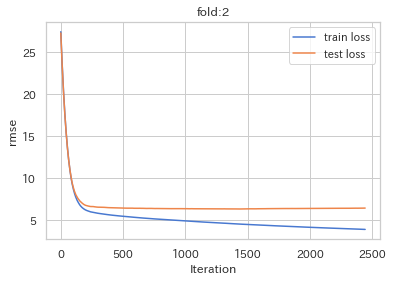

 - fold2_MAE : 6.348014


[I 2022-12-21 10:05:00,030] A new study created in memory with name: no-name-19a1979a-553a-4568-aed1-a002bf11b921



★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:05:10,426] Trial 0 finished with value: 6.535087487263653 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 6.535087487263653.


Early stopping, best iteration is:
[464]	Train's l1: 5.28311	Test's l1: 6.53509
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:05:21,375] Trial 1 finished with value: 6.536164833549414 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 6.535087487263653.


Early stopping, best iteration is:
[408]	Train's l1: 5.36735	Test's l1: 6.53616
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:05:30,351] Trial 2 finished with value: 6.534795543544741 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 6.534795543544741.


Early stopping, best iteration is:
[431]	Train's l1: 5.35023	Test's l1: 6.5348
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:05:45,949] Trial 3 finished with value: 6.599597058383935 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.534795543544741.


Early stopping, best iteration is:
[397]	Train's l1: 5.37936	Test's l1: 6.5996
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[443]	Train's l1: 5.30077	Test's l1: 6.54767


[I 2022-12-21 10:06:08,765] Trial 4 finished with value: 6.547673997272459 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 6.534795543544741.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:06:26,115] Trial 5 finished with value: 6.588508644201968 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 6.534795543544741.


Early stopping, best iteration is:
[423]	Train's l1: 5.33123	Test's l1: 6.58851
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:06:38,345] Trial 6 finished with value: 6.560192714441654 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 6.534795543544741.


Early stopping, best iteration is:
[436]	Train's l1: 5.32423	Test's l1: 6.56019
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:06:49,219] Trial 7 finished with value: 6.528875719647499 and parameters: {'num_leaves': 207}. Best is trial 7 with value: 6.528875719647499.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:07:00,106] Trial 8 finished with value: 6.528875719647499 and parameters: {'num_leaves': 174}. Best is trial 7 with value: 6.528875719647499.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:07:10,959] Trial 9 finished with value: 6.528875719647499 and parameters: {'num_leaves': 95}. Best is trial 7 with value: 6.528875719647499.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:07:21,887] Trial 10 finished with value: 6.528875719647499 and parameters: {'num_leaves': 111}. Best is trial 7 with value: 6.528875719647499.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:07:31,683] Trial 11 finished with value: 6.521257120780716 and parameters: {'num_leaves': 38}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[467]	Train's l1: 5.231	Test's l1: 6.52126
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:07:42,627] Trial 12 finished with value: 6.528875719647499 and parameters: {'num_leaves': 128}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:07:53,449] Trial 13 finished with value: 6.528875719647499 and parameters: {'num_leaves': 61}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:04,215] Trial 14 finished with value: 6.528875719647499 and parameters: {'num_leaves': 184}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:14,902] Trial 15 finished with value: 6.528875719647499 and parameters: {'num_leaves': 237}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:25,705] Trial 16 finished with value: 6.528875719647499 and parameters: {'num_leaves': 215}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:29,325] Trial 17 finished with value: 6.638574557851773 and parameters: {'num_leaves': 7}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[756]	Train's l1: 5.62471	Test's l1: 6.63857
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:31,417] Trial 18 finished with value: 6.79226108063664 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[1798]	Train's l1: 6.1927	Test's l1: 6.79226
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:41,849] Trial 19 finished with value: 6.533656551322681 and parameters: {'num_leaves': 48}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[426]	Train's l1: 5.24847	Test's l1: 6.53366
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:08:52,986] Trial 20 finished with value: 6.528875719647499 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:09:03,787] Trial 21 finished with value: 6.528875719647499 and parameters: {'num_leaves': 246}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:09:14,463] Trial 22 finished with value: 6.528875719647499 and parameters: {'num_leaves': 77}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:09:28,550] Trial 23 finished with value: 6.528875719647499 and parameters: {'num_leaves': 142}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:09:39,237] Trial 24 finished with value: 6.528875719647499 and parameters: {'num_leaves': 204}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:09:47,861] Trial 25 finished with value: 6.534245223876823 and parameters: {'num_leaves': 34}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[421]	Train's l1: 5.33519	Test's l1: 6.53425
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:09:58,505] Trial 26 finished with value: 6.528875719647499 and parameters: {'num_leaves': 146}. Best is trial 11 with value: 6.521257120780716.


Early stopping, best iteration is:
[463]	Train's l1: 5.18959	Test's l1: 6.52888
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1041]	Train's l1: 5.31629	Test's l1: 6.92338


[I 2022-12-21 10:10:09,410] Trial 27 finished with value: 6.923384462055993 and parameters: {'bagging_fraction': 0.5938190674496573, 'bagging_freq': 3}. Best is trial 27 with value: 6.923384462055993.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:10:17,711] Trial 28 finished with value: 7.260549447545985 and parameters: {'bagging_fraction': 0.4738863579564801, 'bagging_freq': 4}. Best is trial 27 with value: 6.923384462055993.


Early stopping, best iteration is:
[912]	Train's l1: 5.87578	Test's l1: 7.26055
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:10:27,887] Trial 29 finished with value: 6.801951560512359 and parameters: {'bagging_fraction': 0.7039569000289829, 'bagging_freq': 6}. Best is trial 29 with value: 6.801951560512359.


Early stopping, best iteration is:
[675]	Train's l1: 5.4061	Test's l1: 6.80195
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1237]	Train's l1: 5.35299	Test's l1: 7.10545


[I 2022-12-21 10:10:38,028] Trial 30 finished with value: 7.105447167057784 and parameters: {'bagging_fraction': 0.5285805287264159, 'bagging_freq': 1}. Best is trial 29 with value: 6.801951560512359.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:10:46,392] Trial 31 finished with value: 7.109596274810061 and parameters: {'bagging_fraction': 0.5531649051467082, 'bagging_freq': 1}. Best is trial 29 with value: 6.801951560512359.


Early stopping, best iteration is:
[792]	Train's l1: 5.66659	Test's l1: 7.1096
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:10:56,557] Trial 32 finished with value: 6.771895824521194 and parameters: {'bagging_fraction': 0.6659258663848324, 'bagging_freq': 2}. Best is trial 32 with value: 6.771895824521194.


Early stopping, best iteration is:
[738]	Train's l1: 5.40456	Test's l1: 6.7719
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1373]	Train's l1: 5.62747	Test's l1: 7.26019


[I 2022-12-21 10:11:06,478] Trial 33 finished with value: 7.260186452647211 and parameters: {'bagging_fraction': 0.44113703390090203, 'bagging_freq': 2}. Best is trial 32 with value: 6.771895824521194.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[823]	Train's l1: 5.24825	Test's l1: 6.75597


[I 2022-12-21 10:11:17,352] Trial 34 finished with value: 6.755967770480595 and parameters: {'bagging_fraction': 0.6974052619491494, 'bagging_freq': 7}. Best is trial 34 with value: 6.755967770480595.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:11:28,716] Trial 35 finished with value: 6.6721783052193855 and parameters: {'bagging_fraction': 0.8107036302339344, 'bagging_freq': 2}. Best is trial 35 with value: 6.6721783052193855.


Early stopping, best iteration is:
[638]	Train's l1: 5.2313	Test's l1: 6.67218
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:11:39,848] Trial 36 finished with value: 6.605187541632963 and parameters: {'bagging_fraction': 0.8860443936496339, 'bagging_freq': 3}. Best is trial 36 with value: 6.605187541632963.


Early stopping, best iteration is:
[534]	Train's l1: 5.26122	Test's l1: 6.60519
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:11:50,201] Trial 37 finished with value: 6.529490167707851 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 6.529490167707851.


Early stopping, best iteration is:
[466]	Train's l1: 5.21727	Test's l1: 6.52949
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:11:59,788] Trial 38 finished with value: 6.529743594767904 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 6.529490167707851.


Early stopping, best iteration is:
[418]	Train's l1: 5.3039	Test's l1: 6.52974
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:12:10,179] Trial 39 finished with value: 6.527118821125973 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 39 with value: 6.527118821125973.


Early stopping, best iteration is:
[417]	Train's l1: 5.29725	Test's l1: 6.52712
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:12:19,672] Trial 40 finished with value: 6.513725927234203 and parameters: {'lambda_l1': 0.11146991870083037, 'lambda_l2': 0.15611823822244883}. Best is trial 40 with value: 6.513725927234203.


Early stopping, best iteration is:
[431]	Train's l1: 5.28875	Test's l1: 6.51373
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:12:29,364] Trial 41 finished with value: 6.526512580257268 and parameters: {'lambda_l1': 0.0022052435035660157, 'lambda_l2': 6.166717720979162e-07}. Best is trial 40 with value: 6.513725927234203.


Early stopping, best iteration is:
[470]	Train's l1: 5.22559	Test's l1: 6.52651
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:12:38,835] Trial 42 finished with value: 6.522722536381075 and parameters: {'lambda_l1': 0.10077666924353604, 'lambda_l2': 0.034835364671202906}. Best is trial 40 with value: 6.513725927234203.


Early stopping, best iteration is:
[431]	Train's l1: 5.28618	Test's l1: 6.52272
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:12:51,707] Trial 43 finished with value: 6.527017564734535 and parameters: {'lambda_l1': 0.47077862840054024, 'lambda_l2': 4.225145726622846e-06}. Best is trial 40 with value: 6.513725927234203.


Early stopping, best iteration is:
[432]	Train's l1: 5.28666	Test's l1: 6.52702
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:01,348] Trial 44 finished with value: 6.526512479326677 and parameters: {'lambda_l1': 0.0034730328906963236, 'lambda_l2': 5.855188355441464e-07}. Best is trial 40 with value: 6.513725927234203.


Early stopping, best iteration is:
[470]	Train's l1: 5.2256	Test's l1: 6.52651
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:10,632] Trial 45 finished with value: 6.52452946473279 and parameters: {'lambda_l1': 4.381788006593524, 'lambda_l2': 0.10440003651605448}. Best is trial 40 with value: 6.513725927234203.


Early stopping, best iteration is:
[432]	Train's l1: 5.29319	Test's l1: 6.52453
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:20,123] Trial 46 finished with value: 6.511437412032068 and parameters: {'lambda_l1': 0.010679347415443442, 'lambda_l2': 0.00045802152736586997}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2866	Test's l1: 6.51144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:29,802] Trial 47 finished with value: 6.521257120639305 and parameters: {'lambda_l1': 3.1256400832112846e-08, 'lambda_l2': 1.0459700854079068e-07}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[467]	Train's l1: 5.231	Test's l1: 6.52126
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:39,490] Trial 48 finished with value: 6.530777698096731 and parameters: {'lambda_l1': 5.4312494826876715e-08, 'lambda_l2': 0.0012280492802121306}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2923	Test's l1: 6.53078
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:49,211] Trial 49 finished with value: 6.533585599152187 and parameters: {'lambda_l1': 0.0006869913178522554, 'lambda_l2': 0.5918496179000279}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[462]	Train's l1: 5.24171	Test's l1: 6.53359
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:13:58,665] Trial 50 finished with value: 6.527515541527574 and parameters: {'lambda_l1': 3.4746713478724485e-06, 'lambda_l2': 6.449247438424313e-05}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[427]	Train's l1: 5.29467	Test's l1: 6.52752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:14:08,244] Trial 51 finished with value: 6.51516307971447 and parameters: {'lambda_l1': 0.0315839606570984, 'lambda_l2': 0.0013642328415812215}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.29325	Test's l1: 6.51516
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:14:17,904] Trial 52 finished with value: 6.5274044234561455 and parameters: {'lambda_l1': 1.6966017799676067e-05, 'lambda_l2': 2.7270342271280437}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[479]	Train's l1: 5.23917	Test's l1: 6.5274
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:14:27,120] Trial 53 finished with value: 6.542952675173584 and parameters: {'lambda_l1': 6.656429370082197, 'lambda_l2': 0.0075292375636265615}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.31583	Test's l1: 6.54295
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:14:36,625] Trial 54 finished with value: 6.527515527418371 and parameters: {'lambda_l1': 2.898157494010345e-05, 'lambda_l2': 3.665008297468801e-05}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[427]	Train's l1: 5.29467	Test's l1: 6.52752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:14:45,893] Trial 55 finished with value: 6.527500562070176 and parameters: {'lambda_l1': 0.015045329376422355, 'lambda_l2': 5.180952109363864}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[441]	Train's l1: 5.31817	Test's l1: 6.5275
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:14:55,673] Trial 56 finished with value: 6.515325181369346 and parameters: {'lambda_l1': 0.33994298200926887, 'lambda_l2': 0.03240576321974091}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[452]	Train's l1: 5.25061	Test's l1: 6.51533
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:15:05,362] Trial 57 finished with value: 6.527515509729381 and parameters: {'lambda_l1': 7.356668675600212e-05, 'lambda_l2': 1.6079395991248007e-08}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[427]	Train's l1: 5.29467	Test's l1: 6.52752
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:15:15,261] Trial 58 finished with value: 6.515370743914613 and parameters: {'lambda_l1': 0.8207750368923211, 'lambda_l2': 0.0001512449697521972}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[463]	Train's l1: 5.23644	Test's l1: 6.51537
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:15:24,751] Trial 59 finished with value: 6.526741156524856 and parameters: {'lambda_l1': 0.01181979629536882, 'lambda_l2': 0.40716146532954484}. Best is trial 46 with value: 6.511437412032068.


Early stopping, best iteration is:
[424]	Train's l1: 5.3054	Test's l1: 6.52674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:15:34,315] Trial 60 finished with value: 6.511437412032068 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2866	Test's l1: 6.51144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:15:43,877] Trial 61 finished with value: 6.511437412032068 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2866	Test's l1: 6.51144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:15:53,410] Trial 62 finished with value: 6.511437412032068 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2866	Test's l1: 6.51144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:16:02,982] Trial 63 finished with value: 6.511437412032068 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2866	Test's l1: 6.51144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:16:15,986] Trial 64 finished with value: 6.511437412032068 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 6.511437412032068.


Early stopping, best iteration is:
[426]	Train's l1: 5.2866	Test's l1: 6.51144
▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.010679347415443442, 'lambda_l2': 0.00045802152736586997, 'num_leaves': 38, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


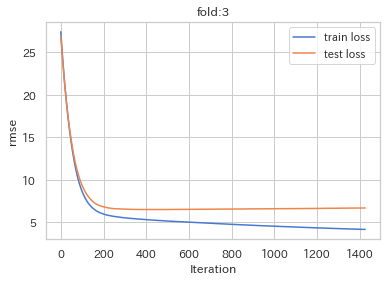

 - fold3_MAE : 6.511437


[I 2022-12-21 10:16:18,173] A new study created in memory with name: no-name-78a95526-0022-4c37-863c-a0fa6f4490ac



★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:16:29,840] Trial 0 finished with value: 5.87661970867844 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 5.87661970867844.


Early stopping, best iteration is:
[362]	Train's l1: 5.72106	Test's l1: 5.87662
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:16:45,600] Trial 1 finished with value: 5.924305743058259 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 5.87661970867844.


Early stopping, best iteration is:
[418]	Train's l1: 5.61809	Test's l1: 5.92431
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:16:58,826] Trial 2 finished with value: 5.878715058752501 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 5.87661970867844.


Early stopping, best iteration is:
[412]	Train's l1: 5.63472	Test's l1: 5.87872
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:17:12,543] Trial 3 finished with value: 5.921437663387408 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 5.87661970867844.


Early stopping, best iteration is:
[371]	Train's l1: 5.69833	Test's l1: 5.92144
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:17:21,043] Trial 4 finished with value: 5.8160205140652375 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 5.8160205140652375.


Early stopping, best iteration is:
[456]	Train's l1: 5.56991	Test's l1: 5.81602
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:17:31,539] Trial 5 finished with value: 5.863383470020965 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 5.8160205140652375.


Early stopping, best iteration is:
[384]	Train's l1: 5.67229	Test's l1: 5.86338
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:17:41,198] Trial 6 finished with value: 5.845975431200322 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 5.8160205140652375.


Early stopping, best iteration is:
[423]	Train's l1: 5.61055	Test's l1: 5.84598
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:17:51,671] Trial 7 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 69}. Best is trial 7 with value: 5.8207139993007715.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:18:02,117] Trial 8 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 108}. Best is trial 7 with value: 5.8207139993007715.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:18:12,713] Trial 9 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 89}. Best is trial 7 with value: 5.8207139993007715.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:18:19,288] Trial 10 finished with value: 5.813666067634216 and parameters: {'num_leaves': 20}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[491]	Train's l1: 5.66396	Test's l1: 5.81367
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:18:30,051] Trial 11 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 121}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:18:40,835] Trial 12 finished with value: 5.818147172741501 and parameters: {'num_leaves': 41}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[531]	Train's l1: 5.37446	Test's l1: 5.81815
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:18:51,414] Trial 13 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 119}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:01,868] Trial 14 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 51}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:06,156] Trial 15 finished with value: 5.8452372228514395 and parameters: {'num_leaves': 10}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[570]	Train's l1: 5.88608	Test's l1: 5.84524
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:16,814] Trial 16 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 195}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:31,119] Trial 17 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 195}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:36,783] Trial 18 finished with value: 5.825448533594137 and parameters: {'num_leaves': 16}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[498]	Train's l1: 5.74448	Test's l1: 5.82545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:46,977] Trial 19 finished with value: 5.824966672578991 and parameters: {'num_leaves': 43}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[425]	Train's l1: 5.53171	Test's l1: 5.82497
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:57,506] Trial 20 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:19:59,963] Trial 21 finished with value: 6.248277541702206 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[2265]	Train's l1: 6.47387	Test's l1: 6.24828
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:20:10,657] Trial 22 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 252}. Best is trial 10 with value: 5.813666067634216.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:20:20,601] Trial 23 finished with value: 5.808180788469458 and parameters: {'num_leaves': 42}. Best is trial 23 with value: 5.808180788469458.


Early stopping, best iteration is:
[425]	Train's l1: 5.5375	Test's l1: 5.80818
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:20:31,067] Trial 24 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 75}. Best is trial 23 with value: 5.808180788469458.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:20:41,538] Trial 25 finished with value: 5.8207139993007715 and parameters: {'num_leaves': 151}. Best is trial 23 with value: 5.808180788469458.


Early stopping, best iteration is:
[426]	Train's l1: 5.51295	Test's l1: 5.82071
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:20:49,315] Trial 26 finished with value: 5.827564742726956 and parameters: {'num_leaves': 26}. Best is trial 23 with value: 5.808180788469458.


Early stopping, best iteration is:
[527]	Train's l1: 5.52674	Test's l1: 5.82756
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:21:01,020] Trial 27 finished with value: 5.826693989927921 and parameters: {'bagging_fraction': 0.9503104929660228, 'bagging_freq': 3}. Best is trial 27 with value: 5.826693989927921.


Early stopping, best iteration is:
[505]	Train's l1: 5.45035	Test's l1: 5.82669
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2163]	Train's l1: 5.26393	Test's l1: 6.3502


[I 2022-12-21 10:21:15,258] Trial 28 finished with value: 6.3502022500197395 and parameters: {'bagging_fraction': 0.4862464371678411, 'bagging_freq': 3}. Best is trial 27 with value: 5.826693989927921.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:21:26,507] Trial 29 finished with value: 5.862640294262661 and parameters: {'bagging_fraction': 0.8435198723662151, 'bagging_freq': 2}. Best is trial 27 with value: 5.826693989927921.


Early stopping, best iteration is:
[561]	Train's l1: 5.52577	Test's l1: 5.86264
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:21:35,712] Trial 30 finished with value: 6.2895245435472775 and parameters: {'bagging_fraction': 0.529947029846154, 'bagging_freq': 4}. Best is trial 27 with value: 5.826693989927921.


Early stopping, best iteration is:
[926]	Train's l1: 5.88141	Test's l1: 6.28952
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:21:45,954] Trial 31 finished with value: 6.135379836744982 and parameters: {'bagging_fraction': 0.6607214356941427, 'bagging_freq': 6}. Best is trial 27 with value: 5.826693989927921.


Early stopping, best iteration is:
[757]	Train's l1: 5.66114	Test's l1: 6.13538
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[761]	Train's l1: 5.51678	Test's l1: 5.9903


[I 2022-12-21 10:21:57,198] Trial 32 finished with value: 5.990300650860074 and parameters: {'bagging_fraction': 0.7428909726596195, 'bagging_freq': 3}. Best is trial 27 with value: 5.826693989927921.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:22:08,826] Trial 33 finished with value: 5.891564554102066 and parameters: {'bagging_fraction': 0.8247567459563959, 'bagging_freq': 3}. Best is trial 27 with value: 5.826693989927921.


Early stopping, best iteration is:
[648]	Train's l1: 5.43985	Test's l1: 5.89156
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:22:19,520] Trial 34 finished with value: 5.89412246488676 and parameters: {'bagging_fraction': 0.7966457854928651, 'bagging_freq': 5}. Best is trial 27 with value: 5.826693989927921.


Early stopping, best iteration is:
[600]	Train's l1: 5.58331	Test's l1: 5.89412
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[964]	Train's l1: 5.40085	Test's l1: 6.09781


[I 2022-12-21 10:22:31,225] Trial 35 finished with value: 6.097809392118018 and parameters: {'bagging_fraction': 0.694491707632557, 'bagging_freq': 2}. Best is trial 27 with value: 5.826693989927921.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2634]	Train's l1: 5.34878	Test's l1: 6.56743


[I 2022-12-21 10:22:46,021] Trial 36 finished with value: 6.567429511317738 and parameters: {'bagging_fraction': 0.4227687444953706, 'bagging_freq': 3}. Best is trial 27 with value: 5.826693989927921.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:22:59,641] Trial 37 finished with value: 5.830805290996326 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 5.830805290996326.


Early stopping, best iteration is:
[383]	Train's l1: 5.60247	Test's l1: 5.83081
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:23:10,240] Trial 38 finished with value: 5.803443074107541 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 5.803443074107541.


Early stopping, best iteration is:
[493]	Train's l1: 5.41527	Test's l1: 5.80344
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:23:21,334] Trial 39 finished with value: 5.837922067758397 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 38 with value: 5.803443074107541.


Early stopping, best iteration is:
[459]	Train's l1: 5.4614	Test's l1: 5.83792
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:23:31,896] Trial 40 finished with value: 5.79881636963441 and parameters: {'lambda_l1': 2.3566569692737207e-06, 'lambda_l2': 0.0024385721387507678}. Best is trial 40 with value: 5.79881636963441.


Early stopping, best iteration is:
[491]	Train's l1: 5.42246	Test's l1: 5.79882
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:23:42,152] Trial 41 finished with value: 5.822859922563975 and parameters: {'lambda_l1': 8.513644093886987e-05, 'lambda_l2': 4.3122183723970275}. Best is trial 40 with value: 5.79881636963441.


Early stopping, best iteration is:
[491]	Train's l1: 5.47182	Test's l1: 5.82286
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:23:52,714] Trial 42 finished with value: 5.810500369674642 and parameters: {'lambda_l1': 0.0001234560398357265, 'lambda_l2': 0.0007589226980422738}. Best is trial 40 with value: 5.79881636963441.


Early stopping, best iteration is:
[491]	Train's l1: 5.42505	Test's l1: 5.8105
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:24:03,209] Trial 43 finished with value: 5.803443069817507 and parameters: {'lambda_l1': 6.846148129821438e-08, 'lambda_l2': 7.4979532468912236e-06}. Best is trial 40 with value: 5.79881636963441.


Early stopping, best iteration is:
[493]	Train's l1: 5.41527	Test's l1: 5.80344
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:24:13,296] Trial 44 finished with value: 5.805427192177551 and parameters: {'lambda_l1': 0.049565665105352125, 'lambda_l2': 6.526424459078704e-06}. Best is trial 40 with value: 5.79881636963441.


Early stopping, best iteration is:
[423]	Train's l1: 5.52918	Test's l1: 5.80543
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:24:23,382] Trial 45 finished with value: 5.797284168655943 and parameters: {'lambda_l1': 9.4778836019108e-08, 'lambda_l2': 0.004881391384544967}. Best is trial 45 with value: 5.797284168655943.


Early stopping, best iteration is:
[433]	Train's l1: 5.51011	Test's l1: 5.79728
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:24:33,755] Trial 46 finished with value: 5.7967444428976345 and parameters: {'lambda_l1': 0.0007103002406936395, 'lambda_l2': 0.1672452212812581}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[467]	Train's l1: 5.4679	Test's l1: 5.79674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:24:43,442] Trial 47 finished with value: 5.83097590352822 and parameters: {'lambda_l1': 1.2573568264608615e-08, 'lambda_l2': 9.778200169007635}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[433]	Train's l1: 5.61848	Test's l1: 5.83098
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:24:53,211] Trial 48 finished with value: 5.819707811318634 and parameters: {'lambda_l1': 0.029788093751212337, 'lambda_l2': 1.6402520679418924}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[401]	Train's l1: 5.59583	Test's l1: 5.81971
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:25:02,997] Trial 49 finished with value: 5.80434123289818 and parameters: {'lambda_l1': 5.893547501772133, 'lambda_l2': 3.158579159093593e-08}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[426]	Train's l1: 5.55929	Test's l1: 5.80434
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:25:12,970] Trial 50 finished with value: 5.809292754167583 and parameters: {'lambda_l1': 0.02721006225621171, 'lambda_l2': 0.10631828904699216}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[401]	Train's l1: 5.57316	Test's l1: 5.80929
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:25:22,964] Trial 51 finished with value: 5.802391990354827 and parameters: {'lambda_l1': 4.0990636755414335e-06, 'lambda_l2': 0.02493092592697746}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[401]	Train's l1: 5.56777	Test's l1: 5.80239
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:25:32,913] Trial 52 finished with value: 5.805862649849444 and parameters: {'lambda_l1': 0.0017685524976207288, 'lambda_l2': 0.05866028458989529}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[401]	Train's l1: 5.57762	Test's l1: 5.80586
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:25:43,748] Trial 53 finished with value: 5.803443041984172 and parameters: {'lambda_l1': 2.7382140822947378e-06, 'lambda_l2': 5.838828252885556e-05}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[493]	Train's l1: 5.41527	Test's l1: 5.80344
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:25:54,097] Trial 54 finished with value: 5.807310818093829 and parameters: {'lambda_l1': 0.001606598099239368, 'lambda_l2': 0.005171556303752993}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[454]	Train's l1: 5.48044	Test's l1: 5.80731
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[491]	Train's l1: 5.43656	Test's l1: 5.8099


[I 2022-12-21 10:26:04,469] Trial 55 finished with value: 5.809902973727347 and parameters: {'lambda_l1': 2.652730836033415, 'lambda_l2': 0.4261072192258531}. Best is trial 46 with value: 5.7967444428976345.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:26:18,307] Trial 56 finished with value: 5.803443006587199 and parameters: {'lambda_l1': 3.118966746661473e-07, 'lambda_l2': 0.00012027378316661464}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[493]	Train's l1: 5.41527	Test's l1: 5.80344
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:26:28,192] Trial 57 finished with value: 5.807306499238159 and parameters: {'lambda_l1': 1.9475128160770596e-05, 'lambda_l2': 0.012058751597117966}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[401]	Train's l1: 5.57174	Test's l1: 5.80731
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:26:38,839] Trial 58 finished with value: 5.810500959953426 and parameters: {'lambda_l1': 0.0026878957565598252, 'lambda_l2': 2.224055655167289e-08}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[491]	Train's l1: 5.42505	Test's l1: 5.8105
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:26:49,437] Trial 59 finished with value: 5.824070327947262 and parameters: {'lambda_l1': 0.5388061035786446, 'lambda_l2': 0.49223126247205407}. Best is trial 46 with value: 5.7967444428976345.


Early stopping, best iteration is:
[489]	Train's l1: 5.43461	Test's l1: 5.82407
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:26:59,862] Trial 60 finished with value: 5.7967444428976345 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 5.7967444428976345.


Early stopping, best iteration is:
[467]	Train's l1: 5.4679	Test's l1: 5.79674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:27:10,214] Trial 61 finished with value: 5.7967444428976345 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 5.7967444428976345.


Early stopping, best iteration is:
[467]	Train's l1: 5.4679	Test's l1: 5.79674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:27:20,610] Trial 62 finished with value: 5.7967444428976345 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 5.7967444428976345.


Early stopping, best iteration is:
[467]	Train's l1: 5.4679	Test's l1: 5.79674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:27:30,812] Trial 63 finished with value: 5.7967444428976345 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 5.7967444428976345.


Early stopping, best iteration is:
[467]	Train's l1: 5.4679	Test's l1: 5.79674
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:27:41,218] Trial 64 finished with value: 5.7967444428976345 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 5.7967444428976345.


Early stopping, best iteration is:
[467]	Train's l1: 5.4679	Test's l1: 5.79674
▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.0007103002406936395, 'lambda_l2': 0.1672452212812581, 'num_leaves': 42, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


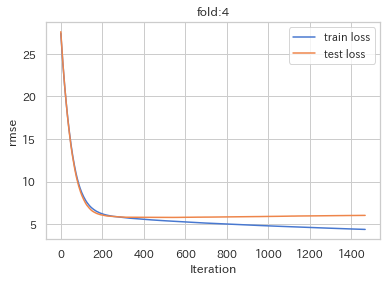

 - fold4_MAE : 5.796744


[I 2022-12-21 10:27:43,518] A new study created in memory with name: no-name-0d344826-c234-43c8-8d38-433b31ab6e35



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1422]	Train's l1: 4.39505	Test's l1: 6.58108


[I 2022-12-21 10:28:06,107] Trial 0 finished with value: 6.581080436797031 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 6.581080436797031.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1361]	Train's l1: 4.42293	Test's l1: 6.60766


[I 2022-12-21 10:28:29,497] Trial 1 finished with value: 6.607661021451568 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 6.581080436797031.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1921]	Train's l1: 4.13475	Test's l1: 6.52387


[I 2022-12-21 10:28:46,149] Trial 2 finished with value: 6.523868335269841 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 6.523868335269841.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1403]	Train's l1: 4.40046	Test's l1: 6.62014


[I 2022-12-21 10:29:12,467] Trial 3 finished with value: 6.620144726190115 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 6.523868335269841.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1580]	Train's l1: 4.30144	Test's l1: 6.54396


[I 2022-12-21 10:29:31,899] Trial 4 finished with value: 6.543955822242642 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 6.523868335269841.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1492]	Train's l1: 4.38012	Test's l1: 6.51197


[I 2022-12-21 10:29:51,747] Trial 5 finished with value: 6.5119660503346966 and parameters: {'feature_fraction': 0.5}. Best is trial 5 with value: 6.5119660503346966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2051]	Train's l1: 3.98056	Test's l1: 6.58351


[I 2022-12-21 10:30:17,699] Trial 6 finished with value: 6.583507330196741 and parameters: {'feature_fraction': 0.7}. Best is trial 5 with value: 6.5119660503346966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:30:39,569] Trial 7 finished with value: 6.545102977911453 and parameters: {'num_leaves': 167}. Best is trial 7 with value: 6.545102977911453.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:31:01,310] Trial 8 finished with value: 6.545102977911453 and parameters: {'num_leaves': 116}. Best is trial 7 with value: 6.545102977911453.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:31:23,048] Trial 9 finished with value: 6.545102977911453 and parameters: {'num_leaves': 224}. Best is trial 7 with value: 6.545102977911453.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:31:44,792] Trial 10 finished with value: 6.545102977911453 and parameters: {'num_leaves': 232}. Best is trial 7 with value: 6.545102977911453.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1550]	Train's l1: 4.36622	Test's l1: 6.512


[I 2022-12-21 10:32:01,442] Trial 11 finished with value: 6.512003538047966 and parameters: {'num_leaves': 30}. Best is trial 11 with value: 6.512003538047966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:32:23,322] Trial 12 finished with value: 6.545102977911453 and parameters: {'num_leaves': 100}. Best is trial 11 with value: 6.512003538047966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:32:45,230] Trial 13 finished with value: 6.545102977911453 and parameters: {'num_leaves': 164}. Best is trial 11 with value: 6.512003538047966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1546]	Train's l1: 4.12656	Test's l1: 6.53641


[I 2022-12-21 10:33:09,670] Trial 14 finished with value: 6.5364135099394245 and parameters: {'num_leaves': 44}. Best is trial 11 with value: 6.512003538047966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:33:31,136] Trial 15 finished with value: 6.545102977911453 and parameters: {'num_leaves': 79}. Best is trial 11 with value: 6.512003538047966.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:33:53,025] Trial 16 finished with value: 6.545102977911453 and parameters: {'num_leaves': 72}. Best is trial 11 with value: 6.512003538047966.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:34:01,435] Trial 17 finished with value: 6.477899766755263 and parameters: {'num_leaves': 9}. Best is trial 17 with value: 6.477899766755263.


Early stopping, best iteration is:
[2055]	Train's l1: 5.0424	Test's l1: 6.4779
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1480]	Train's l1: 4.6112	Test's l1: 6.51473


[I 2022-12-21 10:34:14,918] Trial 18 finished with value: 6.5147262954829515 and parameters: {'num_leaves': 23}. Best is trial 17 with value: 6.477899766755263.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:34:21,202] Trial 19 finished with value: 6.64829193699254 and parameters: {'num_leaves': 4}. Best is trial 17 with value: 6.477899766755263.


Early stopping, best iteration is:
[3598]	Train's l1: 5.40329	Test's l1: 6.64829
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2124]	Train's l1: 3.74302	Test's l1: 6.55367


[I 2022-12-21 10:34:47,158] Trial 20 finished with value: 6.553666758597849 and parameters: {'num_leaves': 43}. Best is trial 17 with value: 6.477899766755263.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2112]	Train's l1: 3.72187	Test's l1: 6.56705


[I 2022-12-21 10:35:13,647] Trial 21 finished with value: 6.567049357315304 and parameters: {'num_leaves': 50}. Best is trial 17 with value: 6.477899766755263.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:35:22,270] Trial 22 finished with value: 6.477899766755263 and parameters: {'num_leaves': 9}. Best is trial 17 with value: 6.477899766755263.


Early stopping, best iteration is:
[2055]	Train's l1: 5.0424	Test's l1: 6.4779
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:35:28,458] Trial 23 finished with value: 6.644446194881944 and parameters: {'num_leaves': 5}. Best is trial 17 with value: 6.477899766755263.


Early stopping, best iteration is:
[2625]	Train's l1: 5.37486	Test's l1: 6.64445
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:35:50,307] Trial 24 finished with value: 6.545102977911453 and parameters: {'num_leaves': 144}. Best is trial 17 with value: 6.477899766755263.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:36:12,326] Trial 25 finished with value: 6.545102977911453 and parameters: {'num_leaves': 76}. Best is trial 17 with value: 6.477899766755263.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 4.10543	Test's l1: 6.5451


[I 2022-12-21 10:36:37,398] Trial 26 finished with value: 6.545102977911453 and parameters: {'num_leaves': 198}. Best is trial 17 with value: 6.477899766755263.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2516]	Train's l1: 4.99873	Test's l1: 6.51934


[I 2022-12-21 10:36:48,008] Trial 27 finished with value: 6.519340351520238 and parameters: {'bagging_fraction': 0.8166885568397341, 'bagging_freq': 4}. Best is trial 27 with value: 6.519340351520238.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2576]	Train's l1: 4.97813	Test's l1: 6.49646


[I 2022-12-21 10:36:59,381] Trial 28 finished with value: 6.496461809764627 and parameters: {'bagging_fraction': 0.8305277797514459, 'bagging_freq': 2}. Best is trial 28 with value: 6.496461809764627.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3460]	Train's l1: 5.12405	Test's l1: 6.74183


[I 2022-12-21 10:37:11,605] Trial 29 finished with value: 6.741827495786223 and parameters: {'bagging_fraction': 0.5202853183895559, 'bagging_freq': 4}. Best is trial 28 with value: 6.496461809764627.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:37:21,097] Trial 30 finished with value: 6.47228983987723 and parameters: {'bagging_fraction': 0.9323162211347458, 'bagging_freq': 2}. Best is trial 30 with value: 6.47228983987723.


Early stopping, best iteration is:
[1974]	Train's l1: 5.08264	Test's l1: 6.47229
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:37:30,024] Trial 31 finished with value: 6.4393800975833475 and parameters: {'bagging_fraction': 0.9880503935470614, 'bagging_freq': 5}. Best is trial 31 with value: 6.4393800975833475.


Early stopping, best iteration is:
[1857]	Train's l1: 5.11422	Test's l1: 6.43938
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2710]	Train's l1: 5.00884	Test's l1: 6.48684


[I 2022-12-21 10:37:40,816] Trial 32 finished with value: 6.486839215732002 and parameters: {'bagging_fraction': 0.7452000722815815, 'bagging_freq': 5}. Best is trial 31 with value: 6.4393800975833475.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3096]	Train's l1: 5.34653	Test's l1: 6.95169


[I 2022-12-21 10:37:51,830] Trial 33 finished with value: 6.951694655677915 and parameters: {'bagging_fraction': 0.4697161098608821, 'bagging_freq': 4}. Best is trial 31 with value: 6.4393800975833475.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3906]	Train's l1: 4.89349	Test's l1: 6.62783


[I 2022-12-21 10:38:05,524] Trial 34 finished with value: 6.627826397870728 and parameters: {'bagging_fraction': 0.5862111441078752, 'bagging_freq': 2}. Best is trial 31 with value: 6.4393800975833475.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3120]	Train's l1: 5.1696	Test's l1: 6.72369


[I 2022-12-21 10:38:16,402] Trial 35 finished with value: 6.723693382949312 and parameters: {'bagging_fraction': 0.543302768226112, 'bagging_freq': 6}. Best is trial 31 with value: 6.4393800975833475.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3090]	Train's l1: 5.16584	Test's l1: 6.74831


[I 2022-12-21 10:38:27,621] Trial 36 finished with value: 6.748312765738719 and parameters: {'bagging_fraction': 0.5407093497284297, 'bagging_freq': 2}. Best is trial 31 with value: 6.4393800975833475.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:38:35,707] Trial 37 finished with value: 6.417268185490665 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 6.417268185490665.


Early stopping, best iteration is:
[1852]	Train's l1: 5.1201	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:38:45,374] Trial 38 finished with value: 6.43203549377859 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 6.417268185490665.


Early stopping, best iteration is:
[1920]	Train's l1: 5.08143	Test's l1: 6.43204
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:38:54,395] Trial 39 finished with value: 6.426107546102819 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 6.417268185490665.


Early stopping, best iteration is:
[1874]	Train's l1: 5.08774	Test's l1: 6.42611
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:03,008] Trial 40 finished with value: 6.427631789295211 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 6.417268185490665.


Early stopping, best iteration is:
[1873]	Train's l1: 5.10333	Test's l1: 6.42763
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:11,019] Trial 41 finished with value: 6.421343308499517 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 6.417268185490665.


Early stopping, best iteration is:
[1766]	Train's l1: 5.14337	Test's l1: 6.42134
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:20,239] Trial 42 finished with value: 6.433775002759602 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 6.417268185490665.


Early stopping, best iteration is:
[1889]	Train's l1: 5.09276	Test's l1: 6.43378
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:27,806] Trial 43 finished with value: 6.402282249039382 and parameters: {'lambda_l1': 0.2916361874352381, 'lambda_l2': 0.006973913402126767}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1745]	Train's l1: 5.15551	Test's l1: 6.40228
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:35,877] Trial 44 finished with value: 6.409902715817433 and parameters: {'lambda_l1': 5.286424770972535, 'lambda_l2': 4.886144783645744}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1847]	Train's l1: 5.12993	Test's l1: 6.4099
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:44,069] Trial 45 finished with value: 6.41726815696869 and parameters: {'lambda_l1': 0.00011064404906266113, 'lambda_l2': 6.622553757760639e-08}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1852]	Train's l1: 5.1201	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:39:55,522] Trial 46 finished with value: 6.417268172046413 and parameters: {'lambda_l1': 5.292397443226782e-05, 'lambda_l2': 1.3665958078953117e-08}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1852]	Train's l1: 5.1201	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:03,337] Trial 47 finished with value: 6.409933307712617 and parameters: {'lambda_l1': 1.1442709135208588e-06, 'lambda_l2': 0.01074038154742091}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1744]	Train's l1: 5.15832	Test's l1: 6.40993
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:11,549] Trial 48 finished with value: 6.41726815474331 and parameters: {'lambda_l1': 0.00011947906111801116, 'lambda_l2': 4.822522855479848e-08}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1852]	Train's l1: 5.1201	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:19,803] Trial 49 finished with value: 6.411553446090746 and parameters: {'lambda_l1': 0.3905376033347706, 'lambda_l2': 0.00011572042080285771}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1920]	Train's l1: 5.1004	Test's l1: 6.41155
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:27,881] Trial 50 finished with value: 6.417268178414581 and parameters: {'lambda_l1': 2.352963373239545e-08, 'lambda_l2': 6.6053485794288e-06}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1852]	Train's l1: 5.1201	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:36,039] Trial 51 finished with value: 6.416712728528347 and parameters: {'lambda_l1': 7.69747820143602e-08, 'lambda_l2': 0.17659863446122573}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1847]	Train's l1: 5.12054	Test's l1: 6.41671
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:44,168] Trial 52 finished with value: 6.417267521426082 and parameters: {'lambda_l1': 0.0002866489073857901, 'lambda_l2': 0.0005097034042902811}. Best is trial 43 with value: 6.402282249039382.


Early stopping, best iteration is:
[1852]	Train's l1: 5.12011	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:40:52,887] Trial 53 finished with value: 6.396290225335244 and parameters: {'lambda_l1': 0.022899042616309182, 'lambda_l2': 9.99287403631839}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[2090]	Train's l1: 5.06766	Test's l1: 6.39629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:01,013] Trial 54 finished with value: 6.423254503259644 and parameters: {'lambda_l1': 0.022198342904132327, 'lambda_l2': 6.221884297259422}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1851]	Train's l1: 5.13061	Test's l1: 6.42325
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:09,142] Trial 55 finished with value: 6.410675142388214 and parameters: {'lambda_l1': 0.01720588960153772, 'lambda_l2': 0.04067754410570644}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1880]	Train's l1: 5.11098	Test's l1: 6.41068
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:17,230] Trial 56 finished with value: 6.418255494082629 and parameters: {'lambda_l1': 0.032439277938946715, 'lambda_l2': 0.4048549739711996}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1851]	Train's l1: 5.11855	Test's l1: 6.41826
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:25,426] Trial 57 finished with value: 6.4099222184760105 and parameters: {'lambda_l1': 0.3386727813575377, 'lambda_l2': 0.0073285197254858575}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1880]	Train's l1: 5.11246	Test's l1: 6.40992
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:33,598] Trial 58 finished with value: 6.417267278187877 and parameters: {'lambda_l1': 0.0034310628684024176, 'lambda_l2': 4.300386211960059e-06}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1852]	Train's l1: 5.12011	Test's l1: 6.41727
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:41,927] Trial 59 finished with value: 6.416715741450741 and parameters: {'lambda_l1': 5.741903529873242, 'lambda_l2': 0.0007809827633027424}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1850]	Train's l1: 5.11685	Test's l1: 6.41672
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:50,064] Trial 60 finished with value: 6.412778588589321 and parameters: {'lambda_l1': 0.002517295878868328, 'lambda_l2': 0.4956856928071001}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1851]	Train's l1: 5.11776	Test's l1: 6.41278
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:41:58,231] Trial 61 finished with value: 6.407754909266553 and parameters: {'lambda_l1': 0.4183054422529525, 'lambda_l2': 4.807574759745996e-05}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1885]	Train's l1: 5.10194	Test's l1: 6.40775
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:42:06,372] Trial 62 finished with value: 6.417264982088138 and parameters: {'lambda_l1': 7.85738459269409e-06, 'lambda_l2': 0.0027700879724867154}. Best is trial 53 with value: 6.396290225335244.


Early stopping, best iteration is:
[1852]	Train's l1: 5.12011	Test's l1: 6.41726
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:42:15,182] Trial 63 finished with value: 6.396290225335244 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 6.396290225335244.


Early stopping, best iteration is:
[2090]	Train's l1: 5.06766	Test's l1: 6.39629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:42:23,896] Trial 64 finished with value: 6.396290225335244 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 6.396290225335244.


Early stopping, best iteration is:
[2090]	Train's l1: 5.06766	Test's l1: 6.39629
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:42:32,742] Trial 65 finished with value: 6.396290225335244 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 6.396290225335244.


Early stopping, best iteration is:
[2090]	Train's l1: 5.06766	Test's l1: 6.39629
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2090]	Train's l1: 5.06766	Test's l1: 6.39629


[I 2022-12-21 10:42:41,691] Trial 66 finished with value: 6.396290225335244 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.396290225335244.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:42:50,381] Trial 67 finished with value: 6.396290225335244 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 6.396290225335244.


Early stopping, best iteration is:
[2090]	Train's l1: 5.06766	Test's l1: 6.39629
▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.022899042616309182, 'lambda_l2': 9.99287403631839, 'num_leaves': 9, 'feature_fraction': 0.42, 'bagging_fraction': 0.9880503935470614, 'bagging_freq': 5, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


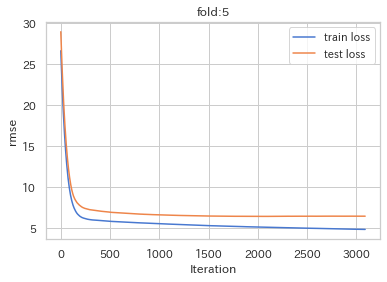

 - fold5_MAE : 6.396290
 - CV_MAE : 6.173418


In [59]:
kf_cv = list(kf.split(train_printer_main_x))
oof_valid_lgb_main_printer, lgb_models_main_printer = fit_lgb_oputuna(x=X_train_printer_main_feature, y=train_printer_main_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=params
                                     )

In [60]:
cd "/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model"

/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model


In [61]:
# oof_valid_lgb_main_printer, lgb_models_main_printer 

#oof_valid_lgb_main_printer, lgb_models_main_printer
file_path = f'oof_valid_lgb_main_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_main_printer, f)

file_path = f'lgb_models_main_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_main_printer, f)


[I 2022-12-21 10:47:41,137] A new study created in memory with name: no-name-1dba4f12-7aef-4809-b925-fae44af7a005


data_labels: ['Unnamed_ 0', '製品仕様コード', '受注数量', '流用受注番号', '頁数', '展開寸法幅', '展開寸法長さ', '号機名', '数量1', '数量項目名1', '数量2', '数量項目名2', '数量3', '数量項目名3', '合計数量', '予備数量', '仕上数量', '連量', '加工数量', '台数', '通し実数', '刷了数', '印刷予備数', '加工予備数', 'カテゴリ名1', 'カテゴリ名2', '表色数', '裏色数', '刷本寸法長さ', '刷本寸法幅', '部品区分名', '作業時間_数式予測値', '受注日_月', '受注日_週', '受注日_曜日', '作業日_月', '作業日_週', '作業日_曜日', '展開面積', '数量*面積', '数量*面積_log', '刷本面積', '数量*刷本面積', '数量*刷本面積_log', '工期', '通し実数/受注日_月', '数量刷本面積/受注日_月', '表色数*log_受注日_月_', '数量3*製品仕様コード', '号機名**2*sqrt_数量3_', 'sqrt_数量3_*流用受注番号', '号機名**2*log_受注日_週_', '号機名**2*Abs_カテゴリ名2_', 'sqrt_加工予備数_*裏色数**3', '号機名**2*sqrt_製品仕様コード_', '台数*号機名**3', '数量3**2*裏色数', '数量項目名3*裏色数', '裏色数**2*log_受注日_月_', 'sqrt_加工予備数_*数量3**3', 'sqrt_印刷予備数_*log_受注日_週_', '数量項目名2*表色数', '展開寸法長さ**3*工期', '刷本寸法幅**2*号機名**3', '展開寸法長さ**3*展開面積**2', '流用受注番号*Abs_カテゴリ名2_', 'sqrt_表色数_*log_作業日_週_', 'sqrt_数量面積_log_*裏色数**3', 'sqrt_刷本寸法長さ_*Abs_カテゴリ名1_', '作業時間_数式予測値**3*log_受注日_月_', '作業日_曜日*印刷予備数', 'sqrt_数量2_*表色数', 'カテゴリ名1**3*表色数', '裏色数**3*通し実数**2', '表色数*製品仕様コード**

[I 2022-12-21 10:47:55,428] Trial 0 finished with value: 14.586942046136551 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 14.586942046136551.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[908]	Train's l1: 11.7254	Test's l1: 14.5083


[I 2022-12-21 10:48:06,421] Trial 1 finished with value: 14.508274417523445 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 14.508274417523445.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:48:24,715] Trial 2 finished with value: 14.61692178326329 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 14.508274417523445.


Early stopping, best iteration is:
[823]	Train's l1: 11.7936	Test's l1: 14.6169
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:48:43,734] Trial 3 finished with value: 14.646000701108283 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 14.508274417523445.


Early stopping, best iteration is:
[756]	Train's l1: 12.0013	Test's l1: 14.646
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[861]	Train's l1: 11.7242	Test's l1: 14.5968


[I 2022-12-21 10:49:00,571] Trial 4 finished with value: 14.596838316747512 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 14.508274417523445.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[843]	Train's l1: 11.7534	Test's l1: 14.5995


[I 2022-12-21 10:49:17,483] Trial 5 finished with value: 14.599533385662012 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 14.508274417523445.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[899]	Train's l1: 11.7017	Test's l1: 14.5703


[I 2022-12-21 10:49:30,111] Trial 6 finished with value: 14.57028533301665 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 14.508274417523445.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:49:43,973] Trial 7 finished with value: 14.585308770157194 and parameters: {'num_leaves': 199}. Best is trial 7 with value: 14.585308770157194.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:50:00,845] Trial 8 finished with value: 14.585308770157194 and parameters: {'num_leaves': 80}. Best is trial 7 with value: 14.585308770157194.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:50:13,733] Trial 9 finished with value: 14.585308770157194 and parameters: {'num_leaves': 61}. Best is trial 7 with value: 14.585308770157194.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1025]	Train's l1: 11.303	Test's l1: 14.5183


[I 2022-12-21 10:50:25,687] Trial 10 finished with value: 14.518349845995173 and parameters: {'num_leaves': 32}. Best is trial 10 with value: 14.518349845995173.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[990]	Train's l1: 11.6723	Test's l1: 14.5211


[I 2022-12-21 10:50:36,568] Trial 11 finished with value: 14.521087759389843 and parameters: {'num_leaves': 29}. Best is trial 10 with value: 14.518349845995173.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:50:49,479] Trial 12 finished with value: 14.585308770157194 and parameters: {'num_leaves': 134}. Best is trial 10 with value: 14.518349845995173.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:51:02,371] Trial 13 finished with value: 14.585308770157194 and parameters: {'num_leaves': 165}. Best is trial 10 with value: 14.518349845995173.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[955]	Train's l1: 11.6833	Test's l1: 14.5166


[I 2022-12-21 10:51:13,375] Trial 14 finished with value: 14.516554439123055 and parameters: {'num_leaves': 30}. Best is trial 14 with value: 14.516554439123055.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:51:26,138] Trial 15 finished with value: 14.585308770157194 and parameters: {'num_leaves': 74}. Best is trial 14 with value: 14.516554439123055.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:51:39,003] Trial 16 finished with value: 14.585308770157194 and parameters: {'num_leaves': 215}. Best is trial 14 with value: 14.516554439123055.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:51:51,965] Trial 17 finished with value: 14.585308770157194 and parameters: {'num_leaves': 109}. Best is trial 14 with value: 14.516554439123055.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 13.7012	Test's l1: 14.798


[I 2022-12-21 10:51:58,459] Trial 18 finished with value: 14.79796690090245 and parameters: {'num_leaves': 4}. Best is trial 14 with value: 14.516554439123055.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2218	Test's l1: 14.5081


[I 2022-12-21 10:52:10,692] Trial 19 finished with value: 14.508098007529775 and parameters: {'num_leaves': 33}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:52:17,065] Trial 20 finished with value: 14.612710999524792 and parameters: {'num_leaves': 11}. Best is trial 19 with value: 14.508098007529775.


Early stopping, best iteration is:
[1349]	Train's l1: 13.3206	Test's l1: 14.6127
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:52:29,674] Trial 21 finished with value: 14.585308770157194 and parameters: {'num_leaves': 54}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:52:42,571] Trial 22 finished with value: 14.585308770157194 and parameters: {'num_leaves': 104}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:52:55,530] Trial 23 finished with value: 14.585308770157194 and parameters: {'num_leaves': 146}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:53:08,276] Trial 24 finished with value: 14.585308770157194 and parameters: {'num_leaves': 249}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[735]	Train's l1: 11.7929	Test's l1: 14.5325


[I 2022-12-21 10:53:19,751] Trial 25 finished with value: 14.532510155928438 and parameters: {'num_leaves': 39}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[790]	Train's l1: 11.2959	Test's l1: 14.5853


[I 2022-12-21 10:53:35,761] Trial 26 finished with value: 14.585308770157194 and parameters: {'num_leaves': 94}. Best is trial 19 with value: 14.508098007529775.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1504]	Train's l1: 11.6917	Test's l1: 14.788


[I 2022-12-21 10:53:47,637] Trial 27 finished with value: 14.787992673685492 and parameters: {'bagging_fraction': 0.5363919431021557, 'bagging_freq': 2}. Best is trial 27 with value: 14.787992673685492.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1363]	Train's l1: 10.6995	Test's l1: 14.7502


[I 2022-12-21 10:54:02,130] Trial 28 finished with value: 14.750234987194954 and parameters: {'bagging_fraction': 0.7593571023565606, 'bagging_freq': 6}. Best is trial 28 with value: 14.750234987194954.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[896]	Train's l1: 12.1283	Test's l1: 14.731


[I 2022-12-21 10:54:13,233] Trial 29 finished with value: 14.731048075192158 and parameters: {'bagging_fraction': 0.7140079095334759, 'bagging_freq': 6}. Best is trial 29 with value: 14.731048075192158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1078]	Train's l1: 11.3049	Test's l1: 14.7089


[I 2022-12-21 10:54:26,303] Trial 30 finished with value: 14.708880069556232 and parameters: {'bagging_fraction': 0.8161917827589393, 'bagging_freq': 4}. Best is trial 30 with value: 14.708880069556232.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:54:37,868] Trial 31 finished with value: 14.613437790033307 and parameters: {'bagging_fraction': 0.9396416739355719, 'bagging_freq': 3}. Best is trial 31 with value: 14.613437790033307.


Early stopping, best iteration is:
[716]	Train's l1: 12.3069	Test's l1: 14.6134
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1386]	Train's l1: 12.0337	Test's l1: 14.8053


[I 2022-12-21 10:54:48,456] Trial 32 finished with value: 14.80526316083737 and parameters: {'bagging_fraction': 0.5143519113854769, 'bagging_freq': 7}. Best is trial 31 with value: 14.613437790033307.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1373]	Train's l1: 11.8798	Test's l1: 14.8034


[I 2022-12-21 10:54:58,857] Trial 33 finished with value: 14.803436498657163 and parameters: {'bagging_fraction': 0.5489495787570378, 'bagging_freq': 1}. Best is trial 31 with value: 14.613437790033307.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1463]	Train's l1: 12.4833	Test's l1: 14.7619


[I 2022-12-21 10:55:08,537] Trial 34 finished with value: 14.761948654274551 and parameters: {'bagging_fraction': 0.4369505178483697, 'bagging_freq': 2}. Best is trial 31 with value: 14.613437790033307.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[966]	Train's l1: 11.5969	Test's l1: 14.7509


[I 2022-12-21 10:55:20,952] Trial 35 finished with value: 14.750864013165145 and parameters: {'bagging_fraction': 0.828872842332028, 'bagging_freq': 7}. Best is trial 31 with value: 14.613437790033307.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 10:55:32,630] Trial 36 finished with value: 14.708989306221556 and parameters: {'bagging_fraction': 0.8951221823809725, 'bagging_freq': 3}. Best is trial 31 with value: 14.613437790033307.


Early stopping, best iteration is:
[768]	Train's l1: 12.163	Test's l1: 14.709
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1016]	Train's l1: 11.1966	Test's l1: 14.5409


[I 2022-12-21 10:55:45,670] Trial 37 finished with value: 14.540935603294011 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 14.540935603294011.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[910]	Train's l1: 11.5268	Test's l1: 14.5448


[I 2022-12-21 10:55:58,505] Trial 38 finished with value: 14.544779530654072 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 14.540935603294011.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1035]	Train's l1: 11.1842	Test's l1: 14.5702


[I 2022-12-21 10:56:11,103] Trial 39 finished with value: 14.570192784683034 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 14.540935603294011.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2218	Test's l1: 14.5081


[I 2022-12-21 10:56:23,422] Trial 40 finished with value: 14.508097846059291 and parameters: {'lambda_l1': 2.7428848734219215e-08, 'lambda_l2': 8.094459042397508e-05}. Best is trial 40 with value: 14.508097846059291.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1043]	Train's l1: 11.1611	Test's l1: 14.5043


[I 2022-12-21 10:56:35,677] Trial 41 finished with value: 14.504283681286822 and parameters: {'lambda_l1': 0.0016845799092778677, 'lambda_l2': 1.6456647593216387e-06}. Best is trial 41 with value: 14.504283681286822.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1074]	Train's l1: 11.0721	Test's l1: 14.5287


[I 2022-12-21 10:56:51,727] Trial 42 finished with value: 14.528684698673796 and parameters: {'lambda_l1': 0.8685458145197752, 'lambda_l2': 0.44357588888491584}. Best is trial 41 with value: 14.504283681286822.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[996]	Train's l1: 11.3504	Test's l1: 14.5381


[I 2022-12-21 10:57:03,997] Trial 43 finished with value: 14.53813944799491 and parameters: {'lambda_l1': 0.3766286347950472, 'lambda_l2': 3.543020202402067}. Best is trial 41 with value: 14.504283681286822.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[946]	Train's l1: 11.4744	Test's l1: 14.5446


[I 2022-12-21 10:57:15,671] Trial 44 finished with value: 14.544597262556973 and parameters: {'lambda_l1': 1.9249180654307382e-08, 'lambda_l2': 0.011014523850097479}. Best is trial 41 with value: 14.504283681286822.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[966]	Train's l1: 11.4365	Test's l1: 14.5337


[I 2022-12-21 10:57:27,552] Trial 45 finished with value: 14.533681134121068 and parameters: {'lambda_l1': 0.06349635737245593, 'lambda_l2': 3.0195077373040284}. Best is trial 41 with value: 14.504283681286822.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[918]	Train's l1: 11.5454	Test's l1: 14.5028


[I 2022-12-21 10:57:39,115] Trial 46 finished with value: 14.502757310725267 and parameters: {'lambda_l1': 0.006663739855246278, 'lambda_l2': 0.05801907083089802}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[989]	Train's l1: 11.3278	Test's l1: 14.5333


[I 2022-12-21 10:57:51,138] Trial 47 finished with value: 14.533336875532248 and parameters: {'lambda_l1': 3.967388958419124e-08, 'lambda_l2': 0.001285544051883927}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2218	Test's l1: 14.5081


[I 2022-12-21 10:58:03,305] Trial 48 finished with value: 14.508097405543523 and parameters: {'lambda_l1': 0.00042596559124428724, 'lambda_l2': 0.00021342726322605535}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[991]	Train's l1: 11.3372	Test's l1: 14.592


[I 2022-12-21 10:58:15,165] Trial 49 finished with value: 14.592043958757355 and parameters: {'lambda_l1': 0.34074728694079687, 'lambda_l2': 0.00018956708793115245}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2218	Test's l1: 14.5081


[I 2022-12-21 10:58:27,197] Trial 50 finished with value: 14.508098004562076 and parameters: {'lambda_l1': 6.704872374450408e-06, 'lambda_l2': 5.009053872713067e-08}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1043]	Train's l1: 11.1611	Test's l1: 14.5043


[I 2022-12-21 10:58:39,395] Trial 51 finished with value: 14.504283776440966 and parameters: {'lambda_l1': 0.0014641916997566507, 'lambda_l2': 3.218628028009453e-07}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2265	Test's l1: 14.5163


[I 2022-12-21 10:58:51,523] Trial 52 finished with value: 14.516336588947018 and parameters: {'lambda_l1': 0.005675145608031991, 'lambda_l2': 1.0899402461912753e-05}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[944]	Train's l1: 11.4502	Test's l1: 14.5748


[I 2022-12-21 10:59:03,086] Trial 53 finished with value: 14.574820413180255 and parameters: {'lambda_l1': 7.12522203603239e-06, 'lambda_l2': 0.03454153148355803}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2218	Test's l1: 14.5081


[I 2022-12-21 10:59:15,049] Trial 54 finished with value: 14.508097993409002 and parameters: {'lambda_l1': 2.0969412825448948e-05, 'lambda_l2': 2.9515597815929463e-06}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1022]	Train's l1: 11.2265	Test's l1: 14.5163


[I 2022-12-21 10:59:26,939] Trial 55 finished with value: 14.516336238372965 and parameters: {'lambda_l1': 0.006438592816254429, 'lambda_l2': 2.2374367551158052e-08}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[809]	Train's l1: 11.9089	Test's l1: 14.5061


[I 2022-12-21 10:59:37,789] Trial 56 finished with value: 14.50612361513804 and parameters: {'lambda_l1': 9.953797898147171e-05, 'lambda_l2': 0.04271375327590259}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1073]	Train's l1: 11.096	Test's l1: 14.5476


[I 2022-12-21 10:59:50,226] Trial 57 finished with value: 14.547617693912867 and parameters: {'lambda_l1': 9.230282120284325, 'lambda_l2': 2.1472846830161747e-06}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1055]	Train's l1: 11.1402	Test's l1: 14.5595


[I 2022-12-21 11:00:02,418] Trial 58 finished with value: 14.559503427838619 and parameters: {'lambda_l1': 1.012665188335607e-06, 'lambda_l2': 0.0034886416471168113}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[913]	Train's l1: 11.5653	Test's l1: 14.558


[I 2022-12-21 11:00:17,358] Trial 59 finished with value: 14.558036060448146 and parameters: {'lambda_l1': 0.02702608999546131, 'lambda_l2': 0.15914244309826098}. Best is trial 46 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[918]	Train's l1: 11.5454	Test's l1: 14.5028


[I 2022-12-21 11:00:28,790] Trial 60 finished with value: 14.502757310725267 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[918]	Train's l1: 11.5454	Test's l1: 14.5028


[I 2022-12-21 11:00:40,273] Trial 61 finished with value: 14.502757310725267 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[918]	Train's l1: 11.5454	Test's l1: 14.5028


[I 2022-12-21 11:00:51,887] Trial 62 finished with value: 14.502757310725267 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[918]	Train's l1: 11.5454	Test's l1: 14.5028


[I 2022-12-21 11:01:03,345] Trial 63 finished with value: 14.502757310725267 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 14.502757310725267.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[918]	Train's l1: 11.5454	Test's l1: 14.5028


[I 2022-12-21 11:01:14,880] Trial 64 finished with value: 14.502757310725267 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 14.502757310725267.


▼▼▼▼▼　　　　　Fold 1　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.006663739855246278, 'lambda_l2': 0.05801907083089802, 'num_leaves': 33, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


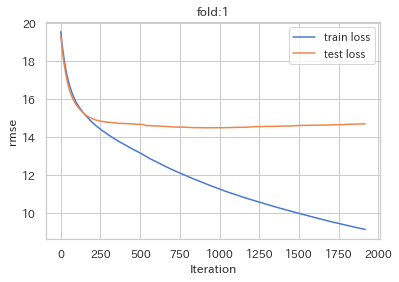

 - fold1_MAE : 14.502757


[I 2022-12-21 11:01:16,323] A new study created in memory with name: no-name-bab72db1-814f-4e02-8df4-dc5bffcf0c73



★★★★★　　　　　Fold 2　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:01:30,453] Trial 0 finished with value: 15.943286327598074 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 15.943286327598074.


Early stopping, best iteration is:
[527]	Train's l1: 12.5719	Test's l1: 15.9433
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:01:39,811] Trial 1 finished with value: 15.886738494210045 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 15.886738494210045.


Early stopping, best iteration is:
[637]	Train's l1: 12.2953	Test's l1: 15.8867
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:01:51,464] Trial 2 finished with value: 15.972958115495942 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 15.886738494210045.


Early stopping, best iteration is:
[525]	Train's l1: 12.6331	Test's l1: 15.973
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:02:06,383] Trial 3 finished with value: 15.968985050200097 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 15.886738494210045.


Early stopping, best iteration is:
[484]	Train's l1: 12.7423	Test's l1: 15.969
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:02:20,046] Trial 4 finished with value: 15.861300763923651 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 15.861300763923651.


Early stopping, best iteration is:
[615]	Train's l1: 12.2114	Test's l1: 15.8613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:02:36,501] Trial 5 finished with value: 16.01347361328919 and parameters: {'feature_fraction': 1.0}. Best is trial 4 with value: 15.861300763923651.


Early stopping, best iteration is:
[495]	Train's l1: 12.6702	Test's l1: 16.0135
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:02:47,307] Trial 6 finished with value: 15.940165854902869 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 15.861300763923651.


Early stopping, best iteration is:
[595]	Train's l1: 12.4138	Test's l1: 15.9402
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815


[I 2022-12-21 11:03:03,444] Trial 7 finished with value: 15.981462866909409 and parameters: {'num_leaves': 212}. Best is trial 7 with value: 15.981462866909409.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:03:19,336] Trial 8 finished with value: 15.981462866909409 and parameters: {'num_leaves': 95}. Best is trial 7 with value: 15.981462866909409.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815


[I 2022-12-21 11:03:35,522] Trial 9 finished with value: 15.981462866909409 and parameters: {'num_leaves': 211}. Best is trial 7 with value: 15.981462866909409.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:03:54,763] Trial 10 finished with value: 15.981462866909409 and parameters: {'num_leaves': 137}. Best is trial 7 with value: 15.981462866909409.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:04:09,949] Trial 11 finished with value: 15.95207102342375 and parameters: {'num_leaves': 48}. Best is trial 11 with value: 15.95207102342375.


Early stopping, best iteration is:
[469]	Train's l1: 12.2091	Test's l1: 15.9521
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:04:26,115] Trial 12 finished with value: 15.981462866909409 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 15.95207102342375.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815


[I 2022-12-21 11:04:41,918] Trial 13 finished with value: 15.981462866909409 and parameters: {'num_leaves': 164}. Best is trial 11 with value: 15.95207102342375.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:04:57,891] Trial 14 finished with value: 15.981462866909409 and parameters: {'num_leaves': 245}. Best is trial 11 with value: 15.95207102342375.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815


[I 2022-12-21 11:05:13,881] Trial 15 finished with value: 15.981462866909409 and parameters: {'num_leaves': 85}. Best is trial 11 with value: 15.95207102342375.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:05:29,804] Trial 16 finished with value: 15.981462866909409 and parameters: {'num_leaves': 173}. Best is trial 11 with value: 15.95207102342375.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 13.3548	Test's l1: 16.136


[I 2022-12-21 11:05:38,621] Trial 17 finished with value: 16.136017451866795 and parameters: {'num_leaves': 4}. Best is trial 11 with value: 15.95207102342375.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 12.6344	Test's l1: 16.1624


[I 2022-12-21 11:05:48,866] Trial 18 finished with value: 16.16238389025433 and parameters: {'num_leaves': 5}. Best is trial 11 with value: 15.95207102342375.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815


[I 2022-12-21 11:06:04,741] Trial 19 finished with value: 15.981462866909409 and parameters: {'num_leaves': 67}. Best is trial 11 with value: 15.95207102342375.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:06:20,414] Trial 20 finished with value: 15.926354211599318 and parameters: {'num_leaves': 46}. Best is trial 20 with value: 15.926354211599318.


Early stopping, best iteration is:
[527]	Train's l1: 11.9251	Test's l1: 15.9264
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:06:34,764] Trial 21 finished with value: 15.895790260512506 and parameters: {'num_leaves': 38}. Best is trial 21 with value: 15.895790260512506.


Early stopping, best iteration is:
[525]	Train's l1: 12.2102	Test's l1: 15.8958
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:06:50,176] Trial 22 finished with value: 15.884858415135787 and parameters: {'num_leaves': 41}. Best is trial 22 with value: 15.884858415135787.


Early stopping, best iteration is:
[565]	Train's l1: 11.8812	Test's l1: 15.8849
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:07:06,548] Trial 23 finished with value: 15.878135372980761 and parameters: {'num_leaves': 33}. Best is trial 23 with value: 15.878135372980761.


Early stopping, best iteration is:
[506]	Train's l1: 12.5695	Test's l1: 15.8781
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:07:22,523] Trial 24 finished with value: 15.981462866909409 and parameters: {'num_leaves': 104}. Best is trial 23 with value: 15.878135372980761.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:07:33,693] Trial 25 finished with value: 15.961570535453856 and parameters: {'num_leaves': 26}. Best is trial 23 with value: 15.878135372980761.


Early stopping, best iteration is:
[516]	Train's l1: 12.9658	Test's l1: 15.9616
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:07:49,558] Trial 26 finished with value: 15.981462866909409 and parameters: {'num_leaves': 122}. Best is trial 23 with value: 15.878135372980761.


Early stopping, best iteration is:
[525]	Train's l1: 11.9366	Test's l1: 15.9815
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:07:59,890] Trial 27 finished with value: 16.056504683718245 and parameters: {'bagging_fraction': 0.6992357027919001, 'bagging_freq': 4}. Best is trial 27 with value: 16.056504683718245.


Early stopping, best iteration is:
[307]	Train's l1: 14.0033	Test's l1: 16.0565
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:08:08,436] Trial 28 finished with value: 16.13454567320162 and parameters: {'bagging_fraction': 0.5156938196633427, 'bagging_freq': 7}. Best is trial 27 with value: 16.056504683718245.


Early stopping, best iteration is:
[404]	Train's l1: 14.1591	Test's l1: 16.1345
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:08:18,635] Trial 29 finished with value: 16.040630127741103 and parameters: {'bagging_fraction': 0.6279038081381724, 'bagging_freq': 3}. Best is trial 29 with value: 16.040630127741103.


Early stopping, best iteration is:
[402]	Train's l1: 13.7537	Test's l1: 16.0406
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:08:31,033] Trial 30 finished with value: 15.947113034215812 and parameters: {'bagging_fraction': 0.9344073712258868, 'bagging_freq': 6}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[377]	Train's l1: 13.3541	Test's l1: 15.9471
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:08:44,871] Trial 31 finished with value: 15.995228818321031 and parameters: {'bagging_fraction': 0.988870713543082, 'bagging_freq': 4}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[456]	Train's l1: 12.9307	Test's l1: 15.9952
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:08:56,318] Trial 32 finished with value: 16.02420667682012 and parameters: {'bagging_fraction': 0.6181054699884677, 'bagging_freq': 1}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[612]	Train's l1: 12.9819	Test's l1: 16.0242
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:09:09,928] Trial 33 finished with value: 15.96828835061052 and parameters: {'bagging_fraction': 0.9340305709154689, 'bagging_freq': 2}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[456]	Train's l1: 12.9738	Test's l1: 15.9683
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:09:21,115] Trial 34 finished with value: 15.996215357832046 and parameters: {'bagging_fraction': 0.7919797625429641, 'bagging_freq': 4}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[308]	Train's l1: 13.9096	Test's l1: 15.9962
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:09:29,409] Trial 35 finished with value: 16.163574659541286 and parameters: {'bagging_fraction': 0.4564628316091815, 'bagging_freq': 1}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[439]	Train's l1: 14.2586	Test's l1: 16.1636
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:09:41,917] Trial 36 finished with value: 15.977271097593816 and parameters: {'bagging_fraction': 0.7851573247068235, 'bagging_freq': 2}. Best is trial 30 with value: 15.947113034215812.


Early stopping, best iteration is:
[456]	Train's l1: 13.1702	Test's l1: 15.9773
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:09:53,579] Trial 37 finished with value: 15.916243389406729 and parameters: {'feature_fraction': 0.62}. Best is trial 37 with value: 15.916243389406729.


Early stopping, best iteration is:
[509]	Train's l1: 12.6954	Test's l1: 15.9162
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:10:06,479] Trial 38 finished with value: 15.936047819039876 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 15.916243389406729.


Early stopping, best iteration is:
[583]	Train's l1: 12.3516	Test's l1: 15.936
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:10:19,442] Trial 39 finished with value: 15.920797241240688 and parameters: {'feature_fraction': 0.716}. Best is trial 37 with value: 15.916243389406729.


Early stopping, best iteration is:
[494]	Train's l1: 12.7387	Test's l1: 15.9208
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:10:36,421] Trial 40 finished with value: 15.908875396507307 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 40 with value: 15.908875396507307.


Early stopping, best iteration is:
[496]	Train's l1: 12.6888	Test's l1: 15.9089
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:10:50,100] Trial 41 finished with value: 15.9534070349678 and parameters: {'feature_fraction': 0.748}. Best is trial 40 with value: 15.908875396507307.


Early stopping, best iteration is:
[562]	Train's l1: 12.4076	Test's l1: 15.9534
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:11:02,722] Trial 42 finished with value: 15.939747605665005 and parameters: {'feature_fraction': 0.652}. Best is trial 40 with value: 15.908875396507307.


Early stopping, best iteration is:
[583]	Train's l1: 12.3719	Test's l1: 15.9397
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:11:13,458] Trial 43 finished with value: 15.932672101007377 and parameters: {'lambda_l1': 5.107564539339431, 'lambda_l2': 0.00011545612350410794}. Best is trial 43 with value: 15.932672101007377.


Early stopping, best iteration is:
[277]	Train's l1: 13.9207	Test's l1: 15.9327
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:11:26,499] Trial 44 finished with value: 15.933120832067114 and parameters: {'lambda_l1': 3.057481298797271e-07, 'lambda_l2': 0.6956603294801307}. Best is trial 43 with value: 15.932672101007377.


Early stopping, best iteration is:
[576]	Train's l1: 12.3727	Test's l1: 15.9331
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:11:37,149] Trial 45 finished with value: 15.960982258955141 and parameters: {'lambda_l1': 1.0385018057091387e-05, 'lambda_l2': 0.3199925697317664}. Best is trial 43 with value: 15.932672101007377.


Early stopping, best iteration is:
[285]	Train's l1: 13.869	Test's l1: 15.961
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:11:50,215] Trial 46 finished with value: 15.905827952863904 and parameters: {'lambda_l1': 0.05032508296315789, 'lambda_l2': 9.137809077444544}. Best is trial 46 with value: 15.905827952863904.


Early stopping, best iteration is:
[583]	Train's l1: 12.4551	Test's l1: 15.9058
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:12:02,744] Trial 47 finished with value: 15.854480572572937 and parameters: {'lambda_l1': 0.009951211848324745, 'lambda_l2': 0.0009126090614263824}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:12:15,486] Trial 48 finished with value: 15.931529630729074 and parameters: {'lambda_l1': 2.9029119233600316, 'lambda_l2': 6.743392953690916e-07}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[533]	Train's l1: 12.566	Test's l1: 15.9315
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:12:28,233] Trial 49 finished with value: 15.942420316454262 and parameters: {'lambda_l1': 2.1703219708921093, 'lambda_l2': 0.047885997592843885}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[512]	Train's l1: 12.6793	Test's l1: 15.9424
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:12:41,524] Trial 50 finished with value: 15.861300757493126 and parameters: {'lambda_l1': 1.7987564712503223e-05, 'lambda_l2': 7.748861808593134e-07}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[615]	Train's l1: 12.2114	Test's l1: 15.8613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:12:54,143] Trial 51 finished with value: 15.943595706481032 and parameters: {'lambda_l1': 2.700385969600419e-08, 'lambda_l2': 1.8746210856454038}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[502]	Train's l1: 12.7363	Test's l1: 15.9436
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:13:07,705] Trial 52 finished with value: 15.960173567063519 and parameters: {'lambda_l1': 4.3542996621245314e-06, 'lambda_l2': 0.8707715065471391}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[636]	Train's l1: 12.1589	Test's l1: 15.9602
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:13:20,235] Trial 53 finished with value: 15.854482637455794 and parameters: {'lambda_l1': 0.002404034652015249, 'lambda_l2': 0.0011265032430151842}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:13:32,753] Trial 54 finished with value: 15.854481807442284 and parameters: {'lambda_l1': 0.004548833601804394, 'lambda_l2': 0.0012418262517854158}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:13:45,376] Trial 55 finished with value: 15.854482765997382 and parameters: {'lambda_l1': 0.005198522391358377, 'lambda_l2': 0.00040333403107367264}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:14:01,171] Trial 56 finished with value: 15.930181827470093 and parameters: {'lambda_l1': 0.056596100019371605, 'lambda_l2': 0.006530113136258636}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[499]	Train's l1: 12.7268	Test's l1: 15.9302
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:14:14,579] Trial 57 finished with value: 15.861300679919397 and parameters: {'lambda_l1': 0.00023519084701304873, 'lambda_l2': 1.0414875470922223e-05}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[615]	Train's l1: 12.2114	Test's l1: 15.8613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:14:27,776] Trial 58 finished with value: 15.933810256313164 and parameters: {'lambda_l1': 0.16274107452171047, 'lambda_l2': 8.700490889631018e-05}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[530]	Train's l1: 12.5917	Test's l1: 15.9338
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:14:41,240] Trial 59 finished with value: 15.861300666554312 and parameters: {'lambda_l1': 0.0003220661624397333, 'lambda_l2': 2.643116565831965e-08}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[615]	Train's l1: 12.2114	Test's l1: 15.8613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:14:54,179] Trial 60 finished with value: 15.908678535653891 and parameters: {'lambda_l1': 0.004190486839777355, 'lambda_l2': 0.01382914094220372}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[541]	Train's l1: 12.5267	Test's l1: 15.9087
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:15:07,567] Trial 61 finished with value: 15.86130070919442 and parameters: {'lambda_l1': 0.00015600473185282504, 'lambda_l2': 6.640361345128713e-06}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[615]	Train's l1: 12.2114	Test's l1: 15.8613
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:15:20,349] Trial 62 finished with value: 15.942144408170371 and parameters: {'lambda_l1': 0.4835165538760673, 'lambda_l2': 0.0026192280388953543}. Best is trial 47 with value: 15.854480572572937.


Early stopping, best iteration is:
[517]	Train's l1: 12.6349	Test's l1: 15.9421
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:15:32,959] Trial 63 finished with value: 15.854480572572937 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:15:45,578] Trial 64 finished with value: 15.854480572572937 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:15:58,274] Trial 65 finished with value: 15.854480572572937 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:16:11,132] Trial 66 finished with value: 15.854480572572937 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:16:24,004] Trial 67 finished with value: 15.854480572572937 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 15.854480572572937.


Early stopping, best iteration is:
[508]	Train's l1: 12.6437	Test's l1: 15.8545
▼▼▼▼▼　　　　　Fold 2　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.009951211848324745, 'lambda_l2': 0.0009126090614263824, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


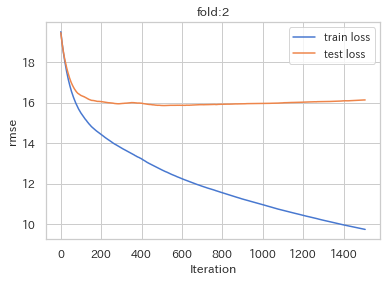

 - fold2_MAE : 15.854481


[I 2022-12-21 11:16:25,330] A new study created in memory with name: no-name-37dcaf5a-1f3f-4ff1-b315-ca4b533b0dfe



★★★★★　　　　　Fold 3　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1278]	Train's l1: 10.72	Test's l1: 15.0261


[I 2022-12-21 11:16:38,763] Trial 0 finished with value: 15.026092737064895 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 15.026092737064895.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1311]	Train's l1: 10.367	Test's l1: 15.0529


[I 2022-12-21 11:17:02,050] Trial 1 finished with value: 15.052856607596198 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 15.026092737064895.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1371]	Train's l1: 10.4263	Test's l1: 15.0055


[I 2022-12-21 11:17:21,337] Trial 2 finished with value: 15.005459621346551 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 15.005459621346551.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1189]	Train's l1: 10.7654	Test's l1: 15.0208


[I 2022-12-21 11:17:37,948] Trial 3 finished with value: 15.02080126715169 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 15.005459621346551.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1579]	Train's l1: 9.73261	Test's l1: 15.0876


[I 2022-12-21 11:18:06,141] Trial 4 finished with value: 15.087599272928971 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 15.005459621346551.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1338]	Train's l1: 10.3387	Test's l1: 15.0713


[I 2022-12-21 11:18:28,062] Trial 5 finished with value: 15.071285470090947 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 15.005459621346551.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1312]	Train's l1: 10.4205	Test's l1: 15.0147


[I 2022-12-21 11:18:47,443] Trial 6 finished with value: 15.014703707519224 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 15.005459621346551.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:19:06,403] Trial 7 finished with value: 15.082054655382569 and parameters: {'num_leaves': 228}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:19:25,130] Trial 8 finished with value: 15.082054655382569 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:19:44,086] Trial 9 finished with value: 15.082054655382569 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:20:02,952] Trial 10 finished with value: 15.082054655382569 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:20:21,718] Trial 11 finished with value: 15.082054655382569 and parameters: {'num_leaves': 190}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:20:41,128] Trial 12 finished with value: 15.082054655382569 and parameters: {'num_leaves': 200}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:21:03,244] Trial 13 finished with value: 15.082054655382569 and parameters: {'num_leaves': 141}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:21:21,998] Trial 14 finished with value: 15.082054655382569 and parameters: {'num_leaves': 93}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:21:40,969] Trial 15 finished with value: 15.082054655382569 and parameters: {'num_leaves': 144}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:21:59,885] Trial 16 finished with value: 15.082054655382569 and parameters: {'num_leaves': 171}. Best is trial 7 with value: 15.082054655382569.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1637]	Train's l1: 11.419	Test's l1: 15.0127


[I 2022-12-21 11:22:12,248] Trial 17 finished with value: 15.012735809593945 and parameters: {'num_leaves': 19}. Best is trial 17 with value: 15.012735809593945.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2564]	Train's l1: 10.9906	Test's l1: 14.9786


[I 2022-12-21 11:22:26,261] Trial 18 finished with value: 14.978641001326512 and parameters: {'num_leaves': 15}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:22:30,598] Trial 19 finished with value: 16.51608459816964 and parameters: {'num_leaves': 2}. Best is trial 18 with value: 14.978641001326512.


Did not meet early stopping. Best iteration is:
[4998]	Train's l1: 16.0459	Test's l1: 16.5161
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2300]	Train's l1: 11.7116	Test's l1: 15.0075


[I 2022-12-21 11:22:42,336] Trial 20 finished with value: 15.007480886596452 and parameters: {'num_leaves': 13}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:23:01,237] Trial 21 finished with value: 15.082054655382569 and parameters: {'num_leaves': 55}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:23:20,320] Trial 22 finished with value: 15.082054655382569 and parameters: {'num_leaves': 64}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1342]	Train's l1: 9.99983	Test's l1: 15.0303


[I 2022-12-21 11:23:37,748] Trial 23 finished with value: 15.030251423178516 and parameters: {'num_leaves': 36}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:23:56,725] Trial 24 finished with value: 15.082054655382569 and parameters: {'num_leaves': 92}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1236]	Train's l1: 9.66933	Test's l1: 15.0821


[I 2022-12-21 11:24:18,868] Trial 25 finished with value: 15.082054655382569 and parameters: {'num_leaves': 80}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1460]	Train's l1: 9.63026	Test's l1: 15.0173


[I 2022-12-21 11:24:37,551] Trial 26 finished with value: 15.017299879033716 and parameters: {'num_leaves': 37}. Best is trial 18 with value: 14.978641001326512.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1652]	Train's l1: 12.1049	Test's l1: 15.1656


[I 2022-12-21 11:24:48,926] Trial 27 finished with value: 15.165637868204916 and parameters: {'bagging_fraction': 0.8463736203169471, 'bagging_freq': 7}. Best is trial 27 with value: 15.165637868204916.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2252]	Train's l1: 11.4055	Test's l1: 15.1959


[I 2022-12-21 11:25:03,027] Trial 28 finished with value: 15.19585067814122 and parameters: {'bagging_fraction': 0.7567016863472924, 'bagging_freq': 4}. Best is trial 27 with value: 15.165637868204916.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2342]	Train's l1: 11.1749	Test's l1: 14.9857


[I 2022-12-21 11:25:17,976] Trial 29 finished with value: 14.985719790707002 and parameters: {'bagging_fraction': 0.9521814477843834, 'bagging_freq': 3}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2008]	Train's l1: 11.6714	Test's l1: 15.1876


[I 2022-12-21 11:25:31,141] Trial 30 finished with value: 15.18757199474371 and parameters: {'bagging_fraction': 0.7700426194307405, 'bagging_freq': 3}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1692]	Train's l1: 12.0281	Test's l1: 15.1213


[I 2022-12-21 11:25:42,067] Trial 31 finished with value: 15.121292221629522 and parameters: {'bagging_fraction': 0.8715631913600015, 'bagging_freq': 1}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1749]	Train's l1: 11.9516	Test's l1: 15.1176


[I 2022-12-21 11:25:54,711] Trial 32 finished with value: 15.11762385598743 and parameters: {'bagging_fraction': 0.8593009192489665, 'bagging_freq': 2}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2661]	Train's l1: 11.355	Test's l1: 15.3798


[I 2022-12-21 11:26:09,323] Trial 33 finished with value: 15.379772258795391 and parameters: {'bagging_fraction': 0.48745327640701935, 'bagging_freq': 3}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1774]	Train's l1: 12.1057	Test's l1: 15.2602


[I 2022-12-21 11:26:20,780] Trial 34 finished with value: 15.260195174413074 and parameters: {'bagging_fraction': 0.6609307394763348, 'bagging_freq': 5}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2007]	Train's l1: 11.8399	Test's l1: 15.2226


[I 2022-12-21 11:26:33,507] Trial 35 finished with value: 15.222617789860093 and parameters: {'bagging_fraction': 0.621964062277986, 'bagging_freq': 3}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2045]	Train's l1: 11.844	Test's l1: 15.2602


[I 2022-12-21 11:26:45,867] Trial 36 finished with value: 15.260169601802264 and parameters: {'bagging_fraction': 0.6102997831131538, 'bagging_freq': 6}. Best is trial 29 with value: 14.985719790707002.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2866]	Train's l1: 10.7191	Test's l1: 14.9777


[I 2022-12-21 11:26:59,423] Trial 37 finished with value: 14.977734384837794 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 14.977734384837794.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1915]	Train's l1: 11.7167	Test's l1: 14.9607


[I 2022-12-21 11:27:10,771] Trial 38 finished with value: 14.960652401478514 and parameters: {'feature_fraction': 0.484}. Best is trial 38 with value: 14.960652401478514.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2139]	Train's l1: 11.421	Test's l1: 14.9985


[I 2022-12-21 11:27:24,211] Trial 39 finished with value: 14.998506211420542 and parameters: {'feature_fraction': 0.58}. Best is trial 38 with value: 14.960652401478514.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1701]	Train's l1: 12.002	Test's l1: 14.998


[I 2022-12-21 11:27:37,630] Trial 40 finished with value: 14.998035721530574 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 38 with value: 14.960652401478514.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2118]	Train's l1: 11.4564	Test's l1: 15.0299


[I 2022-12-21 11:27:50,054] Trial 41 finished with value: 15.029856713569036 and parameters: {'feature_fraction': 0.516}. Best is trial 38 with value: 14.960652401478514.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2105]	Train's l1: 11.4505	Test's l1: 14.9479


[I 2022-12-21 11:28:02,926] Trial 42 finished with value: 14.947862260644277 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 42 with value: 14.947862260644277.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2451]	Train's l1: 11.1418	Test's l1: 14.9497


[I 2022-12-21 11:28:17,136] Trial 43 finished with value: 14.949740847494539 and parameters: {'lambda_l1': 0.08777649108812512, 'lambda_l2': 4.481040699475134}. Best is trial 43 with value: 14.949740847494539.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2244]	Train's l1: 11.2935	Test's l1: 14.9818


[I 2022-12-21 11:28:30,703] Trial 44 finished with value: 14.981796641130769 and parameters: {'lambda_l1': 2.4887263974586578, 'lambda_l2': 9.14111731896407e-07}. Best is trial 43 with value: 14.949740847494539.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2056]	Train's l1: 11.5122	Test's l1: 14.962


[I 2022-12-21 11:28:43,436] Trial 45 finished with value: 14.962006991793626 and parameters: {'lambda_l1': 2.1128905689499563e-07, 'lambda_l2': 1.3846243701088137}. Best is trial 43 with value: 14.949740847494539.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2105]	Train's l1: 11.4505	Test's l1: 14.9479


[I 2022-12-21 11:28:56,226] Trial 46 finished with value: 14.947862243681755 and parameters: {'lambda_l1': 8.163114340719316e-05, 'lambda_l2': 1.7834880297429834e-08}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2123]	Train's l1: 11.4678	Test's l1: 14.9711


[I 2022-12-21 11:29:09,285] Trial 47 finished with value: 14.971075230564049 and parameters: {'lambda_l1': 4.1053680921757644e-07, 'lambda_l2': 0.04639411668751763}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2493]	Train's l1: 11.1177	Test's l1: 14.9772


[I 2022-12-21 11:29:23,823] Trial 48 finished with value: 14.977189878758521 and parameters: {'lambda_l1': 0.00010611156076620112, 'lambda_l2': 6.731774078262394}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2188]	Train's l1: 11.445	Test's l1: 14.9759


[I 2022-12-21 11:29:37,131] Trial 49 finished with value: 14.975867282395532 and parameters: {'lambda_l1': 5.932345509204824e-06, 'lambda_l2': 7.482094006675616}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2157]	Train's l1: 11.4162	Test's l1: 15.0102


[I 2022-12-21 11:29:50,381] Trial 50 finished with value: 15.01017023914238 and parameters: {'lambda_l1': 3.7616694869132396e-06, 'lambda_l2': 0.5781386604077288}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2277]	Train's l1: 11.2544	Test's l1: 14.957


[I 2022-12-21 11:30:04,440] Trial 51 finished with value: 14.95696991783 and parameters: {'lambda_l1': 3.5967166618732977, 'lambda_l2': 1.6305832065687733e-07}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2069]	Train's l1: 11.502	Test's l1: 15.0145


[I 2022-12-21 11:30:17,507] Trial 52 finished with value: 15.01446023714451 and parameters: {'lambda_l1': 2.2084948455815048, 'lambda_l2': 0.31500600581940197}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2083]	Train's l1: 11.4741	Test's l1: 14.9639


[I 2022-12-21 11:30:30,492] Trial 53 finished with value: 14.963900105548195 and parameters: {'lambda_l1': 0.0050782579114802134, 'lambda_l2': 4.2787440640418144e-05}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2472]	Train's l1: 11.0574	Test's l1: 14.9911


[I 2022-12-21 11:30:45,156] Trial 54 finished with value: 14.99106843969895 and parameters: {'lambda_l1': 0.009224220350733522, 'lambda_l2': 1.0755082815531075e-08}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2012]	Train's l1: 11.5858	Test's l1: 14.974


[I 2022-12-21 11:31:01,320] Trial 55 finished with value: 14.973952679883574 and parameters: {'lambda_l1': 0.02243698119184662, 'lambda_l2': 0.0009424935813722679}. Best is trial 46 with value: 14.947862243681755.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1929]	Train's l1: 11.6813	Test's l1: 14.9453


[I 2022-12-21 11:31:13,571] Trial 56 finished with value: 14.945299231752166 and parameters: {'lambda_l1': 0.0002554919018569176, 'lambda_l2': 0.0020587901758208826}. Best is trial 56 with value: 14.945299231752166.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2248]	Train's l1: 11.2847	Test's l1: 14.9313


[I 2022-12-21 11:31:27,128] Trial 57 finished with value: 14.93128745369393 and parameters: {'lambda_l1': 0.00017602261477072385, 'lambda_l2': 0.001096250727282905}. Best is trial 57 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2014]	Train's l1: 11.5809	Test's l1: 14.9382


[I 2022-12-21 11:31:39,711] Trial 58 finished with value: 14.938249512203043 and parameters: {'lambda_l1': 0.0011985802929525603, 'lambda_l2': 0.0015082069813749973}. Best is trial 57 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2235]	Train's l1: 11.3284	Test's l1: 14.9835


[I 2022-12-21 11:31:53,070] Trial 59 finished with value: 14.983540955818555 and parameters: {'lambda_l1': 0.0008821775785102706, 'lambda_l2': 0.01271089935603207}. Best is trial 57 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2105]	Train's l1: 11.4505	Test's l1: 14.9479


[I 2022-12-21 11:32:06,088] Trial 60 finished with value: 14.947862196035437 and parameters: {'lambda_l1': 8.745874849801863e-06, 'lambda_l2': 5.6388385588884074e-05}. Best is trial 57 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1885]	Train's l1: 11.7202	Test's l1: 14.9881


[I 2022-12-21 11:32:18,192] Trial 61 finished with value: 14.988053438538005 and parameters: {'lambda_l1': 0.27662478298246174, 'lambda_l2': 3.0872111557964464e-05}. Best is trial 57 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2105]	Train's l1: 11.4505	Test's l1: 14.9479


[I 2022-12-21 11:32:31,229] Trial 62 finished with value: 14.947862256384806 and parameters: {'lambda_l1': 2.749301405794631e-08, 'lambda_l2': 3.572877539307622e-06}. Best is trial 57 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2248]	Train's l1: 11.2847	Test's l1: 14.9313


[I 2022-12-21 11:32:44,793] Trial 63 finished with value: 14.93128745369393 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2248]	Train's l1: 11.2847	Test's l1: 14.9313


[I 2022-12-21 11:32:58,353] Trial 64 finished with value: 14.93128745369393 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2248]	Train's l1: 11.2847	Test's l1: 14.9313


[I 2022-12-21 11:33:12,201] Trial 65 finished with value: 14.93128745369393 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2248]	Train's l1: 11.2847	Test's l1: 14.9313


[I 2022-12-21 11:33:26,167] Trial 66 finished with value: 14.93128745369393 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 14.93128745369393.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2248]	Train's l1: 11.2847	Test's l1: 14.9313


[I 2022-12-21 11:33:40,638] Trial 67 finished with value: 14.93128745369393 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 14.93128745369393.


▼▼▼▼▼　　　　　Fold 3　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.00017602261477072385, 'lambda_l2': 0.001096250727282905, 'num_leaves': 15, 'feature_fraction': 0.5479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


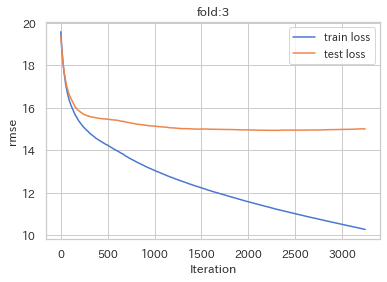

 - fold3_MAE : 14.931287


[I 2022-12-21 11:33:42,764] A new study created in memory with name: no-name-a1ab6897-5a3f-49ab-82cc-c852880d3a58



★★★★★　　　　　Fold 4　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1348]	Train's l1: 9.99963	Test's l1: 15.588


[I 2022-12-21 11:34:07,077] Trial 0 finished with value: 15.587981264007967 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 15.587981264007967.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1419]	Train's l1: 9.90963	Test's l1: 15.5334


[I 2022-12-21 11:34:31,185] Trial 1 finished with value: 15.533420337569186 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 15.533420337569186.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1384]	Train's l1: 9.91796	Test's l1: 15.5453


[I 2022-12-21 11:34:54,006] Trial 2 finished with value: 15.545313648533176 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 15.533420337569186.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1399]	Train's l1: 9.9005	Test's l1: 15.6323


[I 2022-12-21 11:35:20,571] Trial 3 finished with value: 15.632281263152615 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 15.533420337569186.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1552]	Train's l1: 9.76839	Test's l1: 15.5322


[I 2022-12-21 11:35:37,677] Trial 4 finished with value: 15.53223861062898 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 15.53223861062898.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:35:51,765] Trial 5 finished with value: 15.500091155694738 and parameters: {'feature_fraction': 0.4}. Best is trial 5 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1319]	Train's l1: 10.1918	Test's l1: 15.5478


[I 2022-12-21 11:36:09,440] Trial 6 finished with value: 15.54775971272026 and parameters: {'feature_fraction': 0.6}. Best is trial 5 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:36:25,807] Trial 7 finished with value: 15.541545352113936 and parameters: {'num_leaves': 176}. Best is trial 7 with value: 15.541545352113936.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:36:42,207] Trial 8 finished with value: 15.541545352113936 and parameters: {'num_leaves': 192}. Best is trial 7 with value: 15.541545352113936.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2545]	Train's l1: 10.8467	Test's l1: 15.6274


[I 2022-12-21 11:36:54,205] Trial 9 finished with value: 15.627443225184326 and parameters: {'num_leaves': 15}. Best is trial 7 with value: 15.541545352113936.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:37:10,825] Trial 10 finished with value: 15.541545352113936 and parameters: {'num_leaves': 164}. Best is trial 7 with value: 15.541545352113936.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:37:27,660] Trial 11 finished with value: 15.541545352113936 and parameters: {'num_leaves': 232}. Best is trial 7 with value: 15.541545352113936.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:37:47,899] Trial 12 finished with value: 15.541545352113936 and parameters: {'num_leaves': 111}. Best is trial 7 with value: 15.541545352113936.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:38:01,999] Trial 13 finished with value: 15.500091155694738 and parameters: {'num_leaves': 31}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:38:18,486] Trial 14 finished with value: 15.541545352113936 and parameters: {'num_leaves': 120}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:38:35,053] Trial 15 finished with value: 15.541545352113936 and parameters: {'num_leaves': 156}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:38:51,658] Trial 16 finished with value: 15.541545352113936 and parameters: {'num_leaves': 242}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2440]	Train's l1: 10.3412	Test's l1: 15.6198


[I 2022-12-21 11:39:05,222] Trial 17 finished with value: 15.619844016640673 and parameters: {'num_leaves': 18}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:39:21,549] Trial 18 finished with value: 15.541545352113936 and parameters: {'num_leaves': 70}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:39:37,862] Trial 19 finished with value: 15.541545352113936 and parameters: {'num_leaves': 66}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:39:54,565] Trial 20 finished with value: 15.541545352113936 and parameters: {'num_leaves': 73}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:40:10,901] Trial 21 finished with value: 15.541545352113936 and parameters: {'num_leaves': 194}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:40:27,387] Trial 22 finished with value: 15.541545352113936 and parameters: {'num_leaves': 102}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:40:44,239] Trial 23 finished with value: 15.541545352113936 and parameters: {'num_leaves': 153}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1208]	Train's l1: 9.70722	Test's l1: 15.5469


[I 2022-12-21 11:41:03,362] Trial 24 finished with value: 15.54691973174115 and parameters: {'num_leaves': 44}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:41:19,941] Trial 25 finished with value: 15.541545352113936 and parameters: {'num_leaves': 204}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1300]	Train's l1: 9.35285	Test's l1: 15.5415


[I 2022-12-21 11:41:36,244] Trial 26 finished with value: 15.541545352113936 and parameters: {'num_leaves': 147}. Best is trial 13 with value: 15.500091155694738.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1427]	Train's l1: 10.459	Test's l1: 15.6413


[I 2022-12-21 11:41:50,685] Trial 27 finished with value: 15.641279347878319 and parameters: {'bagging_fraction': 0.7652022431135697, 'bagging_freq': 7}. Best is trial 27 with value: 15.641279347878319.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2499]	Train's l1: 10.9578	Test's l1: 15.6869


[I 2022-12-21 11:42:03,830] Trial 28 finished with value: 15.6869109898341 and parameters: {'bagging_fraction': 0.42730353377293123, 'bagging_freq': 4}. Best is trial 27 with value: 15.641279347878319.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1654]	Train's l1: 10.4335	Test's l1: 15.7556


[I 2022-12-21 11:42:18,338] Trial 29 finished with value: 15.755577567791859 and parameters: {'bagging_fraction': 0.6559295716676865, 'bagging_freq': 5}. Best is trial 27 with value: 15.641279347878319.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1695]	Train's l1: 9.69452	Test's l1: 15.5964


[I 2022-12-21 11:42:35,571] Trial 30 finished with value: 15.596370837132689 and parameters: {'bagging_fraction': 0.9024859412411101, 'bagging_freq': 5}. Best is trial 30 with value: 15.596370837132689.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1867]	Train's l1: 9.56589	Test's l1: 15.6629


[I 2022-12-21 11:42:53,518] Trial 31 finished with value: 15.662890731881062 and parameters: {'bagging_fraction': 0.7931569858617911, 'bagging_freq': 3}. Best is trial 30 with value: 15.596370837132689.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2106]	Train's l1: 10.8932	Test's l1: 15.6274


[I 2022-12-21 11:43:07,756] Trial 32 finished with value: 15.627419435315211 and parameters: {'bagging_fraction': 0.4930481146831058, 'bagging_freq': 1}. Best is trial 30 with value: 15.596370837132689.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2341]	Train's l1: 10.8863	Test's l1: 15.6797


[I 2022-12-21 11:43:21,935] Trial 33 finished with value: 15.679734215854959 and parameters: {'bagging_fraction': 0.45565256821507233, 'bagging_freq': 1}. Best is trial 30 with value: 15.596370837132689.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1276]	Train's l1: 11.2475	Test's l1: 15.7179


[I 2022-12-21 11:43:34,109] Trial 34 finished with value: 15.717919239620281 and parameters: {'bagging_fraction': 0.6477267533448543, 'bagging_freq': 6}. Best is trial 30 with value: 15.596370837132689.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1866]	Train's l1: 10.6069	Test's l1: 15.7457


[I 2022-12-21 11:43:48,028] Trial 35 finished with value: 15.745726158761666 and parameters: {'bagging_fraction': 0.569364709250947, 'bagging_freq': 3}. Best is trial 30 with value: 15.596370837132689.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1540]	Train's l1: 9.91726	Test's l1: 15.596


[I 2022-12-21 11:44:05,170] Trial 36 finished with value: 15.595986737967056 and parameters: {'bagging_fraction': 0.9628335021515394, 'bagging_freq': 2}. Best is trial 36 with value: 15.595986737967056.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1316]	Train's l1: 10.3548	Test's l1: 15.5683


[I 2022-12-21 11:44:19,003] Trial 37 finished with value: 15.568277341114333 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 15.568277341114333.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1305]	Train's l1: 10.351	Test's l1: 15.5581


[I 2022-12-21 11:44:36,852] Trial 38 finished with value: 15.558147188695763 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 15.558147188695763.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1317]	Train's l1: 10.2993	Test's l1: 15.5106


[I 2022-12-21 11:44:51,860] Trial 39 finished with value: 15.51059202824988 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 39 with value: 15.51059202824988.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1396]	Train's l1: 10.2099	Test's l1: 15.5611


[I 2022-12-21 11:45:05,925] Trial 40 finished with value: 15.561112509289343 and parameters: {'lambda_l1': 0.7161894830293349, 'lambda_l2': 0.047946612165152815}. Best is trial 40 with value: 15.561112509289343.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1288]	Train's l1: 10.4508	Test's l1: 15.561


[I 2022-12-21 11:45:19,181] Trial 41 finished with value: 15.560976268909139 and parameters: {'lambda_l1': 1.0179462598497613e-08, 'lambda_l2': 0.06579394684249043}. Best is trial 41 with value: 15.560976268909139.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1400]	Train's l1: 10.2101	Test's l1: 15.5732


[I 2022-12-21 11:45:33,127] Trial 42 finished with value: 15.573224012020054 and parameters: {'lambda_l1': 6.182153880360602, 'lambda_l2': 0.7579833782786608}. Best is trial 41 with value: 15.560976268909139.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1556]	Train's l1: 9.8707	Test's l1: 15.5691


[I 2022-12-21 11:45:47,837] Trial 43 finished with value: 15.569078579330778 and parameters: {'lambda_l1': 0.009013409125547316, 'lambda_l2': 0.0008238584153216049}. Best is trial 41 with value: 15.560976268909139.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1455]	Train's l1: 10.1028	Test's l1: 15.5654


[I 2022-12-21 11:46:01,994] Trial 44 finished with value: 15.565381141179811 and parameters: {'lambda_l1': 0.26848753279932147, 'lambda_l2': 1.012023134425215e-06}. Best is trial 41 with value: 15.560976268909139.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1275]	Train's l1: 10.4754	Test's l1: 15.5698


[I 2022-12-21 11:46:15,393] Trial 45 finished with value: 15.569819532640341 and parameters: {'lambda_l1': 0.01220555937933003, 'lambda_l2': 2.5408774978283568e-08}. Best is trial 41 with value: 15.560976268909139.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1387]	Train's l1: 10.2183	Test's l1: 15.554


[I 2022-12-21 11:46:29,463] Trial 46 finished with value: 15.55396357978353 and parameters: {'lambda_l1': 0.5426242878766498, 'lambda_l2': 0.14259954436168473}. Best is trial 46 with value: 15.55396357978353.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:46:43,573] Trial 47 finished with value: 15.500091155343378 and parameters: {'lambda_l1': 4.798624881793996e-07, 'lambda_l2': 1.767447521046967e-08}. Best is trial 47 with value: 15.500091155343378.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1343]	Train's l1: 10.3275	Test's l1: 15.5817


[I 2022-12-21 11:47:03,335] Trial 48 finished with value: 15.581696127391126 and parameters: {'lambda_l1': 0.1685464730813314, 'lambda_l2': 5.52734138410552e-08}. Best is trial 47 with value: 15.500091155343378.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1374]	Train's l1: 10.2404	Test's l1: 15.5446


[I 2022-12-21 11:47:17,710] Trial 49 finished with value: 15.544571597898194 and parameters: {'lambda_l1': 1.8543144369008635, 'lambda_l2': 2.2665590139903796e-07}. Best is trial 47 with value: 15.500091155343378.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:47:31,588] Trial 50 finished with value: 15.50009114376681 and parameters: {'lambda_l1': 1.8274415662556723e-07, 'lambda_l2': 6.365805208201066e-06}. Best is trial 50 with value: 15.50009114376681.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:47:48,913] Trial 51 finished with value: 15.500091095525079 and parameters: {'lambda_l1': 4.801254029319083e-07, 'lambda_l2': 3.179231738577064e-05}. Best is trial 51 with value: 15.500091095525079.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:48:02,977] Trial 52 finished with value: 15.50009113865679 and parameters: {'lambda_l1': 6.352417408158149e-06, 'lambda_l2': 7.524517859519973e-06}. Best is trial 51 with value: 15.500091095525079.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:48:16,840] Trial 53 finished with value: 15.500090942920908 and parameters: {'lambda_l1': 7.017840458370849e-06, 'lambda_l2': 0.00011051085400847856}. Best is trial 53 with value: 15.500090942920908.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1428]	Train's l1: 10.1446	Test's l1: 15.5758


[I 2022-12-21 11:48:30,777] Trial 54 finished with value: 15.57580225949156 and parameters: {'lambda_l1': 5.990896799083222e-05, 'lambda_l2': 0.002746388550583544}. Best is trial 53 with value: 15.500090942920908.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:48:44,811] Trial 55 finished with value: 15.500090933283094 and parameters: {'lambda_l1': 4.943345624661716e-05, 'lambda_l2': 0.00010480539272255971}. Best is trial 55 with value: 15.500090933283094.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:48:58,828] Trial 56 finished with value: 15.500090815765876 and parameters: {'lambda_l1': 0.00027753944108863316, 'lambda_l2': 0.00010782241539948773}. Best is trial 56 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1398]	Train's l1: 10.2168	Test's l1: 15.548


[I 2022-12-21 11:49:12,566] Trial 57 finished with value: 15.547958776591258 and parameters: {'lambda_l1': 0.0006818092247221029, 'lambda_l2': 0.0017643454540762174}. Best is trial 56 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1400]	Train's l1: 10.1956	Test's l1: 15.5748


[I 2022-12-21 11:49:26,429] Trial 58 finished with value: 15.574820374027635 and parameters: {'lambda_l1': 0.0006702714440841444, 'lambda_l2': 0.006344775619998501}. Best is trial 56 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:49:40,333] Trial 59 finished with value: 15.500090957486071 and parameters: {'lambda_l1': 4.4498778403558366e-05, 'lambda_l2': 9.322698003929447e-05}. Best is trial 56 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:49:54,283] Trial 60 finished with value: 15.500090815765876 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:50:08,402] Trial 61 finished with value: 15.500090815765876 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:50:22,469] Trial 62 finished with value: 15.500090815765876 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:50:36,803] Trial 63 finished with value: 15.500090815765876 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 15.500090815765876.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1439]	Train's l1: 10.1239	Test's l1: 15.5001


[I 2022-12-21 11:50:51,223] Trial 64 finished with value: 15.500090815765876 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 15.500090815765876.


▼▼▼▼▼　　　　　Fold 4　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.00027753944108863316, 'lambda_l2': 0.00010782241539948773, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


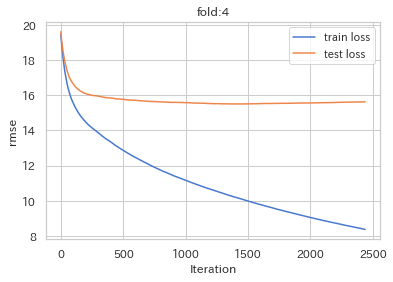

 - fold4_MAE : 15.500091


[I 2022-12-21 11:50:53,607] A new study created in memory with name: no-name-b970d68c-27ee-4b1a-9276-7bac858d546c



★★★★★　　　　　Fold 5　　　　　★★★★★
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1540]	Train's l1: 9.71207	Test's l1: 15.4758


[I 2022-12-21 11:51:21,282] Trial 0 finished with value: 15.475801990151313 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 15.475801990151313.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1625]	Train's l1: 9.64764	Test's l1: 15.3895


[I 2022-12-21 11:51:41,064] Trial 1 finished with value: 15.389536539333228 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 15.389536539333228.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1755]	Train's l1: 9.23863	Test's l1: 15.5242


[I 2022-12-21 11:52:11,374] Trial 2 finished with value: 15.524220057074423 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 15.389536539333228.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1210]	Train's l1: 10.6181	Test's l1: 15.3832


[I 2022-12-21 11:52:26,202] Trial 3 finished with value: 15.383185131288045 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 15.383185131288045.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[958]	Train's l1: 11.4106	Test's l1: 15.3723


[I 2022-12-21 11:52:37,587] Trial 4 finished with value: 15.372260018428253 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 15.372260018428253.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[868]	Train's l1: 11.3667	Test's l1: 15.4723


[I 2022-12-21 11:52:56,528] Trial 5 finished with value: 15.472264369845004 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 15.372260018428253.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1017]	Train's l1: 11.0031	Test's l1: 15.4164


[I 2022-12-21 11:53:13,576] Trial 6 finished with value: 15.416351189663416 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 15.372260018428253.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:53:26,892] Trial 7 finished with value: 15.392326414431952 and parameters: {'num_leaves': 178}. Best is trial 7 with value: 15.392326414431952.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:53:40,349] Trial 8 finished with value: 15.392326414431952 and parameters: {'num_leaves': 249}. Best is trial 7 with value: 15.392326414431952.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:53:53,734] Trial 9 finished with value: 15.392326414431952 and parameters: {'num_leaves': 190}. Best is trial 7 with value: 15.392326414431952.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:54:07,235] Trial 10 finished with value: 15.392326414431952 and parameters: {'num_leaves': 114}. Best is trial 7 with value: 15.392326414431952.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:54:24,251] Trial 11 finished with value: 15.392326414431952 and parameters: {'num_leaves': 118}. Best is trial 7 with value: 15.392326414431952.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3611]	Train's l1: 11.7047	Test's l1: 15.3041


[I 2022-12-21 11:54:34,777] Trial 12 finished with value: 15.304149757310853 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:54:48,188] Trial 13 finished with value: 15.392326414431952 and parameters: {'num_leaves': 73}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:55:01,626] Trial 14 finished with value: 15.392326414431952 and parameters: {'num_leaves': 51}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:55:15,214] Trial 15 finished with value: 15.392326414431952 and parameters: {'num_leaves': 169}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:55:28,617] Trial 16 finished with value: 15.392326414431952 and parameters: {'num_leaves': 99}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1574]	Train's l1: 10.5275	Test's l1: 15.3231


[I 2022-12-21 11:55:41,479] Trial 17 finished with value: 15.32313683998187 and parameters: {'num_leaves': 26}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2067]	Train's l1: 11.3086	Test's l1: 15.3255


[I 2022-12-21 11:55:52,353] Trial 18 finished with value: 15.325470413720767 and parameters: {'num_leaves': 16}. Best is trial 12 with value: 15.304149757310853.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3196]	Train's l1: 11.6918	Test's l1: 15.296


[I 2022-12-21 11:56:02,633] Trial 19 finished with value: 15.296037352143172 and parameters: {'num_leaves': 10}. Best is trial 19 with value: 15.296037352143172.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:56:15,852] Trial 20 finished with value: 15.392326414431952 and parameters: {'num_leaves': 59}. Best is trial 19 with value: 15.296037352143172.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2781	Test's l1: 15.2827


[I 2022-12-21 11:56:25,792] Trial 21 finished with value: 15.282676757798537 and parameters: {'num_leaves': 8}. Best is trial 21 with value: 15.282676757798537.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[853]	Train's l1: 10.9448	Test's l1: 15.3953


[I 2022-12-21 11:56:38,525] Trial 22 finished with value: 15.395347785959578 and parameters: {'num_leaves': 43}. Best is trial 21 with value: 15.282676757798537.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.7216	Test's l1: 15.289


[I 2022-12-21 11:56:47,583] Trial 23 finished with value: 15.289025628937171 and parameters: {'num_leaves': 7}. Best is trial 21 with value: 15.282676757798537.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:57:00,566] Trial 24 finished with value: 15.392326414431952 and parameters: {'num_leaves': 93}. Best is trial 21 with value: 15.282676757798537.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:57:13,627] Trial 25 finished with value: 15.392326414431952 and parameters: {'num_leaves': 137}. Best is trial 21 with value: 15.282676757798537.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[880]	Train's l1: 10.7708	Test's l1: 15.3923


[I 2022-12-21 11:57:26,732] Trial 26 finished with value: 15.392326414431952 and parameters: {'num_leaves': 76}. Best is trial 21 with value: 15.282676757798537.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.4821	Test's l1: 15.4368


[I 2022-12-21 11:57:41,940] Trial 27 finished with value: 15.43675396731952 and parameters: {'bagging_fraction': 0.7963292140749365, 'bagging_freq': 3}. Best is trial 27 with value: 15.43675396731952.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.6527	Test's l1: 15.4923


[I 2022-12-21 11:57:53,200] Trial 28 finished with value: 15.492271575085864 and parameters: {'bagging_fraction': 0.6579346332470268, 'bagging_freq': 6}. Best is trial 27 with value: 15.43675396731952.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3959]	Train's l1: 12.4361	Test's l1: 15.4928


[I 2022-12-21 11:58:03,617] Trial 29 finished with value: 15.492823036339127 and parameters: {'bagging_fraction': 0.4015859231711814, 'bagging_freq': 4}. Best is trial 27 with value: 15.43675396731952.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.6411	Test's l1: 15.4614


[I 2022-12-21 11:58:15,166] Trial 30 finished with value: 15.461364719043214 and parameters: {'bagging_fraction': 0.6506709747235611, 'bagging_freq': 3}. Best is trial 27 with value: 15.43675396731952.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.4671	Test's l1: 15.3689


[I 2022-12-21 11:58:28,066] Trial 31 finished with value: 15.368871626815679 and parameters: {'bagging_fraction': 0.8244912041552901, 'bagging_freq': 7}. Best is trial 31 with value: 15.368871626815679.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.3613	Test's l1: 15.343


[I 2022-12-21 11:58:40,247] Trial 32 finished with value: 15.343040825732205 and parameters: {'bagging_fraction': 0.9535082870959861, 'bagging_freq': 5}. Best is trial 32 with value: 15.343040825732205.


Training until validation scores don't improve for 1000 rounds.


[I 2022-12-21 11:58:47,245] Trial 33 finished with value: 15.546477276972738 and parameters: {'bagging_fraction': 0.5129969672713145, 'bagging_freq': 7}. Best is trial 32 with value: 15.343040825732205.


Early stopping, best iteration is:
[2121]	Train's l1: 13.4232	Test's l1: 15.5465
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[4983]	Train's l1: 11.8686	Test's l1: 15.53


[I 2022-12-21 11:58:58,355] Trial 34 finished with value: 15.529975977124247 and parameters: {'bagging_fraction': 0.442915709796222, 'bagging_freq': 3}. Best is trial 32 with value: 15.343040825732205.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3813]	Train's l1: 12.3473	Test's l1: 15.5048


[I 2022-12-21 11:59:09,392] Trial 35 finished with value: 15.504765647255613 and parameters: {'bagging_fraction': 0.5523243008765633, 'bagging_freq': 4}. Best is trial 32 with value: 15.343040825732205.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3822]	Train's l1: 12.426	Test's l1: 15.4663


[I 2022-12-21 11:59:20,196] Trial 36 finished with value: 15.466314133356784 and parameters: {'bagging_fraction': 0.46073807662701277, 'bagging_freq': 3}. Best is trial 32 with value: 15.343040825732205.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3553]	Train's l1: 12.079	Test's l1: 15.328


[I 2022-12-21 11:59:29,639] Trial 37 finished with value: 15.327962288672705 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 15.327962288672705.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3876]	Train's l1: 11.846	Test's l1: 15.3145


[I 2022-12-21 11:59:40,235] Trial 38 finished with value: 15.314507750607875 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 15.314507750607875.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.1986	Test's l1: 15.2921


[I 2022-12-21 11:59:51,356] Trial 39 finished with value: 15.292097194943462 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 39 with value: 15.292097194943462.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3466]	Train's l1: 12.16	Test's l1: 15.2791


[I 2022-12-21 12:00:00,513] Trial 40 finished with value: 15.27914165152233 and parameters: {'lambda_l1': 3.1881956637047618e-06, 'lambda_l2': 1.0222312973928105}. Best is trial 40 with value: 15.27914165152233.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3966]	Train's l1: 11.837	Test's l1: 15.2841


[I 2022-12-21 12:00:10,800] Trial 41 finished with value: 15.284059106849936 and parameters: {'lambda_l1': 5.936570334131128, 'lambda_l2': 0.006818885488293915}. Best is trial 40 with value: 15.27914165152233.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2781	Test's l1: 15.2827


[I 2022-12-21 12:00:21,254] Trial 42 finished with value: 15.282676757604374 and parameters: {'lambda_l1': 1.915552951208873e-07, 'lambda_l2': 4.374506278928105e-08}. Best is trial 40 with value: 15.27914165152233.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3660]	Train's l1: 12.0326	Test's l1: 15.309


[I 2022-12-21 12:00:30,851] Trial 43 finished with value: 15.30902631407054 and parameters: {'lambda_l1': 1.5581877836785903e-05, 'lambda_l2': 0.04584568202335531}. Best is trial 40 with value: 15.27914165152233.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.3098	Test's l1: 15.2748


[I 2022-12-21 12:00:41,564] Trial 44 finished with value: 15.274802822436717 and parameters: {'lambda_l1': 9.703213493993172e-06, 'lambda_l2': 0.3746443677012039}. Best is trial 44 with value: 15.274802822436717.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2855	Test's l1: 15.3238


[I 2022-12-21 12:00:51,883] Trial 45 finished with value: 15.323847751551833 and parameters: {'lambda_l1': 0.03297599913103413, 'lambda_l2': 0.010495467923345655}. Best is trial 44 with value: 15.274802822436717.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2781	Test's l1: 15.2827


[I 2022-12-21 12:01:05,507] Trial 46 finished with value: 15.282676735696935 and parameters: {'lambda_l1': 2.3022104520033978e-08, 'lambda_l2': 9.954341527091076e-06}. Best is trial 44 with value: 15.274802822436717.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2715	Test's l1: 15.2623


[I 2022-12-21 12:01:15,885] Trial 47 finished with value: 15.262266464497579 and parameters: {'lambda_l1': 9.544439148889781, 'lambda_l2': 0.0001763115798801603}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3939]	Train's l1: 11.8726	Test's l1: 15.2926


[I 2022-12-21 12:01:25,870] Trial 48 finished with value: 15.292582983931354 and parameters: {'lambda_l1': 0.0001598301401902085, 'lambda_l2': 0.34876652539595604}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3737]	Train's l1: 12.0039	Test's l1: 15.3024


[I 2022-12-21 12:01:35,461] Trial 49 finished with value: 15.302393684104857 and parameters: {'lambda_l1': 0.2041309281371399, 'lambda_l2': 1.5949744070067051}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.3107	Test's l1: 15.2753


[I 2022-12-21 12:01:45,621] Trial 50 finished with value: 15.275334724412243 and parameters: {'lambda_l1': 0.015152872407593759, 'lambda_l2': 5.05219673515236e-06}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3571]	Train's l1: 12.0753	Test's l1: 15.2758


[I 2022-12-21 12:01:54,846] Trial 51 finished with value: 15.275780313120606 and parameters: {'lambda_l1': 0.0015600690647033706, 'lambda_l2': 0.00021748681565936457}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.308	Test's l1: 15.2647


[I 2022-12-21 12:02:05,182] Trial 52 finished with value: 15.264705054057135 and parameters: {'lambda_l1': 4.855254710323519, 'lambda_l2': 0.00036923126882930265}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2437	Test's l1: 15.2819


[I 2022-12-21 12:02:15,546] Trial 53 finished with value: 15.281920085986666 and parameters: {'lambda_l1': 8.751538502874451, 'lambda_l2': 0.00012390021716592923}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2624	Test's l1: 15.3469


[I 2022-12-21 12:02:25,733] Trial 54 finished with value: 15.346899871860701 and parameters: {'lambda_l1': 0.4484438497424606, 'lambda_l2': 1.1765957047406236e-06}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[5000]	Train's l1: 11.2884	Test's l1: 15.3023


[I 2022-12-21 12:02:36,083] Trial 55 finished with value: 15.302331774452032 and parameters: {'lambda_l1': 0.7559901469419883, 'lambda_l2': 0.0016148478095037219}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3571]	Train's l1: 12.0753	Test's l1: 15.2758


[I 2022-12-21 12:02:45,521] Trial 56 finished with value: 15.275779191484974 and parameters: {'lambda_l1': 0.005382762954404359, 'lambda_l2': 3.265492262298588e-05}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3885]	Train's l1: 11.8783	Test's l1: 15.2909


[I 2022-12-21 12:02:55,768] Trial 57 finished with value: 15.290928378041379 and parameters: {'lambda_l1': 9.92046348385889, 'lambda_l2': 7.258323062648245e-08}. Best is trial 47 with value: 15.262266464497579.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3722]	Train's l1: 11.9937	Test's l1: 15.2603


[I 2022-12-21 12:03:05,329] Trial 58 finished with value: 15.260333835863158 and parameters: {'lambda_l1': 0.1317221738357586, 'lambda_l2': 6.084532807945656e-07}. Best is trial 58 with value: 15.260333835863158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2907]	Train's l1: 12.544	Test's l1: 15.3082


[I 2022-12-21 12:03:13,420] Trial 59 finished with value: 15.308211604254645 and parameters: {'lambda_l1': 0.08326194091854318, 'lambda_l2': 3.5897928277922965e-07}. Best is trial 58 with value: 15.260333835863158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3722]	Train's l1: 11.9937	Test's l1: 15.2603


[I 2022-12-21 12:03:23,359] Trial 60 finished with value: 15.260333835863158 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 15.260333835863158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3722]	Train's l1: 11.9937	Test's l1: 15.2603


[I 2022-12-21 12:03:32,978] Trial 61 finished with value: 15.260333835863158 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 15.260333835863158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3722]	Train's l1: 11.9937	Test's l1: 15.2603


[I 2022-12-21 12:03:42,582] Trial 62 finished with value: 15.260333835863158 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 15.260333835863158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3722]	Train's l1: 11.9937	Test's l1: 15.2603


[I 2022-12-21 12:03:52,169] Trial 63 finished with value: 15.260333835863158 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 15.260333835863158.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[3722]	Train's l1: 11.9937	Test's l1: 15.2603


[I 2022-12-21 12:04:01,826] Trial 64 finished with value: 15.260333835863158 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 15.260333835863158.


▼▼▼▼▼　　　　　Fold 5　　　　　▼▼▼▼▼
best_params： {'boosting_type': 'gbdt', 'metric': 'l1', 'learning_rate': 0.015, 'random_state': 0, 'verbose': -1, 'show_progress_bar ': False, 'device': 'cpu', 'deterministic': True, 'feature_pre_filter': False, 'min_data_in_leaf': 100, 'lambda_l1': 0.1317221738357586, 'lambda_l2': 6.084532807945656e-07, 'num_leaves': 8, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲


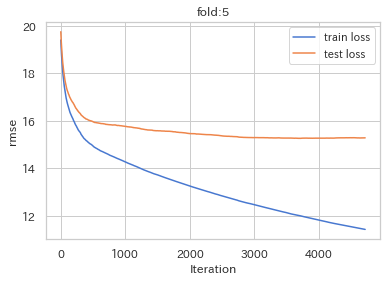

 - fold5_MAE : 15.260334
 - CV_MAE : 15.209790


In [67]:
kf_cv = list(kf.split(X_train_printer_sub_feature))
oof_valid_lgb_sub_printer, lgb_models_sub_printer = fit_lgb_oputuna(x=X_train_printer_sub_feature, y=train_printer_sub_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=params
                                     )

In [68]:
#oof_valid_lgb_sub_printer, lgb_models_sub_printer
file_path = f'lgb_models_sub_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_printer, f)

file_path = f'oof_valid_lgb_sub_printer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_sub_printer, f)

In [ ]:
train_main_gluer_x = train_gluer_df.drop(columns=['作業時間', '作業付帯時間'])
train_main_gluer_y = train_gluer_df['作業付帯時間']

In [ ]:
kf_cv = list(kf.split(train_gluer_main_x))
oof_valid_lgb_main_gluer, lgb_models_main_gluer = fit_lgb_oputuna(x=X_train_gluer_main_feature, y=train_gluer_main_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=params
                                     )

In [ ]:
#oof_valid_lgb_sub_printer, lgb_models_sub_printer
file_path = f'lgb_models_main_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_printer, f)

file_path = f'oof_valid_lgb_main_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_main_gluer, f)

In [ ]:
"""
X_train_printer_main_feature.to_csv("X_train_printer_main_feature.csv")
X_train_printer_sub_feature.to_csv("X_train_printer_sub_feature.csv")
X_train_gluer_main_feature.to_csv("X_train_gluer_main_feature.csv")
X_train_gluer_sub_feature.to_csv("X_train_gluer_sub_feature.csv")
"""

In [ ]:
kf_cv = list(kf.split(train_gluer_sub_x))
oof_valid_lgb_sub_gluer, lgb_models_sub_gluer = fit_lgb_oputuna(x=X_train_gluer_sub_feature, y=train_gluer_sub_y, cv=kf_cv,
                                      model_params=optuna_model_params, fit_params=params
                                     )

In [ ]:
#oof_valid_lgb_sub_printer, lgb_models_sub_printer
file_path = f'lgb_models_sub_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models_sub_gluer, f)

file_path = f'oof_valid_lgb_sub_gluer.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(oof_valid_lgb_sub_gluer, f)

In [70]:
!pwd

/content/drive/MyDrive/マナビDX_Quest/PBL05/data/baseline_autofeat_model


In [71]:
# 非pickle化
#oof_valid_lgb_main_gluer, lgb_models_main_gluer
with open('oof_valid_lgb_main_gluer.pkl', 'rb') as f:
    oof_valid_lgb_main_gluer = pickle.load(f)

with open('lgb_models_main_gluer.pkl', 'rb') as f:
    lgb_models_main_gluer = pickle.load(f)

#oof_valid_lgb_sub_gluer, lgb_models_sub_gluer 
with open('oof_valid_lgb_sub_gluer.pkl', 'rb') as f:
    oof_valid_lgb_sub_gluer = pickle.load(f)

with open('lgb_models_sub_gluer.pkl', 'rb') as f:
    lgb_models_sub_gluer = pickle.load(f)

In [72]:
def visualize_importance(models, feat_train_df, file_name):
    
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0,
                                          ignore_index=True
                                         )
    
    mean_feature_importance = feature_importance_df.groupby('column').mean().sort_values('feature_importance', ascending=False)
    mean_feature_importance.to_csv(os.path.join(Output_Model, f'feature_importance_{file_name}.csv'), index=True)
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(order) * 0.25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

In [73]:
Output_Model = "/content/drive/MyDrive/マナビDX_Quest/PBL05/data/model"

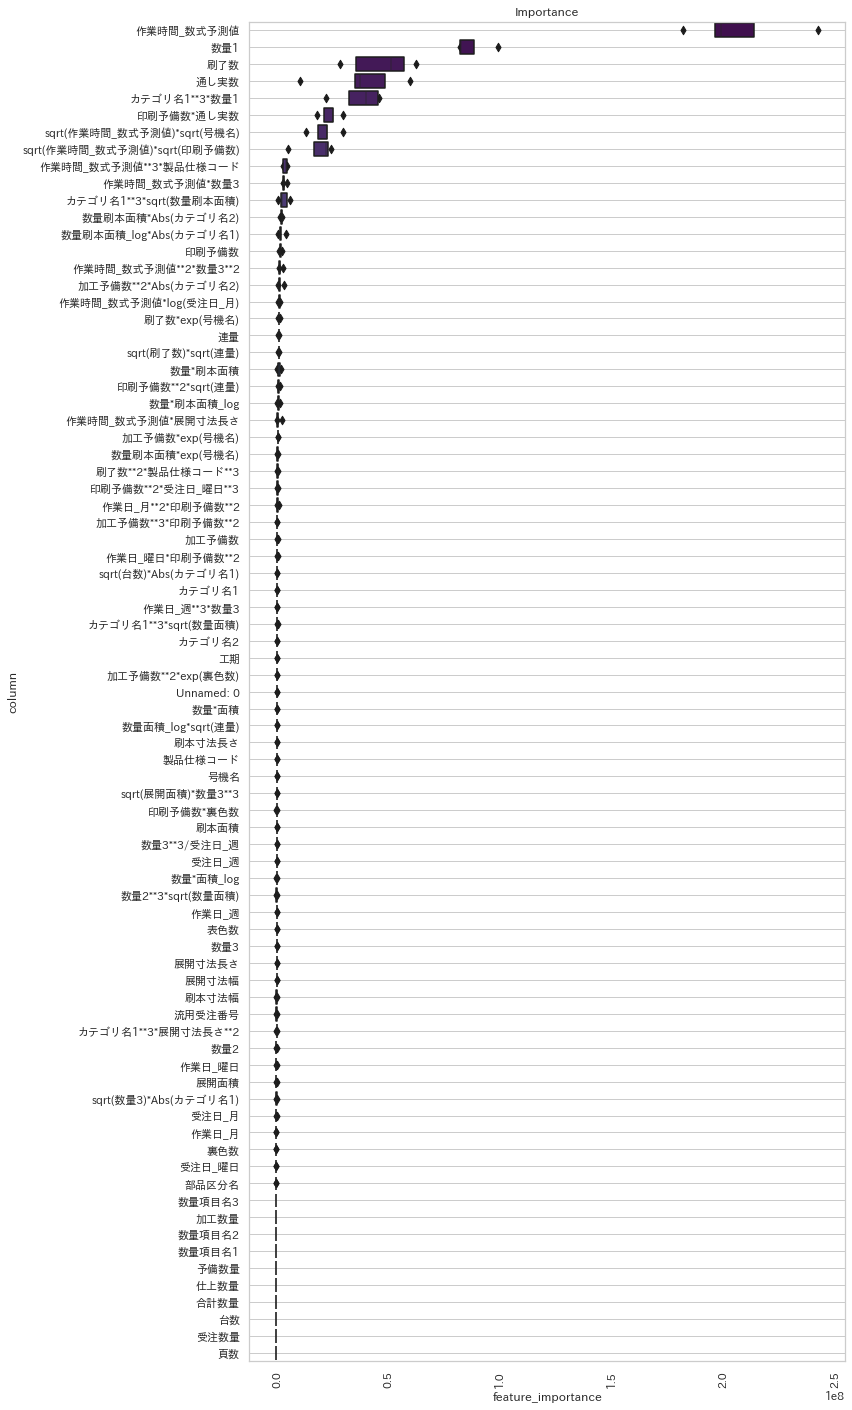

In [75]:
_ = visualize_importance(lgb_models_main_printer, X_train_printer_main_feature, 'lgb_models_main_printer')

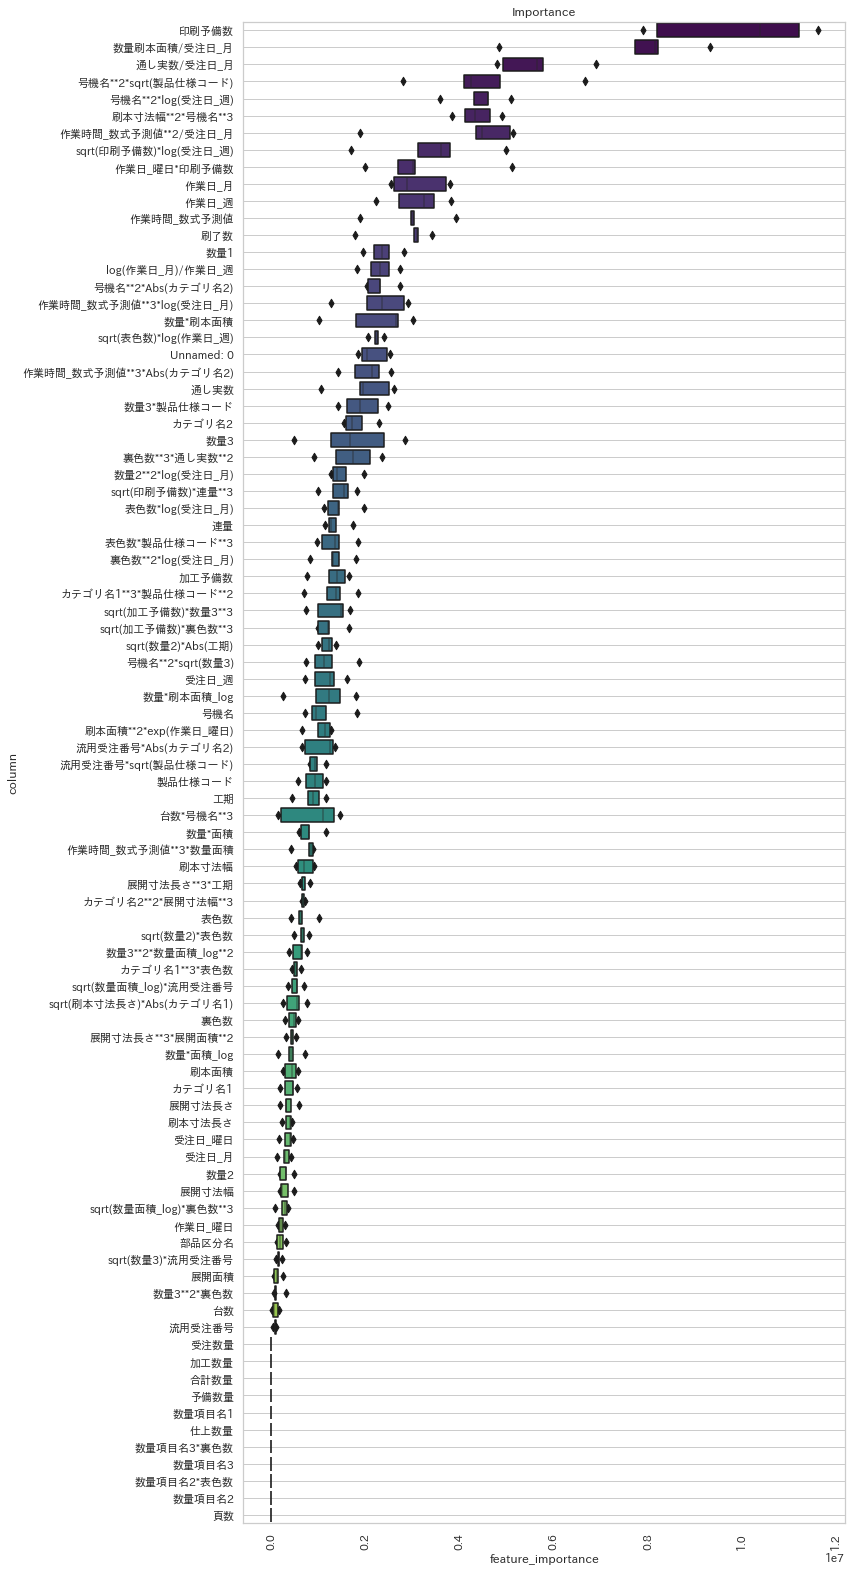

In [76]:
_ = visualize_importance(lgb_models_sub_printer, X_train_printer_sub_feature, 'lgb_models_sub_printer')

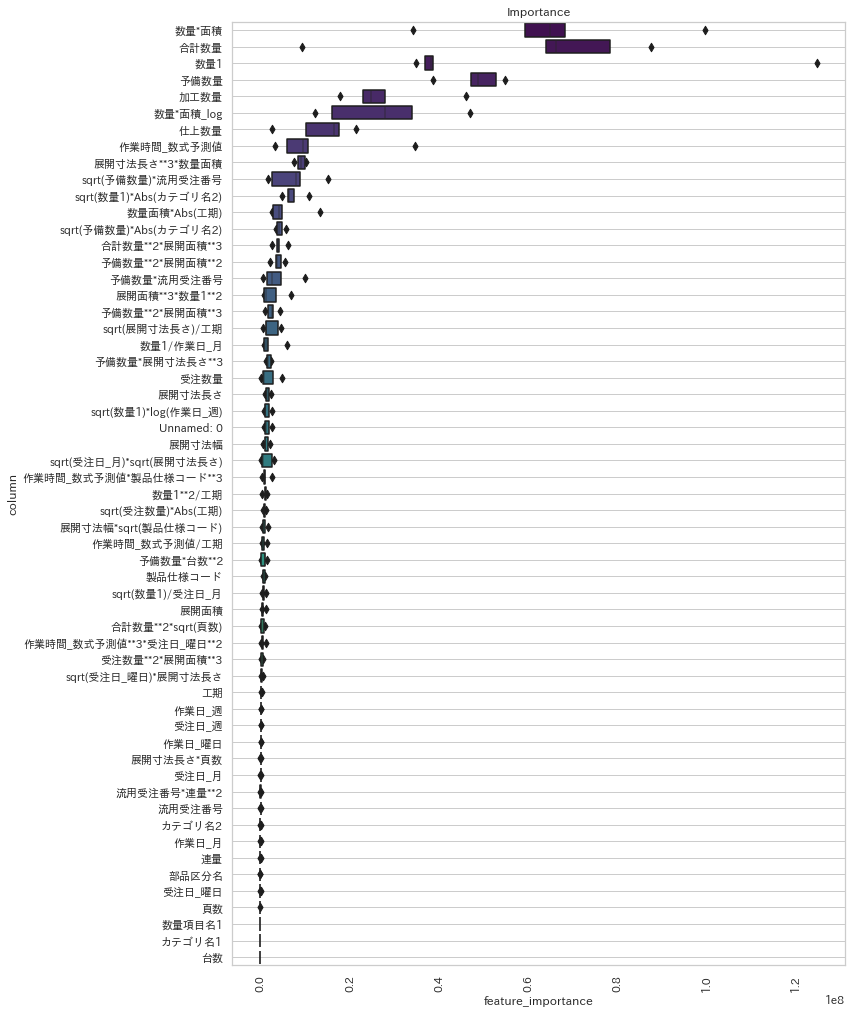

In [77]:
_ = visualize_importance(lgb_models_main_gluer, X_train_gluer_main_feature, 'lgb_models_main_gluer')

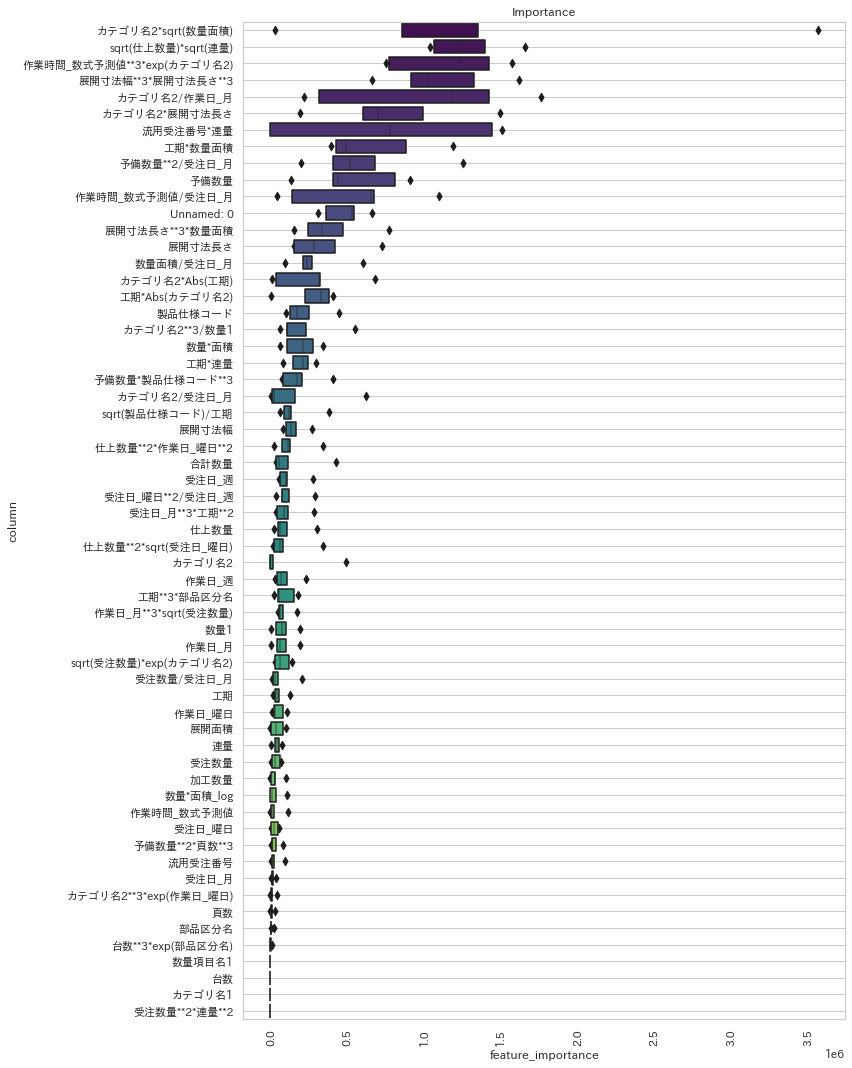

In [79]:
_ = visualize_importance(lgb_models_sub_gluer, X_train_gluer_sub_feature, 'lgb_models_sub_gluer')

In [80]:
import scipy
def predict_test(models, df):
    out = np.array([model.predict(df) for model in models])
    #out = np.mean(out, axis=0)
    
    
    # トリム平均を算出
    out = scipy.stats.trim_mean(out, 0.2, axis=0)
    print("out.shape:", out.shape)
    
    return out

In [81]:
#check distribution of train and test_pred data
def plot_prediction_distribution(y_true, y_pred, y_test):
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.histplot(y_test, label='Test Predict', ax=ax, color='black', stat='density')
    sns.histplot(y_pred, label='Out Of Fold', ax=ax, color='C1', stat='density', alpha=0.5)
    sns.histplot(y_true, label='True Value', ax=ax, color='blue', stat='density', alpha=0.5)
    ax.legend()
    ax.grid()

In [82]:
"""
pred_main = predict_test(lgb_models_main, test_df)
pred_sub = predict_test(lgb_models_sub, test_df)
"""
"""
pred_main_printer = predict_test(lgb_models_main_printer, train_main_printer_x)
pred_sub_printer = predict_test(lgb_models_sub_printer, train_sub_printer_x)
pred_main_glue = predict_test(lgb_models_main_gluer, train_main_gluer_x)
pred_sub_glue = predict_test(lgb_models_sub_gluer, train_sub_gluer_x)
"""
pred_main_printer = predict_test(lgb_models_main_printer, X_test_printer_main_feature)
pred_sub_printer = predict_test(lgb_models_sub_printer, X_test_printer_sub_feature)
pred_main_glue = predict_test(lgb_models_main_gluer, X_test_gluer_sub_feature)
pred_sub_glue = predict_test(lgb_models_sub_gluer, X_test_gluer_sub_feature)

out.shape: (4927,)
out.shape: (4927,)
out.shape: (1056,)
out.shape: (1056,)


In [ ]:
test_printer_df

,製品仕様コード,流用受注番号,展開寸法幅,展開寸法長さ,号機名,数量1,数量2,数量3,連量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
944,486,False,100.0,48.0,1,1400.0,1.0,4.0,NaN,1.0,848.0,960.0,440.0,112.0,2,-1,5.0,5.0,325.0,475.0,1,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
932,477,False,420.0,297.0,3,5000.0,1.0,0.0,44.5,1.0,4500.0,4600.0,400.0,100.0,0,8,1.0,0.0,625.0,880.0,1,1,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
1070,590,True,297.0,210.0,4,2000.0,4.0,0.0,35.0,1.0,1500.0,1700.0,300.0,200.0,0,8,2.0,2.0,625.0,880.0,1,2,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
1030,556,True,55.0,91.0,4,2000.0,5.0,0.0,200.0,1.0,1362.0,1428.0,572.0,66.0,0,13,2.0,3.0,392.0,544.0,1,3,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
912,462,True,0.0,0.0,3,900.0,0.0,2.0,35.0,1.0,NaN,NaN,NaN,NaN,0,8,1.0,1.0,625.0,880.0,1,4,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,410,False,175.8,318.0,1,550.0,2.0,2.0,7.0,1.0,167.0,350.0,200.0,183.0,0,1,4.0,0.0,550.0,400.0,1,5978,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4903,1004,False,170.0,80.0,1,800.0,1.0,0.0,35.0,1.0,167.0,400.0,400.0,233.0,0,2,4.0,1.0,548.0,398.0,2,5979,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4153,2280,False,62.0,90.0,1,1200.0,5.0,0.0,NaN,1.0,820.0,950.0,250.0,130.0,2,-1,5.0,0.0,325.0,475.0,1,5980,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4907,34,False,185.3,240.0,1,2800.0,1.0,0.0,7.0,1.0,2500.0,2700.0,100.0,200.0,0,1,1.0,0.0,550.0,400.0,1,5981,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


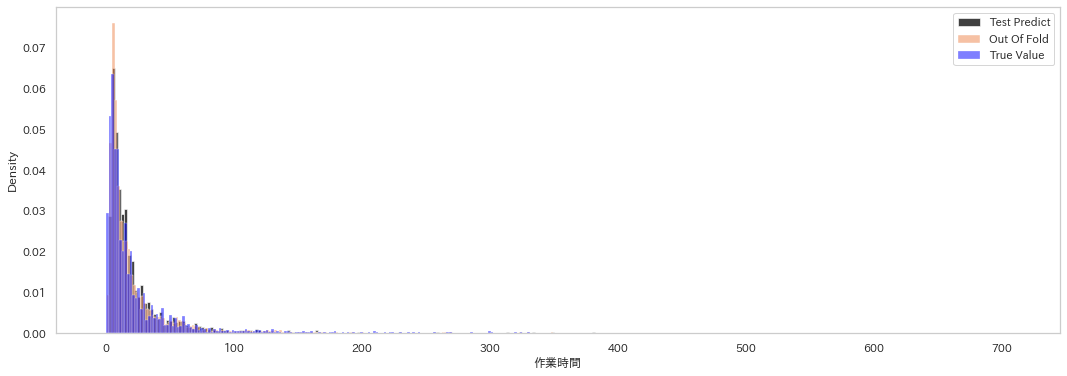

In [83]:
plot_prediction_distribution(train_printer_main_y, oof_valid_lgb_main_printer, pred_main_printer)

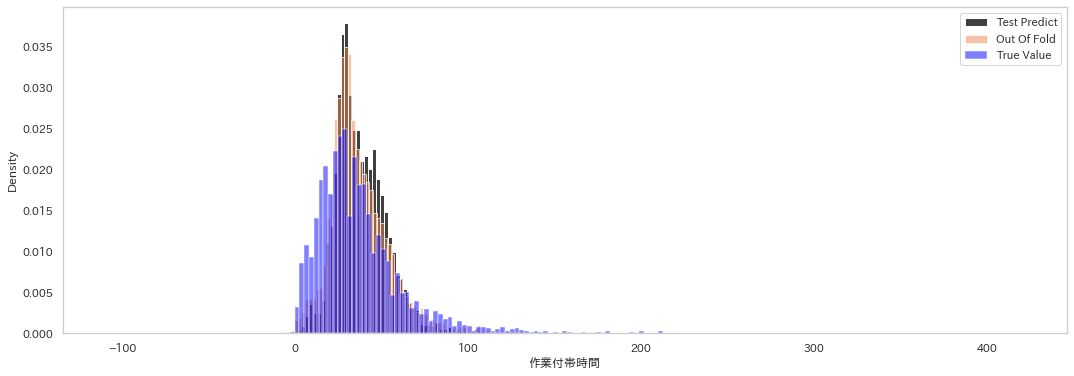

In [84]:
plot_prediction_distribution(train_printer_sub_y, oof_valid_lgb_sub_printer, pred_sub_printer)

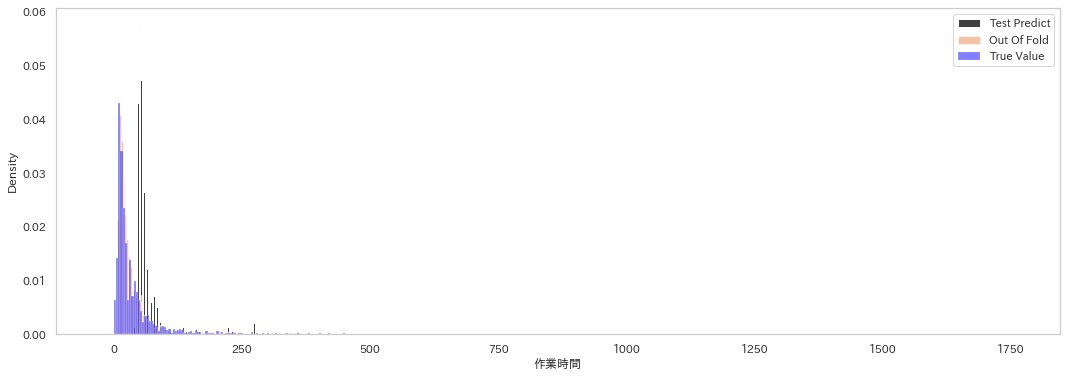

In [85]:
plot_prediction_distribution(train_gluer_main_y, oof_valid_lgb_main_gluer, pred_main_glue)

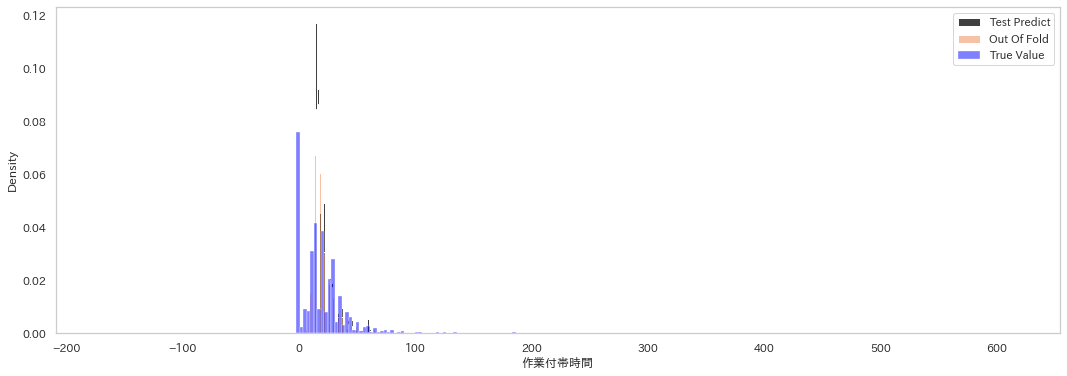

In [86]:
plot_prediction_distribution(train_gluer_sub_y, oof_valid_lgb_sub_gluer, pred_sub_glue)

In [ ]:
test_printer_df

,製品仕様コード,流用受注番号,展開寸法幅,展開寸法長さ,号機名,数量1,数量2,数量3,連量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
944,486,False,100.0,48.0,1,1400.0,1.0,4.0,NaN,1.0,848.0,960.0,440.0,112.0,2,-1,5.0,5.0,325.0,475.0,1,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
932,477,False,420.0,297.0,3,5000.0,1.0,0.0,44.5,1.0,4500.0,4600.0,400.0,100.0,0,8,1.0,0.0,625.0,880.0,1,1,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
1070,590,True,297.0,210.0,4,2000.0,4.0,0.0,35.0,1.0,1500.0,1700.0,300.0,200.0,0,8,2.0,2.0,625.0,880.0,1,2,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
1030,556,True,55.0,91.0,4,2000.0,5.0,0.0,200.0,1.0,1362.0,1428.0,572.0,66.0,0,13,2.0,3.0,392.0,544.0,1,3,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
912,462,True,0.0,0.0,3,900.0,0.0,2.0,35.0,1.0,NaN,NaN,NaN,NaN,0,8,1.0,1.0,625.0,880.0,1,4,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,410,False,175.8,318.0,1,550.0,2.0,2.0,7.0,1.0,167.0,350.0,200.0,183.0,0,1,4.0,0.0,550.0,400.0,1,5978,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4903,1004,False,170.0,80.0,1,800.0,1.0,0.0,35.0,1.0,167.0,400.0,400.0,233.0,0,2,4.0,1.0,548.0,398.0,2,5979,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4153,2280,False,62.0,90.0,1,1200.0,5.0,0.0,NaN,1.0,820.0,950.0,250.0,130.0,2,-1,5.0,0.0,325.0,475.0,1,5980,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4907,34,False,185.3,240.0,1,2800.0,1.0,0.0,7.0,1.0,2500.0,2700.0,100.0,200.0,0,1,1.0,0.0,550.0,400.0,1,5981,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [ ]:
test_printer_df

In [ ]:
printer_list = ['2号機', '4号機', '6号機', '7号機', '8号機']
df_test['index'] = df_test.index
df_test_printer_index = df_test[df_test["Machine"].isin(printer_list)]
df_test_printer_index = df_test_printer_index.drop(["Machine"], axis=1)
df_test_printer = df_test_printer_index.drop(["index"], axis=1)

df_test_gluer_index = df_test[df_test["Machine"]=="グルアー"]
df_test_gluer_index = df_test_gluer_index.drop(["Machine"], axis=1)
df_test_gluer = df_test_gluer_index.drop(["index"], axis=1)

In [ ]:
test_printer_df

,製品仕様コード,流用受注番号,展開寸法幅,展開寸法長さ,号機名,数量1,数量2,数量3,連量,台数,通し実数,刷了数,印刷予備数,加工予備数,カテゴリ名1,カテゴリ名2,表色数,裏色数,刷本寸法長さ,刷本寸法幅,部品区分名,index,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,刷本面積,数量*刷本面積,数量*刷本面積_log,工期
944,486,False,100.0,48.0,1,1400.0,1.0,4.0,NaN,1.0,848.0,960.0,440.0,112.0,2,-1,5.0,5.0,325.0,475.0,1,0,13.125000,7,29,1,8,31,5,100.0000,140000.00,11.849405,1543.75,2161250.0,14.586198,18
932,477,False,420.0,297.0,3,5000.0,1.0,0.0,44.5,1.0,4500.0,4600.0,400.0,100.0,0,8,1.0,0.0,625.0,880.0,1,1,38.461538,7,28,4,8,31,5,1764.0000,8820000.00,15.992533,5500.00,27500000.0,17.129697,22
1070,590,True,297.0,210.0,4,2000.0,4.0,0.0,35.0,1.0,1500.0,1700.0,300.0,200.0,0,8,2.0,2.0,625.0,880.0,1,2,14.457831,7,31,2,8,31,5,882.0900,1764180.00,14.383197,5500.00,11000000.0,16.213406,3
1030,556,True,55.0,91.0,4,2000.0,5.0,0.0,200.0,1.0,1362.0,1428.0,572.0,66.0,0,13,2.0,3.0,392.0,544.0,1,3,14.457831,7,31,1,8,31,5,30.2500,60500.00,11.010415,2132.48,4264960.0,15.265944,4
912,462,True,0.0,0.0,3,900.0,0.0,2.0,35.0,1.0,NaN,NaN,NaN,NaN,0,8,1.0,1.0,625.0,880.0,1,4,6.923077,7,28,0,8,31,5,0.0000,0.00,0.000000,5500.00,4950000.0,15.414898,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,410,False,175.8,318.0,1,550.0,2.0,2.0,7.0,1.0,167.0,350.0,200.0,183.0,0,1,4.0,0.0,550.0,400.0,1,5978,5.156250,2,6,0,2,7,1,309.0564,169981.02,12.043448,2200.00,1210000.0,14.006132,8
4903,1004,False,170.0,80.0,1,800.0,1.0,0.0,35.0,1.0,167.0,400.0,400.0,233.0,0,2,4.0,1.0,548.0,398.0,2,5979,7.500000,2,6,1,2,7,1,289.0000,231200.00,12.351043,2181.04,1744832.0,14.372169,7
4153,2280,False,62.0,90.0,1,1200.0,5.0,0.0,NaN,1.0,820.0,950.0,250.0,130.0,2,-1,5.0,0.0,325.0,475.0,1,5980,11.250000,12,52,1,2,7,1,38.4400,46128.00,10.739197,1543.75,1852500.0,14.432047,56
4907,34,False,185.3,240.0,1,2800.0,1.0,0.0,7.0,1.0,2500.0,2700.0,100.0,200.0,0,1,1.0,0.0,550.0,400.0,1,5981,26.250000,2,6,2,2,7,1,343.3609,961410.52,13.776158,2200.00,6160000.0,15.633587,6


In [87]:
X_test_gluer_sub_feature

,Unnamed: 0,製品仕様コード,受注数量,流用受注番号,頁数,展開寸法幅,展開寸法長さ,数量1,数量項目名1,合計数量,予備数量,仕上数量,連量,加工数量,台数,カテゴリ名1,カテゴリ名2,部品区分名,作業時間_数式予測値,受注日_月,受注日_週,受注日_曜日,作業日_月,作業日_週,作業日_曜日,展開面積,数量*面積,数量*面積_log,工期,数量面積/受注日_月,カテゴリ名2*展開寸法長さ,カテゴリ名2/受注日_月,工期*連量,流用受注番号*連量,カテゴリ名2/作業日_月,予備数量**2*頁数**3,予備数量**2/受注日_月,展開寸法長さ**3*数量面積,予備数量*製品仕様コード**3,カテゴリ名2*sqrt(数量面積),sqrt(仕上数量)*sqrt(連量),カテゴリ名2**3*exp(作業日_曜日),受注数量/受注日_月,カテゴリ名2*Abs(工期),作業時間_数式予測値/受注日_月,作業日_月**3*sqrt(受注数量),sqrt(受注数量)*exp(カテゴリ名2),工期*数量面積,工期**3*部品区分名,受注数量**2*連量**2,カテゴリ名2**3/数量1,工期*Abs(カテゴリ名2),受注日_月**3*工期**2,受注日_曜日**2/受注日_週,台数**3*exp(部品区分名),sqrt(製品仕様コード)/工期,仕上数量**2*作業日_曜日**2,展開寸法幅**3*展開寸法長さ**3,仕上数量**2*sqrt(受注日_曜日),作業時間_数式予測値**3*exp(カテゴリ名2)
0,0,0,0.0,False,0.0,0.0,0.0,5000.0,0,5400.0,400.0,5000.0,20.0,5000.0,0.0,0,0,-1,50.0,7,28,2,8,32,0,0.0000,0.00,0.000000,26,0.000000e+00,0.0,0.0,520.0,0.0,0.0,0.0,22857.142857,0.000000e+00,0.000000e+00,0.0,316.227766,0.000000,0.000000,0.0,7.142857,0.000000,0.00000,0.0,-17576.0,0.0,0.000000,0.0,231868.0,0.142857,0.0,0.000000,0.0,0.000000e+00,3.535534e+07,1.250000e+05
1,1,1,0.0,False,0.0,376.0,209.0,500.0,0,0.0,0.0,0.0,23.5,0.0,0.0,0,0,-1,5.0,7,30,2,8,32,0,1413.7600,706880.00,13.468618,12,1.009829e+05,0.0,0.0,282.0,0.0,0.0,0.0,0.000000,6.453340e+12,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.714286,0.000000,0.00000,8482560.0,-1728.0,0.0,0.000000,0.0,49392.0,0.133333,0.0,0.083333,0.0,4.852912e+14,0.000000e+00,1.250000e+02
2,2,2,500.0,False,1.0,149.5,256.0,500.0,0,800.0,300.0,500.0,27.0,500.0,0.0,0,0,-1,5.0,7,30,2,8,32,0,223.5025,111751.25,11.624040,12,1.596446e+04,0.0,0.0,324.0,0.0,0.0,90000.0,12857.142857,1.874875e+12,2.400000e+03,0.0,116.189500,0.000000,71.428571,0.0,0.714286,11448.668045,22.36068,1341015.0,-1728.0,182250000.0,0.000000,0.0,49392.0,0.133333,0.0,0.117851,0.0,5.605876e+13,3.535534e+05,1.250000e+02
3,3,3,0.0,False,0.0,588.0,249.0,1000.0,0,0.0,200.0,1000.0,12.0,1000.0,0.0,0,0,-1,10.0,7,30,1,8,32,0,3457.4400,3457440.00,15.056039,13,4.939200e+05,0.0,0.0,156.0,0.0,0.0,0.0,5714.285714,5.337682e+13,5.400000e+03,0.0,109.544512,0.000000,0.000000,0.0,1.428571,0.000000,0.00000,44946720.0,-2197.0,0.0,0.000000,0.0,57967.0,0.033333,0.0,0.133235,0.0,3.138557e+15,1.000000e+06,1.000000e+03
4,4,4,0.0,False,0.0,233.0,478.0,14000.0,0,0.0,700.0,14000.0,23.0,14000.0,0.0,0,0,-1,140.0,7,30,1,8,32,0,542.8900,7600460.00,15.843719,13,1.085780e+06,0.0,0.0,299.0,0.0,0.0,0.0,70000.000000,8.300869e+14,4.480000e+04,0.0,567.450438,0.000000,0.000000,0.0,20.000000,0.000000,0.00000,98805980.0,-2197.0,0.0,0.000000,0.0,57967.0,0.033333,0.0,0.153846,0.0,1.381502e+15,1.960000e+08,2.744000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,1051,205,0.0,False,0.0,217.5,436.0,1000.0,0,1200.0,200.0,1000.0,9.5,1000.0,0.0,0,0,-1,10.0,2,5,3,2,7,1,473.0625,473062.50,13.066985,12,2.365312e+05,0.0,0.0,114.0,0.0,0.0,0.0,20000.000000,3.920830e+13,1.723025e+09,0.0,97.467943,0.000000,0.000000,0.0,5.000000,0.000000,0.00000,5676750.0,-1728.0,0.0,0.000000,0.0,1152.0,1.800000,0.0,1.193152,1000000.0,8.527805e+14,1.732051e+06,1.000000e+03
1052,1052,55,0.0,False,0.0,221.0,342.0,500.0,0,0.0,200.0,500.0,7.0,500.0,0.0,0,0,-1,5.0,2,5,4,2,7,1,488.4100,244205.00,12.405767,11,1.221025e+05,0.0,0.0,77.0,0.0,0.0,0.0,20000.000000,9.768612e+12,3.327500e+07,0.0,59.160798,0.000000,0.000000,0.0,2.500000,0.000000,0.00000,2686255.0,-1331.0,0.0,0.000000,0.0,968.0,3.200000,0.0,0.674200,250000.0,4.317727e+14,5.000000e+05,1.250000e+02
1053,1053,492,0.0,False,0.0,217.5,436.0,500.0,0,700.0,200.0,500.0,9.5,500.0,0.0,0,0,-1,5.0,2,5,3,2,7,1,473.0625,236531.25,12.373840,12,1.182656e+05,0.0,0.0,114.0,0.0,0.0,0.0,20000.000000,1.960415e+13,2.381910e+10,0.0,68.920244,0.000000,0.000000,0.0,2.500000,0.000000,0.00000,2838375.0,-1728.0,0.0,0.000000,0.0,1152.0,1.800000,0.0,1.848423,250000.0,8.527805e+14,4.330127e+05,1.250000e+02
1054,1054,44,0.0,False,0.0,1

In [ ]:
df_test_printer_index = test_printer_df[["製品仕様コード","index"]]
df_test_gluer_index = test_gluer_df[["製品仕様コード","index"]]

In [ ]:
df_test_printer_index

,製品仕様コード,index
944,486,0
932,477,1
1070,590,2
1030,556,3
912,462,4
...,...,...
4873,410,5978
4903,1004,5979
4153,2280,5980
4907,34,5981


In [90]:
pred_printer = test_printer_df.copy()
pred_printer["正味作業時間"] = pred_main_printer
pred_printer["付帯作業時間"] = pred_sub_printer
pred_printer = pred_printer[["index","正味作業時間","付帯作業時間"]]
pred_printer

pred_gluer = test_gluer_df.copy()
pred_gluer["正味作業時間"] = pred_main_glue
pred_gluer["付帯作業時間"] = pred_sub_glue
pred_gluer = pred_gluer[["index","正味作業時間","付帯作業時間"]]
pred_gluer



,index,正味作業時間,付帯作業時間
0,9,73.244971,24.260602
1,14,41.425109,14.918642
2,20,56.987500,16.938572
3,28,59.207466,16.482714
4,29,84.091376,29.902987
...,...,...,...
1051,5954,48.576665,14.599076
1052,5956,47.792769,14.468721
1053,5957,48.404014,14.159166
1054,5959,48.208708,14.406700


In [96]:
df_pred = pd.concat([pred_printer, pred_gluer], axis=0)
df_pred = df_pred.sort_values("index")
df_pred.head(20)

,index,正味作業時間,付帯作業時間
0,0,18.554314,54.901696
1,1,31.169968,19.550844
2,2,15.557688,22.492295
3,3,15.327300,46.069801
4,4,5.829260,9.493012
5,5,31.293835,17.395722
6,6,21.137268,61.096861
7,7,5.323602,35.293233
8,8,7.345029,56.811011
0,9,73.244971,24.260602


In [101]:
df_pred.reset_index(inplace=True, drop=True)
#df_pred = df_pred[["index","正味作業時間","付帯作業時間"]]

In [104]:
df_pred.head(20)

,index,正味作業時間,付帯作業時間
0,0,18.554314,54.901696
1,1,31.169968,19.550844
2,2,15.557688,22.492295
3,3,15.327300,46.069801
4,4,5.829260,9.493012
5,5,31.293835,17.395722
6,6,21.137268,61.096861
7,7,5.323602,35.293233
8,8,7.345029,56.811011
9,9,73.244971,24.260602


In [103]:
submission = pd.read_csv('/content/drive/MyDrive/マナビDX_Quest/PBL05/data/sample_submit.csv', header=None)
submission.iloc[:, 1] = df_pred["正味作業時間"]
submission.iloc[:, 2] = df_pred["付帯作業時間"]
submission

,0,1,2
0,0,18.554314,54.901696
1,1,31.169968,19.550844
2,2,15.557688,22.492295
3,3,15.327300,46.069801
4,4,5.829260,9.493012
...,...,...,...
5978,5978,5.055235,8.627294
5979,5979,5.594784,1.839385
5980,5980,11.679958,40.802906
5981,5981,20.122613,23.636501


In [105]:
submission[submission[1] < 0]

,0,1,2


In [106]:
submission[submission[2] < 0]

,0,1,2
5857,5857,2.063187,-0.947521


In [107]:
submit = submission.copy()
submit.loc[submit[1]<0,1]=0
submit.loc[submit[2]<0,2]=0

In [ ]:
submit[submit[1] < 0]

,0,1,2


In [ ]:
submit[submit[2] < 0]

,0,1,2


In [108]:
submit.to_csv("/content/drive/MyDrive/マナビDX_Quest/PBL05/submit/submission18_baseline.csv", index=False, header=False)

In [109]:
%cd "/content/drive/MyDrive/マナビDX_Quest/PBL05/submit"

/content/drive/MyDrive/マナビDX_Quest/PBL05/submit


In [122]:
df_001 = pd.read_csv('lgbm_baseline.csv',  names=('index', 'main1', 'sub1'))
df_002 = pd.read_csv('submission08.csv',  names=('index', 'main2', 'sub2'))
df_003 = pd.read_csv('submission09.csv',  names=('index', 'main3', 'sub3'))
df_004 = pd.read_csv('submission12_baseline.csv',  names=('index', 'main4', 'sub4'))
df_005 = pd.read_csv('submission17_baseline.csv',  names=('index', 'main5', 'sub5'))

In [123]:
df_001

,index,main1,sub1
0,0,15.844279,55.206998
1,1,30.071574,17.159917
2,2,12.093005,22.740921
3,3,14.238331,59.298334
4,4,5.509402,9.833940
...,...,...,...
5978,5978,4.431546,11.505516
5979,5979,5.864904,5.632689
5980,5980,15.860792,35.759144
5981,5981,18.733878,19.506365


In [ ]:
pd.merge()

In [158]:
df_001_main=df_001[["index","main1"]]
df_002_main=df_002[["index","main2"]]
df_003_main=df_003[["index","main3"]]
df_004_main=df_004[["index","main4"]]
df_005_main=df_005[["index","main5"]]


df_001_sub=df_001[["index","sub1"]]
df_002_sub=df_002[["index","sub2"]]
df_003_sub=df_003[["index","sub3"]]
df_004_sub=df_004[["index","sub4"]]
df_005_sub=df_005[["index","sub5"]]


In [163]:
df_main = pd.concat([df_001_main,df_002_main["main2"],df_003_main["main3"],df_004_main["main4"],df_005_main["main5"]], axis=1)
df_main = df_main.drop("index",axis=1)
df_main.head(20)

,main1,main2,main3,main4,main5
0,15.844279,13.271556,14.077737,15.639319,23.043441
1,30.071574,29.585561,29.121706,29.897241,29.406913
2,12.093005,13.359460,12.739508,13.110714,14.284526
3,14.238331,13.341234,13.026031,13.065185,13.280625
4,5.509402,4.598799,5.103514,4.996200,5.534470
5,33.061904,35.818652,33.487463,35.936312,33.909516
6,16.862373,15.427068,16.851908,17.740083,24.325320
7,3.726628,3.394713,2.867037,2.756242,4.230202
8,10.671369,10.445302,9.294739,9.067680,5.680449
9,39.138104,40.749121,41.680814,40.925027,46.977665


In [164]:
df_sub = pd.concat([df_001_sub,df_002_sub["sub2"],df_003_sub["sub3"],df_004_sub["sub4"],df_005_sub["sub5"]], axis=1)
df_sub = df_sub.drop("index",axis=1)
df_sub.head(20)

,sub1,sub2,sub3,sub4,sub5
0,55.206998,59.842524,62.671134,62.575274,52.006840
1,17.159917,16.471157,18.719223,19.253561,18.328314
2,22.740921,25.563688,26.218201,25.406143,23.119414
3,59.298334,46.067182,43.287977,42.881925,41.408181
4,9.833940,9.669061,10.616342,9.641329,8.842926
5,12.163531,13.690305,14.282028,13.901681,14.224783
6,63.789620,62.791861,66.283385,64.984531,58.756513
7,32.856044,38.546488,36.491350,37.501453,34.215261
8,59.284539,54.163791,53.582106,54.524339,55.819264
9,23.936806,26.444938,23.485785,24.464874,24.042661


In [169]:
# トリム平均を算出
out_main = scipy.stats.trim_mean(df_main, 0.2, axis=1)
df_main["main_mean"]=out_main

df_main

,main1,main2,main3,main4,main5,main_mean
0,15.844279,13.271556,14.077737,15.639319,23.043441,15.447020
1,30.071574,29.585561,29.121706,29.897241,29.406913,29.626994
2,12.093005,13.359460,12.739508,13.110714,14.284526,13.080295
3,14.238331,13.341234,13.026031,13.065185,13.280625,13.264292
4,5.509402,4.598799,5.103514,4.996200,5.534470,5.191103
...,...,...,...,...,...,...
5978,4.431546,4.419416,4.261698,4.332541,4.862747,4.409177
5979,5.864904,5.815057,5.938611,5.900092,5.728644,5.857709
5980,15.860792,16.265791,16.278238,15.857549,14.252928,15.930912
5981,18.733878,18.025632,18.451282,18.106933,19.247250,18.448700


In [170]:
# トリム平均を算出
out_sub = scipy.stats.trim_mean(df_sub, 0.2, axis=1)
df_sub["sub_mean"]=out_sub

df_sub

,sub1,sub2,sub3,sub4,sub5,sub_mean
0,55.206998,59.842524,62.671134,62.575274,52.006840,59.021338
1,17.159917,16.471157,18.719223,19.253561,18.328314,18.048472
2,22.740921,25.563688,26.218201,25.406143,23.119414,24.674730
3,59.298334,46.067182,43.287977,42.881925,41.408181,44.706451
4,9.833940,9.669061,10.616342,9.641329,8.842926,9.716263
...,...,...,...,...,...,...
5978,11.505516,5.354727,3.321064,4.259817,8.062620,6.044478
5979,5.632689,0.301491,0.547463,0.612565,1.395988,1.063514
5980,35.759144,31.629034,32.471309,33.696011,42.743489,34.296565
5981,19.506365,14.516535,16.943272,15.707696,16.978064,16.589855


In [171]:
df_pred = pd.concat([df_main["main_mean"], df_sub["sub_mean"]],axis=1)
df_pred["index"]=df_pred.index
df_pred = df_pred[["index","main_mean","sub_mean"]]
df_pred

,index,main_mean,sub_mean
0,0,15.447020,59.021338
1,1,29.626994,18.048472
2,2,13.080295,24.674730
3,3,13.264292,44.706451
4,4,5.191103,9.716263
...,...,...,...
5978,5978,4.409177,6.044478
5979,5979,5.857709,1.063514
5980,5980,15.930912,34.296565
5981,5981,18.448700,16.589855


In [172]:
df_pred.to_csv("/content/drive/MyDrive/マナビDX_Quest/PBL05/submit/アンサンブル2.csv", index=False, header=False)

In [133]:
out_main

array([15.18711156, 29.629905  , 13.06989411, ..., 15.99471068,
       18.43069766,  6.46061304])

In [111]:
df_001_main = df_001[0,1]
df_001_main
#pd.merge([df_001[1]])

KeyError: ignored